# Data exploration

---

This notebook serves as an initial data set exploration sandbox. In particular, we are interested in which ORF experiments are available for each source and what is their intersection with the genes available in a given gene-gene interactome.

---

The code below requires one additional package to be installed. The following cell automatically installs the required boto3 package used to access the Amazon Web Services S3 storage, where the JUMP-CP data is located at.

## 0. Environmental setup

In [70]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from venn import venn
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import requests
from io import BytesIO
from matplotlib import image as mpimg
import boto3
import os
from botocore import UNSIGNED
from botocore.client import Config
from tifffile import imsave, imread
from urllib.error import HTTPError
from scipy.stats import pearsonr
from tifffile import imwrite

import matplotlib as mpl

import requests
from bs4 import BeautifulSoup
import mygene
import pickle

mpl.rcParams["figure.dpi"] = 600

import warnings

warnings.filterwarnings("ignore")

seed = 1234

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_image_data(entry):
    img_dfs = []
    entry_dict = {}
    entry_dict["Metadata_Source"] = entry.Metadata_Source
    entry_dict["Metadata_Plate"] = entry.Metadata_Plate
    entry_dict["Metadata_Well"] = entry.Metadata_Well
    entry_dict["Metadata_Batch"] = entry.Metadata_Batch
    for i in range(1, 10):
        entry_dict["Metadata_Site"] = i
        s3_path = image_profile_formatter.format(**entry_dict)
        try:
            img_df = pd.read_csv(s3_path)
            img_df["Metadata_Site"] = i
            img_df["Metadata_Source"] = entry_dict["Metadata_Source"]
            img_df["Metadata_Plate"] = entry_dict["Metadata_Plate"]
            img_df["Metadata_Well"] = entry_dict["Metadata_Well"]
            img_df["Metadata_Batch"] = entry_dict["Metadata_Batch"]
        except HTTPError:
            # print("URL not found:", s3_path)
            img_df = pd.DataFrame(
                entry_dict, index=["{}_{}".format(entry.Metadata_JCP2022, i)]
            )
        img_dfs.append(img_df)
    all_img_df = pd.concat(img_dfs)
    return all_img_df

In [4]:
def get_image_loc_data(entry):
    img_loc_dfs = []
    entry_dict = {}
    entry_dict["source"] = entry.Metadata_Source
    entry_dict["plate"] = entry.Metadata_Plate
    entry_dict["well"] = entry.Metadata_Well
    entry_dict["batch"] = entry.Metadata_Batch
    s3_path = loaddata_formatter.format(**entry_dict)
    s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
    # print(s3_path)
    try:
        img_loc_df = pd.read_csv(s3_path)
        img_loc_dfs.append(img_loc_df)
    except HTTPError:
        # print("URL not found:", s3_path)
        img_loc_dfs=[]
    all_img_loc_df = pd.concat(img_loc_dfs)
    return all_img_loc_df

In [5]:
def correct_illumination_for_batch(
    img_loc_data, image_root_dir, illum_root_dir, output_dir, batch
):
    illum_img_paths = []
    batch_output_dir = os.path.join(output_dir, "illum_corrected", batch)
    os.makedirs(batch_output_dir, exist_ok=True)
    batch_img_loc_data = img_loc_data.loc[img_loc_data.Metadata_Batch == batch].copy()

    for i in range(len(batch_img_loc_data)):
        img_path = os.path.join(image_root_dir, batch_img_loc_data.iloc[i].ImageLoc)
        illum_path = os.path.join(
            illum_root_dir, batch_img_loc_data.iloc[i].IllumCorFuncLoc
        )

        img = imread(img_path)
        illum_cor_func = np.load(illum_path)
        illum_cor_img = img / illum_cor_func
        illum_cor_img=np.uint16((illum_cor_img-np.min(illum_cor_img))/(np.max(illum_cor_img)-np.min(illum_cor_img))*255)

        illum_cor_img_file_name = os.path.split(img_path)[1]
        illum_cor_img_file_name = illum_cor_img_file_name.split(".")
        illum_cor_img_file_name = (
            illum_cor_img_file_name[0] + "_illumcor." + illum_cor_img_file_name[1]
        )

        illum_cor_img_file_path = os.path.join(
            batch_output_dir, illum_cor_img_file_name
        )
        imwrite(illum_cor_img_file_path, illum_cor_img)
        illum_img_paths.append("/".join(illum_cor_img_file_path.split("/")[-2:]))
    batch_img_loc_data.loc[:, "IllumImageLoc"] = np.array(illum_img_paths)
    return batch_img_loc_data

In [6]:
def quant_normalize(img, qs):
    lower = np.quantile(img, qs[0])
    higher = np.quantile(img, qs[1])
    scaled = (img - lower) / (higher - lower)
    scaled = scaled * 255.0
    scaled = np.clip(scaled, 0, 255).astype(np.uint8)
    return scaled

---

## 1. Read in data



In [7]:
gene_ia_embs = pd.read_csv(
    "/data/xinyi/image2reg/data_pretrained/data_for_xinyi/embeddings/regulatory_gene_embeddings_using_cmap.csv",
    index_col=0,
)
gene_ia_set = set(gene_ia_embs.index)
specific_targets = (
    set(
        pd.read_csv(
            "/data/xinyi/image2reg/data_pretrained/data_for_xinyi/embeddings/mean_rohban_img_embs.csv",
            index_col=0,
        ).index
    )
    - set(["EMPTY"])
)

In [8]:
len(gene_ia_set)

249

In [9]:
len(specific_targets)

41

## 1. Read in data - full JUMP-CP; CRISPR and compounds

In [10]:
ko_data = pd.read_csv("/data/xinyi/image2reg/data_new/metadata/ko.csv")
compound_data = pd.read_csv("/data/xinyi/image2reg/data_new/metadata/compound.csv")
well_data=pd.read_csv("/data/xinyi/image2reg/data_new/metadata/well.csv")
plate_data=pd.read_csv("/data/xinyi/image2reg/data_new/metadata/plate.csv")

In [11]:
all_ko_data = well_data.merge(
    ko_data, right_on="Metadata_JCP2022", left_on="Metadata_JCP2022", how="inner"
)
all_ko_data = all_ko_data.merge(
    plate_data.loc[:, ["Metadata_Plate", "Metadata_Batch", "Metadata_PlateType"]],
    right_on="Metadata_Plate",
    left_on="Metadata_Plate",
)
all_ko_data

Unnamed: 0_x Metadata_Source Metadata_Plate Metadata_Well  \
0            234196       source_13   CP-CC9-R1-01           A02   
1            234265       source_13   CP-CC9-R1-01           C23   
2            234268       source_13   CP-CC9-R1-01           D02   
3            234337       source_13   CP-CC9-R1-01           F23   
4            234340       source_13   CP-CC9-R1-01           G02   
...             ...             ...            ...           ...   
51187        293325       source_13   CP-CC9-R8-02           P19   
51188        293326       source_13   CP-CC9-R8-02           P20   
51189        293327       source_13   CP-CC9-R8-02           P21   
51190        293328       source_13   CP-CC9-R8-02           P22   
51191        293172       source_13   CP-CC9-R8-02           J10   

      Metadata_JCP2022  Unnamed: 0_y  Metadata_NCBI_Gene_ID Metadata_Symbol  \
0       JCP2022_800002             1                    NaN   non-targeting   
1       JCP2022_800002             1                    NaN   non-targeting   
2       JCP2022_800002             1                    NaN   non-targeting   
3       JCP2022_800002             1                    NaN   non-targeting   
4       JCP2022_800002             1                    NaN   non-targeting   
...                ...           ...                    ...             ...   
51187   JCP2022_801146          1145                 9332.0           CD163   
51188   JCP2022_801694          1693                 9937.0         DCLRE1A   
51189   JCP2022_804281          4280                83661.0           MS4A8   
51190   JCP2022_800983           982                  766.0             CA7   
51191   JCP2022_806755          6754                10558.0          SPTLC1   

      Metadata_Batch Metadata_PlateType  
0      20220914_Run1             CRISPR  
1      20220914_Run1             CRISPR  
2      20220914_Run1             CRISPR  
3      20220914_Run1             CRISPR  
4      20220914_Run1             CRISPR  
...              ...                ...  
51187  20221120_Run6             CRISPR  
51188  20221120_Run6             CRISPR  
51189  20221120_Run6             CRISPR  
51190  20221120_Run6             CRISPR  
51191  20221120_Run6             CRISPR  

[51192 rows x 10 columns]

In [12]:
np.sum(all_ko_data[all_ko_data.Metadata_Plate=='CP-CC9-R8-02'].Metadata_Symbol=='non-targeting')

10

In [13]:
np.sum(all_ko_data[all_ko_data.Metadata_Plate=='CP-CC9-R8-02'].Metadata_Symbol=='no-guide')

10

In [14]:
np.sum(all_ko_data[all_ko_data.Metadata_Plate=='CP-CC9-R8-02'].Metadata_NCBI_Gene_ID==9937)

1

In [14]:
well_data

Unnamed: 0 Metadata_Source Metadata_Plate Metadata_Well  \
0                 0        source_1       UL000081           A02   
1                 1        source_1       UL000081           A03   
2                 2        source_1       UL000081           A04   
3                 3        source_1       UL000081           A05   
4                 4        source_1       UL000081           A06   
...             ...             ...            ...           ...   
1096064     1096064        source_9     GR00004421           Z44   
1096065     1096065        source_9     GR00004421           Z45   
1096066     1096066        source_9     GR00004421           Z46   
1096067     1096067        source_9     GR00004421           Z47   
1096068     1096068        source_9     GR00004421           Z48   

        Metadata_JCP2022  
0         JCP2022_033924  
1         JCP2022_085227  
2         JCP2022_033924  
3         JCP2022_047857  
4         JCP2022_072229  
...                  ...  
1096064   JCP2022_999999  
1096065   JCP2022_999999  
1096066   JCP2022_999999  
1096067   JCP2022_033924  
1096068   JCP2022_037716  

[1096069 rows x 5 columns]

In [15]:
np.unique(plate_data.Metadata_Source[plate_data.Metadata_PlateType=='COMPOUND'])

array(['source_1', 'source_10', 'source_11', 'source_2', 'source_3',
       'source_5', 'source_6', 'source_7', 'source_8', 'source_9'],
      dtype=object)

In [16]:
all_compound_data = well_data.merge(
    compound_data, right_on="Metadata_JCP2022", left_on="Metadata_JCP2022", how="inner"
)
all_compound_data

Unnamed: 0_x Metadata_Source Metadata_Plate Metadata_Well  \
0                  0        source_1       UL000081           A02   
1                  1        source_1       UL000081           A03   
2                  2        source_1       UL000081           A04   
3                  3        source_1       UL000081           A05   
4                  4        source_1       UL000081           A06   
...              ...             ...            ...           ...   
945599       1096064        source_9     GR00004421           Z44   
945600       1096065        source_9     GR00004421           Z45   
945601       1096066        source_9     GR00004421           Z46   
945602       1096067        source_9     GR00004421           Z47   
945603       1096068        source_9     GR00004421           Z48   

       Metadata_JCP2022  Unnamed: 0_y            Metadata_InChIKey  \
0        JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
1        JCP2022_085227         84539  SRVFFFJZQVENJC-UHFFFAOYSA-N   
2        JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
3        JCP2022_047857         47470  KYVAFSAMGPNOIA-UHFFFAOYSA-N   
4        JCP2022_072229         71637  QAVAMIPQKRZGGW-UHFFFAOYSA-N   
...                 ...           ...                          ...   
945599   JCP2022_999999        115795                          NaN   
945600   JCP2022_999999        115795                          NaN   
945601   JCP2022_999999        115795                          NaN   
945602   JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
945603   JCP2022_037716         37405  IVUGFMLRJOCGAS-UHFFFAOYSA-N   

                                           Metadata_InChI  
0                         InChI=1S/C2H6OS/c1-4(2)3/h1-2H3  
1       InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...  
2                         InChI=1S/C2H6OS/c1-4(2)3/h1-2H3  
3       InChI=1S/C23H18FNO4S/c1-2-10-29-16-5-3-4-14(11...  
4       InChI=1S/C19H24N2O5/c1-5-21(19(22)12-6-7-12)11...  
...                                                   ...  
945599                                                NaN  
945600                                                NaN  
945601                                                NaN  
945602                    InChI=1S/C2H6OS/c1-4(2)3/h1-2H3  
945603  InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...  

[945604 rows x 8 columns]

In [10]:
all_compound_data = well_data.merge(
    compound_data, right_on="Metadata_JCP2022", left_on="Metadata_JCP2022", how="inner"
)
all_compound_data = all_compound_data.merge(
    plate_data.loc[plate_data.Metadata_PlateType=='COMPOUND', ["Metadata_Plate", "Metadata_Batch", "Metadata_PlateType"]],
    right_on="Metadata_Plate",
    left_on="Metadata_Plate",
)
all_compound_data

Unnamed: 0_x Metadata_Source     Metadata_Plate Metadata_Well  \
0                  0        source_1           UL000081           A02   
1                  2        source_1           UL000081           A04   
2                 43        source_1           UL000081           A45   
3                 45        source_1           UL000081           A47   
4                 46        source_1           UL000081          AA02   
...              ...             ...                ...           ...   
819711        156966       source_10  Dest210823-174422           N23   
819712        156969       source_10  Dest210823-174422           O02   
819713        156990       source_10  Dest210823-174422           O23   
819714        156993       source_10  Dest210823-174422           P02   
819715        157014       source_10  Dest210823-174422           P23   

       Metadata_JCP2022  Unnamed: 0_y            Metadata_InChIKey  \
0        JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
1        JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
2        JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
3        JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
4        JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
...                 ...           ...                          ...   
819711   JCP2022_999999        115795                          NaN   
819712   JCP2022_999999        115795                          NaN   
819713   JCP2022_999999        115795                          NaN   
819714   JCP2022_999999        115795                          NaN   
819715   JCP2022_999999        115795                          NaN   

                         Metadata_InChI               Metadata_Batch  \
0       InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
1       InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
2       InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
3       InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
4       InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
...                                 ...                          ...   
819711                              NaN  2021_08_23_U2OS_48_hr_run18   
819712                              NaN  2021_08_23_U2OS_48_hr_run18   
819713                              NaN  2021_08_23_U2OS_48_hr_run18   
819714                              NaN  2021_08_23_U2OS_48_hr_run18   
819715                              NaN  2021_08_23_U2OS_48_hr_run18   

       Metadata_PlateType  
0                COMPOUND  
1                COMPOUND  
2                COMPOUND  
3                COMPOUND  
4                COMPOUND  
...                   ...  
819711           COMPOUND  
819712           COMPOUND  
819713           COMPOUND  
819714           COMPOUND  
819715           COMPOUND  

[819716 rows x 10 columns]

In [18]:
np.unique(all_compound_data.Metadata_PlateType)

array(['COMPOUND'], dtype=object)

In [28]:
all_compound_data.Metadata_InChIKey=all_compound_data.Metadata_InChIKey.astype(str)
uniqueC=np.unique(all_compound_data.Metadata_InChIKey)

In [23]:
#add targets
drugdb=pd.read_csv('/data/xinyi/image2reg/data_new/resources/images/jump/drugbank vocabulary.csv')


print(uniqueC.size)

#add targets that have regulatory embedding as symbol, put rest in separate column
symbol_all=[]
symbol_reg=[]
ndrug_wReg=0
for compound in uniqueC:
    # print(compound)
    ddbID=drugdb['DrugBank ID'][drugdb['Standard InChI Key']==compound]
    if ddbID.size==0:
        symbol_all.append(['not found'])
        symbol_reg.append('not found')
        # print('not found')
        continue
    ddbID=ddbID.iloc[0]
    url = f"https://go.drugbank.com/drugs/{ddbID}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    
    # Send a GET request to the page
    response = requests.get(url, headers=headers)
    
    # Parse the page content
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', id='drug-moa-target-table')
    if table is None:
        symbol_all.append(['not found'])
        symbol_reg.append('not found')
        # print('not found')
        continue
    gene_names = [a.get_text(strip=True) for a in table.find_all('a')]
    print(gene_names)
    if len(gene_names)==0:
        symbol_all.append(['not found'])
        symbol_reg.append('not found')
        # print('no gene targets')
        continue

    mg=mygene.MyGeneInfo()
    gene2symbols = mg.querymany(gene_names, scopes='name', fields='symbol')
    symbol_i=[]
    for gene in gene2symbols:
        if 'symbol' in gene:
            symbol_i.append(gene['symbol'].upper())
    symbol_i=np.unique(symbol_i)
    if symbol_i.size==0:
        symbol_all.append(gene_names)
        symbol_reg.append(gene_names[0])
        continue
    symbol_all.append(symbol_i)
    symbol_i_wReg=np.intersect1d(symbol_i,list(gene_ia_set))
    if symbol_i_wReg.size==0: 
        symbol_reg.append(symbol_i[0])
    else:
        symbol_reg.append(symbol_i_wReg[0])
        ndrug_wReg+=1
        
    

115731
['Nuclear receptor subfamily 1 group I member 2', 'Epidermal growth factor receptor']


2 input query terms found dup hits:	[('Nuclear receptor subfamily 1 group I member 2', 10), ('Epidermal growth factor receptor', 10)]


['Sodium/potassium-transporting ATPase subunit alpha-1', 'Beta-1 adrenergic receptor']


2 input query terms found dup hits:	[('Sodium/potassium-transporting ATPase subunit alpha-1', 10), ('Beta-1 adrenergic receptor', 10)]


['Squalene monooxygenase', 'Squalene monooxygenase']


1 input query terms found dup hits:	[('Squalene monooxygenase', 20)]


['Actin-related protein 2/3 complex subunit 1B', 'Actin-related protein 2', 'Actin-related protein 3', 'Actin-related protein 2/3 complex subunit 2', 'Actin-related protein 2/3 complex subunit 3', 'Actin-related protein 2/3 complex subunit 4', 'Actin-related protein 2/3 complex subunit 5']


7 input query terms found dup hits:	[('Actin-related protein 2/3 complex subunit 1B', 10), ('Actin-related protein 2', 10), ('Actin-rela


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Sodium-dependent noradrenaline transporter']


1 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10)]


['D-lactate dehydrogenase', 'Succinate dehydrogenase [ubiquinone] cytochrome b small subunit, mitochondrial', 'Glutamate dehydrogenase 1, mitochondrial', 'Estrogen receptor']


4 input query terms found dup hits:	[('D-lactate dehydrogenase', 10), ('Succinate dehydrogenase [ubiquinone] cytochrome b small subunit,


['Mercury', 'Arsenic']


2 input query terms found dup hits:	[('Mercury', 10), ('Arsenic', 10)]


['Dual specificity mitogen-activated protein kinase kinase 2', 'Dual specificity mitogen-activated protein kinase kinase 1']


2 input query terms found dup hits:	[('Dual specificity mitogen-activated protein kinase kinase 2', 10), ('Dual specificity mitogen-acti


['Acetylcholinesterase', '5-hydroxytryptamine receptor 2A', 'Cholinesterase', 'Nitric oxide synthase 1', 'Tumor necrosis factor-inducible gene 6 protein', 'Interleukin-1 beta', 'Nuclear factor NF-kappa-B', 'NMDA receptor']


8 input query terms found dup hits:	[('Acetylcholinesterase', 10), ('5-hydroxytryptamine receptor 2A', 10), ('Cholinesterase', 10), ('Ni


['Serine/threonine-protein kinase mTOR', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit beta isoform']


2 input query terms found dup hits:	[('Serine/threonine-protein kinase mTOR', 10), ('Phosphatidylinositol 4,5-bisphosphate 3-kinase cata


['Type-1 angiotensin II receptor', 'Type-2 angiotensin II receptor']


2 input query terms found dup hits:	[('Type-1 angiotensin II receptor', 10), ('Type-2 angiotensin II receptor', 10)]


['Amine oxidase [flavin-containing] B', 'Amine oxidase [flavin-containing] A']


2 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10), ('Amine oxidase [flavin-containing] A', 10)]


['Glucose-6-phosphate 1-dehydrogenase']


1 input query terms found dup hits:	[('Glucose-6-phosphate 1-dehydrogenase', 10)]


['Enoyl-[acyl-carrier-protein] reductase [NADH]', 'Nuclear factor erythroid 2-related factor 2', 'Catalase-peroxidase']


3 input query terms found dup hits:	[('Enoyl-[acyl-carrier-protein] reductase [NADH]', 10), ('Nuclear factor erythroid 2-related factor 


['Glutamate (NMDA) receptor', 'Metabotropic glutamate receptor 5', 'Gamma-aminobutyric acid type B receptor subunit 1']


3 input query terms found dup hits:	[('Glutamate (NMDA) receptor', 10), ('Metabotropic glutamate receptor 5', 10), ('Gamma-aminobutyric 


['Lanosterol 14-alpha demethylase']


1 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 10)]


['Solute carrier family 12 member 1', 'Solute carrier family 12 member 2', 'Solute carrier family 12 member 3', 'Carbonic anhydrase 1', 'Carbonic anhydrase 2']


5 input query terms found dup hits:	[('Solute carrier family 12 member 1', 10), ('Solute carrier family 12 member 2', 10), ('Solute carr


['Cyclin-dependent kinase 4', 'Cyclin-dependent kinase 6']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 4', 10), ('Cyclin-dependent kinase 6', 10)]


['ATP-dependent translocase ABCB1', 'Phosphatidylcholine translocator ABCB4']


2 input query terms found dup hits:	[('ATP-dependent translocase ABCB1', 10), ('Phosphatidylcholine translocator ABCB4', 10)]


['Hepatocyte growth factor receptor', 'Nischarin', 'Melatonin receptor type 1B']


3 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10), ('Nischarin', 10), ('Melatonin receptor type 1B', 10)]


['ALK tyrosine kinase receptor', 'Epidermal growth factor receptor', 'Tyrosine-protein kinase ABL1', 'Insulin-like growth factor 1 receptor', 'Receptor-type tyrosine-protein kinase FLT3', 'Insulin receptor', 'Hepatocyte growth factor receptor', 'Receptor tyrosine-protein kinase erbB-4', 'Receptor tyrosine-protein kinase erbB-2']


9 input query terms found dup hits:	[('ALK tyrosine kinase receptor', 10), ('Epidermal growth factor receptor', 10), ('Tyrosine-protein 


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['fMet-Leu-Phe receptor']


1 input query terms found dup hits:	[('fMet-Leu-Phe receptor', 10)]


['Voltage-dependent L-type calcium channel subunit alpha-1C', 'Voltage-dependent L-type calcium channel subunit beta-1', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Voltage-dependent calcium channel subunit alpha-2/delta-1', 'Voltage-dependent calcium channel gamma-1 subunit', 'Potassium channel subfamily K member 1', 'Potassium channel subfamily K member 6', 'Voltage-gated inwardly rectifying potassium channel KCNH6', 'Voltage-gated inwardly rectifying potassium channel KCNH7', 'ATP-sensitive inward rectifier potassium channel 11']


7 input query terms found dup hits:	[('Voltage-dependent L-type calcium channel subunit alpha-1C', 10), ('Voltage-dependent L-type calci
3 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Voltage-gated inwardly rectifying pot


['Acetylcholinesterase']


1 input query terms found dup hits:	[('Acetylcholinesterase', 10)]


['p-hydroxybenzoate hydroxylase']


1 input query terms found no hit:	['p-hydroxybenzoate hydroxylase']


['Type-1 angiotensin II receptor']


1 input query terms found dup hits:	[('Type-1 angiotensin II receptor', 10)]


['5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 1F']


4 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1A', 10), ('5-hydroxytryptamine receptor 1D', 10), ('5-hydroxytrypta


['Glutamate receptor 1']


1 input query terms found dup hits:	[('Glutamate receptor 1', 10)]


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5']


5 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M3', 10), ('Musca


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2', 'Chloride channel protein ClC-Ka']


3 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10), ('Chloride channel prot


['Beta-2 adrenergic receptor', 'Cholinesterase']


2 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10), ('Cholinesterase', 10)]


['Gonadotropin-releasing hormone receptor']


1 input query terms found dup hits:	[('Gonadotropin-releasing hormone receptor', 10)]


['Adenosine receptor A1', "cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A", 'Adenosine receptor A2a', "3',5'-cyclic-AMP phosphodiesterase 4B", 'Adenosine receptor A2b', "3',5'-cyclic-AMP phosphodiesterase 4A", 'Adenosine receptor A3', "3',5'-cyclic-AMP phosphodiesterase 4D", "cGMP-specific 3',5'-cyclic phosphodiesterase", "cGMP-dependent 3',5'-cyclic phosphodiesterase", "cGMP-inhibited 3',5'-cyclic phosphodiesterase 3B", "High affinity 3',5'-cyclic-AMP phosphodiesterase 7A", "High affinity cGMP-specific 3',5'-cyclic phosphodiesterase 9A", "High affinity cAMP-specific and IBMX-insensitive 3',5'-cyclic phosphodiesterase 8A", "Retinal rod rhodopsin-sensitive cGMP 3',5'-cyclic phosphodiesterase subunit gamma"]


15 input query terms found dup hits:	[('Adenosine receptor A1', 10), ("cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A", 10), ('Adenosin


['Amine oxidase [flavin-containing] B', '5-hydroxytryptamine receptor 2A', 'Amine oxidase [flavin-containing] A', 'Aralkylamine dehydrogenase light chain', 'Aralkylamine dehydrogenase heavy chain']


4 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10), ('5-hydroxytryptamine receptor 2A', 10), ('Amine oxida
1 input query terms found no hit:	['Aralkylamine dehydrogenase heavy chain']


['Solute carrier family 12 member 3']


1 input query terms found dup hits:	[('Solute carrier family 12 member 3', 10)]


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Beta-3 adrenergic receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1B']


5 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10), ('Beta-3 adrenergic recepto


['Histamine H2 receptor']


1 input query terms found dup hits:	[('Histamine H2 receptor', 10)]


['Beta-1 adrenergic receptor']


1 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10)]


['Catechol O-methyltransferase']


1 input query terms found dup hits:	[('Catechol O-methyltransferase', 10)]


['Dihydropteroate synthase']


1 input query terms found dup hits:	[('Dihydropteroate synthase', 10)]


['Thioredoxin reductase 1, cytoplasmic', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Gentamicin 3-N-acetyltransferase', 'Spermidine/putrescine-binding periplasmic protein']


4 input query terms found dup hits:	[('Thioredoxin reductase 1, cytoplasmic', 10), ('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenerg
1 input query terms found no hit:	['Gentamicin 3-N-acetyltransferase']


['Dopamine beta-hydroxylase', 'Aldehyde dehydrogenase family 3 member A2', 'Aldehyde dehydrogenase, mitochondrial']


3 input query terms found dup hits:	[('Dopamine beta-hydroxylase', 10), ('Aldehyde dehydrogenase family 3 member A2', 10), ('Aldehyde de


['Solute carrier family 12 member 1', 'Sodium/potassium-transporting ATPase subunit alpha-1', 'Lymphoid enhancer-binding factor 1', 'Glutathione S-transferase P']


4 input query terms found dup hits:	[('Solute carrier family 12 member 1', 10), ('Sodium/potassium-transporting ATPase subunit alpha-1',


['Neuronal Acetylcholine (nACh) Receptor Subunits', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3']


2 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M2', 10), ('Muscarinic acetylcholine receptor M3', 10)]
1 input query terms found no hit:	['Neuronal Acetylcholine (nACh) Receptor Subunits']


['Protein kinase C beta type', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'RAC-alpha serine/threonine-protein kinase', 'Aurora kinase B', 'Aurora kinase A', 'Cyclin-dependent kinase 15', 'Serine/threonine-protein kinase Chk1', 'Serine/threonine-protein kinase Chk2', 'Phosphatidylinositol 3-kinase regulatory subunit alpha']


8 input query terms found dup hits:	[('Protein kinase C beta type', 10), ('RAC-alpha serine/threonine-protein kinase', 10), ('Aurora kin


['Glucose-dependent insulinotropic receptor']


1 input query terms found dup hits:	[('Glucose-dependent insulinotropic receptor', 10)]


["cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A"]


1 input query terms found dup hits:	[("cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A", 10)]


['Epidermal growth factor receptor']


1 input query terms found dup hits:	[('Epidermal growth factor receptor', 10)]


['Vascular endothelial growth factor receptor 1', 'Vascular endothelial growth factor receptor 2', 'Vascular endothelial growth factor receptor 3']


3 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 1', 10), ('Vascular endothelial growth factor recepto


['Ammonia channel']


1 input query terms found no hit:	['Ammonia channel']


['Epidermal growth factor receptor', 'Eukaryotic elongation factor 2 kinase', 'Receptor tyrosine-protein kinase erbB-2']


3 input query terms found dup hits:	[('Epidermal growth factor receptor', 10), ('Eukaryotic elongation factor 2 kinase', 10), ('Receptor


['Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 2A', 'Histamine H1 receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5', 'A-type voltage-gated potassium channel KCND2', 'A-type voltage-gated potassium channel KCND3', '5-hydroxytryptamine receptor 2C', 'Alpha-1B adrenergic receptor', '5-hydroxytryptamine receptor 7', 'D(1) dopamine receptor', 'D(2) dopamine receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Sodium-dependent dopamine transporter', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 6', 'Voltage-gated delayed rectifier potassium channel KCNH1', 'Alpha-1-acid glycoprotein 2']


22 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10), ('Sodium-dependent serotonin transporter', 10),
2 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Voltage-gated delayed rectifier potas


['Potassium channel subfamily K member 3', 'Potassium channel subfamily K member 9', 'GABA(A) Receptor', 'Plasma membrane calcium-transporting ATPase', 'Calcium-activated potassium channel subunit alpha-1', 'Glutamate receptor ionotropic, NMDA 3A', 'Glutamate receptor ionotropic, NMDA 3B', 'Glutamate receptor ionotropic, NMDA 2A', 'Glycine receptor subunit alpha-1', 'Rhodopsin', 'G protein-activated inward rectifier potassium channel 2', 'G protein-activated inward rectifier potassium channel 1', 'NADH-ubiquinone oxidoreductase chain 1', 'Intermediate conductance calcium-activated potassium channel protein 4', 'Gamma-aminobutyric acid receptor subunit alpha-1', 'Guanine nucleotide-binding protein G(I)/G(S)/G(O) subunit gamma-2', 'Neuropeptide S receptor']


17 input query terms found dup hits:	[('Potassium channel subfamily K member 3', 10), ('Potassium channel subfamily K member 9', 10), ('G


['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['Nitric oxide synthase 1', 'Hematopoietic prostaglandin D synthase', 'Delta-aminolevulinic acid dehydratase', 'Peptide deformylase', 'Hypoxanthine-guanine-xanthine phosphoribosyltransferase', 'Carbonic anhydrase 2', 'Heme oxygenase 1', 'Fibroblast growth factor 1', 'Putative hydroxypyruvate isomerase YgbM', 'Delta-aminolevulinic acid dehydratase', 'Ribonuclease pancreatic', '3-phosphoshikimate 1-carboxyvinyltransferase', 'Subtilisin Carlsberg', 'Peptide deformylase', 'Aminodeoxychorismate synthase component 1', 'Dihydroorotate dehydrogenase (quinone)', '(S)-2-haloacid dehalogenase', 'Beta-lactamase OXA-2', 'Catalase', 'Signal recognition particle protein', 'Streptavidin', 'Methylglyoxal synthase', 'C-terminal-binding protein 1', '6-phosphogluconolactonase', 'Citrate lyase subunit beta-like protein', 'Peripheral plasma membrane protein CASK', 'Guanylate kinase', 'Probable butyrate kinase 2', 'Gamma-glutamylaminecyclotransferase', 'Parvalbumin alpha', 'Acylphosphatase-2', 'Uncharacteriz

42 input query terms found dup hits:	[('Nitric oxide synthase 1', 10), ('Hematopoietic prostaglandin D synthase', 10), ('Delta-aminolevul
6 input query terms found no hit:	['Putative hydroxypyruvate isomerase YgbM', 'Probable butyrate kinase 2', 'Putative mannose-6-phosph


['Thioredoxin reductase', 'Polyprenal reductase', '3-oxo-5-alpha-steroid 4-dehydrogenase 1', 'Aldo-keto reductase family 1 member D1', '3-oxo-5-alpha-steroid 4-dehydrogenase 2', 'Tyrosinase', 'DNA polymerase I']


6 input query terms found dup hits:	[('Thioredoxin reductase', 10), ('3-oxo-5-alpha-steroid 4-dehydrogenase 1', 10), ('Aldo-keto reducta


['Acetyl-CoA carboxylase 2']


1 input query terms found dup hits:	[('Acetyl-CoA carboxylase 2', 10)]


['Tyrosinase']


1 input query terms found dup hits:	[('Tyrosinase', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']


1 input query terms found dup hits:	[('Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform', 10)]


['Hydrogen potassium ATPase']


1 input query terms found dup hits:	[('Hydrogen potassium ATPase', 2)]


['Estrogen receptor']


1 input query terms found dup hits:	[('Estrogen receptor', 10)]


['Serine/threonine-protein kinase B-raf', 'RAF proto-oncogene serine/threonine-protein kinase', 'Serine/threonine-protein kinase SIK1', 'Serine/threonine-protein kinase Nek11', 'LIM domain kinase 1']


5 input query terms found dup hits:	[('Serine/threonine-protein kinase B-raf', 10), ('RAF proto-oncogene serine/threonine-protein kinase


['Cellular tumor antigen p53']


1 input query terms found dup hits:	[('Cellular tumor antigen p53', 10)]


['Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3']


4 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M4', 10), ('Muscarinic acetylcholine receptor M1', 10), ('Musca


['Polyunsaturated fatty acid 5-lipoxygenase']


1 input query terms found dup hits:	[('Polyunsaturated fatty acid 5-lipoxygenase', 10)]


['Tyrosine-protein kinase JAK3', 'Tyrosine-protein kinase JAK2', 'Tyrosine-protein kinase SYK', 'Tyrosine-protein kinase JAK1']


4 input query terms found dup hits:	[('Tyrosine-protein kinase JAK3', 10), ('Tyrosine-protein kinase JAK2', 10), ('Tyrosine-protein kina


['Hemagglutinin', 'Hemagglutinin']


1 input query terms found dup hits:	[('Hemagglutinin', 20)]


['D(2) dopamine receptor', 'D(3) dopamine receptor', 'Carbonic anhydrase 2', 'Carbonic anhydrase 3', 'D(4) dopamine receptor']


5 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(3) dopamine receptor', 10), ('Carbonic anhydrase 2', 10), ('Car


['5-hydroxytryptamine receptor 2A', 'Primary amine oxidase', 'Serine protease 1', 'Trypsin-2']


4 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('Primary amine oxidase', 10), ('Serine protease 1', 10), 


['Fibroblast growth factor receptor 4']


1 input query terms found dup hits:	[('Fibroblast growth factor receptor 4', 10)]


['Phospholipase A2']


1 input query terms found dup hits:	[('Phospholipase A2', 10)]


['Neuromedin-K receptor']


1 input query terms found dup hits:	[('Neuromedin-K receptor', 10)]


['Tyrosine-protein kinase ABL1']


1 input query terms found dup hits:	[('Tyrosine-protein kinase ABL1', 10)]


['Deacetoxycephalosporin C synthase', 'D-2-hydroxyisocaproate dehydrogenase']


1 input query terms found dup hits:	[('D-2-hydroxyisocaproate dehydrogenase', 4)]


['Wee1-like protein kinase']


1 input query terms found dup hits:	[('Wee1-like protein kinase', 10)]


['Sodium channel protein type 10 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 10 subunit alpha', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform']


1 input query terms found dup hits:	[('Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Peroxisome proliferator-activated receptor alpha', 'Peroxisome proliferator-activated receptor gamma', 'Peroxisome proliferator-activated receptor delta']


3 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('Peroxisome proliferator-activated recep


['Cyclin-dependent kinase 2', 'Vascular endothelial growth factor receptor 2']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10), ('Vascular endothelial growth factor receptor 2', 10)]


['Hemoglobin subunit alpha', 'Hemoglobin subunit beta']


2 input query terms found dup hits:	[('Hemoglobin subunit alpha', 10), ('Hemoglobin subunit beta', 10)]


['Plasma protease C1 inhibitor', "cGMP-specific 3',5'-cyclic phosphodiesterase", "Retinal rod rhodopsin-sensitive cGMP 3',5'-cyclic phosphodiesterase subunit gamma", "Retinal cone rhodopsin-sensitive cGMP 3',5'-cyclic phosphodiesterase subunit gamma", 'Ornithine decarboxylase', 'Programmed cell death 1 ligand 1']


6 input query terms found dup hits:	[('Plasma protease C1 inhibitor', 10), ("cGMP-specific 3',5'-cyclic phosphodiesterase", 10), ("Retin


['Sodium/potassium-transporting ATPase subunit gamma', 'Carbonic anhydrase', 'Carbonic anhydrase 2', 'Carbonic anhydrase 1', 'Secreted frizzled-related protein 4']


5 input query terms found dup hits:	[('Sodium/potassium-transporting ATPase subunit gamma', 10), ('Carbonic anhydrase', 10), ('Carbonic 


['Iron']


1 input query terms found dup hits:	[('Iron', 10)]


['Nicotinamide phosphoribosyltransferase']


1 input query terms found dup hits:	[('Nicotinamide phosphoribosyltransferase', 10)]


['Sigma non-opioid intracellular receptor 1', 'Muscarinic acetylcholine receptor M1']


2 input query terms found dup hits:	[('Sigma non-opioid intracellular receptor 1', 10), ('Muscarinic acetylcholine receptor M1', 10)]


['Thioredoxin', 'Thioredoxin reductase 1, cytoplasmic']


2 input query terms found dup hits:	[('Thioredoxin', 10), ('Thioredoxin reductase 1, cytoplasmic', 10)]


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Alpha-2 adrenergic receptors']


2 input query terms found dup hits:	[('Alpha-2B adrenergic receptor', 10), ('Alpha-2C adrenergic receptor', 10)]
1 input query terms found no hit:	['Alpha-2 adrenergic receptors']


['Protein smoothened']


1 input query terms found dup hits:	[('Protein smoothened', 10)]


['Beta-2 adrenergic receptor', 'Beta-1 adrenergic receptor', 'Beta-3 adrenergic receptor']


3 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10), ('Beta-1 adrenergic receptor', 10), ('Beta-3 adrenergic recepto


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


2 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10)]


['Xanthine dehydrogenase/oxidase']


1 input query terms found dup hits:	[('Xanthine dehydrogenase/oxidase', 10)]


['Prostaglandin G/H synthase 1', '3-hydroxy-3-methylglutaryl-coenzyme A reductase', 'Prostaglandin G/H synthase 2', 'Aldo-keto reductase family 1 member C1', "5'-AMP-activated protein kinase", 'Endothelin-1 receptor', 'Cellular tumor antigen p53', 'Endoplasmic reticulum chaperone BiP', 'Ribosomal protein S6 kinase alpha-3', 'NF-kappa-B inhibitor alpha', 'Tumor necrosis factor-inducible gene 6 protein', 'Caspase-1', 'Caspase-3', 'Inhibitor of nuclear factor kappa-B kinase subunit beta', 'Extracellular signal-regulated kinase (ERK)', 'G1/S-specific cyclin-D1', 'Myc proto-oncogene protein', 'Proliferating cell nuclear antigen', 'Cyclin A', 'Sialidase-1']


19 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('3-hydroxy-3-methylglutaryl-coenzyme A reductase', 10), ('Pr
1 input query terms found no hit:	['Extracellular signal-regulated kinase (ERK)']


['Gamma-aminobutyric acid receptor subunit gamma-2', 'Sodium- and chloride-dependent GABA transporter 3', 'Integrin alpha-4', 'Gamma-aminobutyric acid receptor subunit alpha-2', 'Gamma-aminobutyric acid receptor subunit alpha-3', 'Gamma-aminobutyric acid receptor subunit beta-2', 'Gamma-aminobutyric acid receptor subunit alpha-1', 'Gamma-aminobutyric acid receptor subunit alpha-5', 'Sodium- and chloride-dependent GABA transporter 1', 'Gamma-aminobutyric acid type B receptor subunit 1', 'Gamma-aminobutyric acid type B receptor subunit 2', 'Glycine amidinotransferase, mitochondrial']


12 input query terms found dup hits:	[('Gamma-aminobutyric acid receptor subunit gamma-2', 10), ('Sodium- and chloride-dependent GABA tra


['Amine oxidase [flavin-containing] A']


1 input query terms found dup hits:	[('Amine oxidase [flavin-containing] A', 10)]


['Neutrophil elastase', 'Chymotrypsin-like elastase family member 1']


2 input query terms found dup hits:	[('Neutrophil elastase', 10), ('Chymotrypsin-like elastase family member 1', 10)]


['Sulfotransferase 1A1', 'Alpha-amylase 2B']


2 input query terms found dup hits:	[('Sulfotransferase 1A1', 10), ('Alpha-amylase 2B', 10)]


['Phenylalanine dehydrogenase', '2-Hydroxyacid oxidase 1', 'Indole-3-pyruvate decarboxylase', 'Putative uncharacterized protein', 'Bacilysin biosynthesis protein BacB', 'Probable chorismate mutase']


5 input query terms found dup hits:	[('Phenylalanine dehydrogenase', 10), ('2-Hydroxyacid oxidase 1', 10), ('Indole-3-pyruvate decarboxy
1 input query terms found no hit:	['Bacilysin biosynthesis protein BacB']


['Glutamate (NMDA) receptor', '5-hydroxytryptamine receptor 3A', 'Neuronal acetylcholine receptor subunit alpha-7', 'D(2) dopamine receptor', 'Glutamate receptor ionotropic, NMDA 1', 'GABA(A) Receptor']


6 input query terms found dup hits:	[('Glutamate (NMDA) receptor', 10), ('5-hydroxytryptamine receptor 3A', 10), ('Neuronal acetylcholin


['Sodium channel protein type 5 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10)]


['Adenosine receptor A2a', 'Adenosine receptor A2b']


2 input query terms found dup hits:	[('Adenosine receptor A2a', 10), ('Adenosine receptor A2b', 10)]


['D(2) dopamine receptor', 'Acetylcholinesterase']


2 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Acetylcholinesterase', 10)]


['Endo-1,4-beta-xylanase Y']


1 input query terms found no hit:	['Endo-1,4-beta-xylanase Y']


['Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter']


2 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10), ('Sodium-dependent serotonin transporter', 10)]


['Dual specificity tyrosine-phosphorylation-regulated kinase 2', 'Dual specificity tyrosine-phosphorylation-regulated kinase 3', 'Dual specificity tyrosine-phosphorylation-regulated kinase 1A', 'Amine oxidase [flavin-containing] A']


4 input query terms found dup hits:	[('Dual specificity tyrosine-phosphorylation-regulated kinase 2', 10), ('Dual specificity tyrosine-p


['Toll-like receptor 7', 'Toll-like receptor 8']


2 input query terms found dup hits:	[('Toll-like receptor 7', 10), ('Toll-like receptor 8', 10)]


['Lanosterol 14-alpha demethylase', 'Nitric oxide synthase 3', 'Nitric oxide synthase, inducible', 'Nuclear receptor subfamily 1 group I member 2', 'Calcium-activated potassium channel', 'Voltage-gated Potassium Channels', 'Inward rectifier potassium channel', 'Voltage gated L-type calcium channel']


6 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 10), ('Nitric oxide synthase 3', 10), ('Nitric oxide synthase, 
2 input query terms found no hit:	['Voltage-gated Potassium Channels', 'Voltage gated L-type calcium channel']


['Free radicals', 'Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]
1 input query terms found no hit:	['Free radicals']


['Aromatic-amino-acid aminotransferase']


1 input query terms found dup hits:	[('Aromatic-amino-acid aminotransferase', 10)]


['Alpha-1 adrenergic receptors', 'Alpha-2C adrenergic receptor', 'Alpha-2 adrenergic receptors']


1 input query terms found dup hits:	[('Alpha-2C adrenergic receptor', 10)]
2 input query terms found no hit:	['Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


['Sodium channel protein type 10 subunit alpha', 'Sodium channel protein type 5 subunit alpha']


2 input query terms found dup hits:	[('Sodium channel protein type 10 subunit alpha', 10), ('Sodium channel protein type 5 subunit alpha


['Carbonic anhydrase 1', 'Carbonic anhydrase 2', 'Carbonic anhydrase 4', 'Carbonic anhydrase 12', 'Carbonic anhydrase 14', 'Carbonic anhydrase 3', 'Carbonic anhydrase 7', 'Aquaporin-1']


8 input query terms found dup hits:	[('Carbonic anhydrase 1', 10), ('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 4', 10), ('Carboni


["High affinity cGMP-specific 3',5'-cyclic phosphodiesterase 9A"]


1 input query terms found dup hits:	[("High affinity cGMP-specific 3',5'-cyclic phosphodiesterase 9A", 10)]


['Voltage-gated sodium channel alpha subunit']


1 input query terms found dup hits:	[('Voltage-gated sodium channel alpha subunit', 10)]


['Sphingosine kinase 2']


1 input query terms found dup hits:	[('Sphingosine kinase 2', 10)]


['Mitogen-activated protein kinase 14']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase 14', 10)]


['Substance-P receptor']


1 input query terms found dup hits:	[('Substance-P receptor', 10)]


['Potassium voltage-gated channel subfamily KQT member 3', 'Potassium channel subfamily T member 2', 'Potassium channel subfamily T member 1', 'Calcium-activated potassium channel subunit beta-4', 'Potassium voltage-gated channel subfamily A member 5', 'Aquaporin-1', 'Small conductance calcium-activated potassium channel protein 2', 'Small conductance calcium-activated potassium channel protein 3', 'Multidrug and toxin extrusion protein 1', 'Potassium voltage-gated channel subfamily A member 3', 'Small conductance calcium-activated potassium channel protein 1', 'pH-gated potassium channel KcsA', 'Neuronal acetylcholine receptor subunit alpha-9', 'Calcium-activated potassium channel subunit alpha-1', 'Potassium voltage-gated channel subfamily A member 1']


15 input query terms found dup hits:	[('Potassium voltage-gated channel subfamily KQT member 3', 10), ('Potassium channel subfamily T mem


['Mast/stem cell growth factor receptor Kit', 'Platelet-derived growth factor receptor beta', 'Angiopoietin-1 receptor', 'Vascular endothelial growth factor receptor 2', 'Serine/threonine-protein kinase B-raf', 'Platelet-derived growth factor receptor alpha']


6 input query terms found dup hits:	[('Mast/stem cell growth factor receptor Kit', 10), ('Platelet-derived growth factor receptor beta',


['E3 ubiquitin-protein ligase Mdm2']


1 input query terms found dup hits:	[('E3 ubiquitin-protein ligase Mdm2', 10)]


['Beta-1 adrenergic receptor', 'Beta-3 adrenergic receptor', 'Beta-2 adrenergic receptor']


3 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-3 adrenergic receptor', 10), ('Beta-2 adrenergic recepto


['Solute carrier family 12 member 1', 'Carbonic anhydrase 1', 'Carbonic anhydrase 2', 'Carbonic anhydrase 4']


4 input query terms found dup hits:	[('Solute carrier family 12 member 1', 10), ('Carbonic anhydrase 1', 10), ('Carbonic anhydrase 2', 1


['D(2) dopamine receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 1A', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'D(3) dopamine receptor', '5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 7', 'Alpha-2A adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Histamine H1 receptor', '5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 3A', '5-hydroxytryptamine receptor 6', 'D(1A) dopamine receptor', 'D(4) dopamine receptor', 'Alpha-2B adrenergic receptor', '5-hydroxytryptamine receptor 1E', 'D(1B) dopamine receptor', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 5A', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Histamine H2 receptor', 'Histamine H3 receptor', 'Histamine H4 receptor', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Mus

38 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytryptamine rece


['Penicillin G acylase', 'Protocatechuate 3,4-dioxygenase alpha chain', 'Protocatechuate 3,4-dioxygenase beta chain', 'DNA', '3,4-dihydroxyphenylacetate 2,3-dioxygenase', 'Homoprotocatechuate 2,3-dioxygenase']


4 input query terms found dup hits:	[('Penicillin G acylase', 10), ('Protocatechuate 3,4-dioxygenase beta chain', 10), ('DNA', 10), ('3,


['Sigma non-opioid intracellular receptor 1', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Voltage-gated sodium channel alpha subunit', 'Kappa-type opioid receptor', 'Mu-type opioid receptor']


4 input query terms found dup hits:	[('Sigma non-opioid intracellular receptor 1', 10), ('Voltage-gated sodium channel alpha subunit', 1
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Thyroid peroxidase']


1 input query terms found dup hits:	[('Thyroid peroxidase', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']
['Prostaglandin G/H synthase 2', 'Phospholipase A2, membrane associated', 'Human Cyclooxygenases', 'Prostaglandin G/H synthase 1', 'Prostaglandin reductase 2', 'Peroxisome proliferator-activated receptor gamma', 'Lactoylglutathione lyase', 'Prostaglandin D2 receptor 2', 'Peroxisome proliferator-activated receptor alpha', 'Aldo-keto reductase family 1 member C3', 'Interferon-induced, double-stranded RNA-activated protein kinase']


10 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Phospholipase A2, membrane associated', 10), ('Prostaglandi
1 input query terms found no hit:	['Human Cyclooxygenases']


['Adenosine receptor A1']


1 input query terms found dup hits:	[('Adenosine receptor A1', 10)]


['Genome polyprotein']


1 input query terms found dup hits:	[('Genome polyprotein', 10)]


['Sodium channel protein type 2 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 2 subunit alpha', 10)]


['Protein-glutamine gamma-glutamyltransferase 2']


1 input query terms found dup hits:	[('Protein-glutamine gamma-glutamyltransferase 2', 10)]


['Vascular endothelial growth factor receptor 2']


1 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10)]


['Aromatase', 'Cytochrome P450 11B1, mitochondrial']


2 input query terms found dup hits:	[('Aromatase', 10), ('Cytochrome P450 11B1, mitochondrial', 10)]


['Sodium channel protein type 10 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 10 subunit alpha', 10)]


['DNA', 'Nuclear receptor subfamily 1 group I member 2']


2 input query terms found dup hits:	[('DNA', 10), ('Nuclear receptor subfamily 1 group I member 2', 10)]


['Lanosterol synthase']


1 input query terms found dup hits:	[('Lanosterol synthase', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['D(2) dopamine receptor', 'Alpha-2A adrenergic receptor', 'Alpha-1A adrenergic receptor']


3 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Alpha-2A adrenergic receptor', 10), ('Alpha-1A adrenergic recepto


['5-hydroxytryptamine receptor 2A']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10)]


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['Prostaglandin G/H synthase 1', "Inosine-5'-monophosphate dehydrogenase 1"]


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ("Inosine-5'-monophosphate dehydrogenase 1", 10)]


['Monoamine oxidase', 'DNA']


2 input query terms found dup hits:	[('Monoamine oxidase', 10), ('DNA', 10)]


['Galectin-1']


1 input query terms found dup hits:	[('Galectin-1', 10)]


['Alpha-2C adrenergic receptor', 'Alpha-2A adrenergic receptor']


2 input query terms found dup hits:	[('Alpha-2C adrenergic receptor', 10), ('Alpha-2A adrenergic receptor', 10)]


['Cyclin-dependent kinase 2', 'Cyclin-A2']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10), ('Cyclin-A2', 10)]


['Sodium channel protein type 11 subunit alpha', 'Sodium channel protein']


2 input query terms found dup hits:	[('Sodium channel protein type 11 subunit alpha', 10), ('Sodium channel protein', 10)]


['Fibroblast growth factor receptor 1', 'Fibroblast growth factor receptor 2', 'Vascular endothelial growth factor receptor 2', 'Platelet-derived growth factor receptor alpha', 'Fibroblast growth factor receptor 3', 'Vascular endothelial growth factor receptor 3', 'Platelet-derived growth factor receptor beta', 'Vascular endothelial growth factor receptor 1']


8 input query terms found dup hits:	[('Fibroblast growth factor receptor 1', 10), ('Fibroblast growth factor receptor 2', 10), ('Vascula


['Alpha-2A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Alpha-2C adrenergic receptor']


6 input query terms found dup hits:	[('Alpha-2A adrenergic receptor', 10), ('Alpha-1B adrenergic receptor', 10), ('Alpha-1D adrenergic r


['Vascular endothelial growth factor receptor 1', 'Vascular endothelial growth factor receptor 2', 'Vascular endothelial growth factor receptor 3', 'Platelet-derived growth factor receptor alpha', 'Platelet-derived growth factor receptor beta', 'Mast/stem cell growth factor receptor Kit', 'Fibroblast growth factor receptor 3', 'Tyrosine-protein kinase ITK/TSK', 'Fibroblast growth factor 1', 'SH2B adapter protein 3']


10 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 1', 10), ('Vascular endothelial growth factor recepto


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M2']


3 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M3', 10), ('Musca


['Carbonic anhydrase 1', 'Carbonic anhydrase 9', 'Carbonic anhydrase 12', 'Carbonic anhydrase 2', 'Carbonic anhydrase 3']


5 input query terms found dup hits:	[('Carbonic anhydrase 1', 10), ('Carbonic anhydrase 9', 10), ('Carbonic anhydrase 12', 10), ('Carbon


['Creatine kinase M-type', 'Creatine kinase U-type, mitochondrial', 'Creatine kinase B-type', 'Creatine kinase S-type, mitochondrial', 'Sodium- and chloride-dependent creatine transporter 1', 'Guanidinoacetate N-methyltransferase']


6 input query terms found dup hits:	[('Creatine kinase M-type', 10), ('Creatine kinase U-type, mitochondrial', 10), ('Creatine kinase B-


['Receptor-type tyrosine-protein kinase FLT3']


1 input query terms found dup hits:	[('Receptor-type tyrosine-protein kinase FLT3', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit delta isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit beta isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform']


3 input query terms found dup hits:	[('Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit delta isoform', 9), ('Phosphatid


['Hemoglobin subunit alpha', 'Hemoglobin subunit beta']


2 input query terms found dup hits:	[('Hemoglobin subunit alpha', 10), ('Hemoglobin subunit beta', 10)]


['Sodium channel protein type 5 subunit alpha', 'Sodium channel protein type 1 subunit alpha', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Voltage-dependent L-type calcium channel', 'Sodium channel protein type 2 subunit alpha', 'Sodium channel protein type 8 subunit alpha', 'Nuclear receptor subfamily 1 group I member 2', 'Sodium channel regulatory subunit beta-1', 'Sodium channel protein type 3 subunit alpha', 'GABA(A) Receptor']


8 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10), ('Sodium channel protein type 1 subunit alpha'
2 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Sodium channel regulatory subunit bet


['Hepatocyte growth factor receptor', 'Vascular endothelial growth factor receptor 2', 'Hepatocyte growth factor']


3 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10), ('Vascular endothelial growth factor receptor 2', 10), (


['Skin epithelial cells']


1 input query terms found no hit:	['Skin epithelial cells']


['Dual specificity mitogen-activated protein kinase kinase 1', 'Dual specificity mitogen-activated protein kinase kinase 2']


2 input query terms found dup hits:	[('Dual specificity mitogen-activated protein kinase kinase 1', 10), ('Dual specificity mitogen-acti


['Gag-Pol polyprotein', 'Integrase']


2 input query terms found dup hits:	[('Gag-Pol polyprotein', 10), ('Integrase', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'Serine/threonine-protein kinase pim-1']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase pim-1', 10)]


['Solute carrier family 22 member 6', 'Solute carrier family 22 member 11', 'Organic anion transporter 3', 'Pannexin-1', 'Taste receptor type 2 member 16']


5 input query terms found dup hits:	[('Solute carrier family 22 member 6', 10), ('Solute carrier family 22 member 11', 10), ('Organic an


['Sodium channel protein']


1 input query terms found dup hits:	[('Sodium channel protein', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Voltage-dependent L-type calcium channel subunit alpha-1S']


1 input query terms found dup hits:	[('Voltage-dependent L-type calcium channel subunit alpha-1S', 10)]


['Beta-lactamase']


1 input query terms found dup hits:	[('Beta-lactamase', 10)]


['GABA(A) Receptor', 'Glycine receptor subunit alpha-1', 'Glutamate receptor 1', 'Calcium transporting ATPases', 'Mitochondrial potassium channel', 'NADH-ubiquinone oxidoreductase chain 1']


5 input query terms found dup hits:	[('GABA(A) Receptor', 10), ('Glycine receptor subunit alpha-1', 10), ('Glutamate receptor 1', 10), (
1 input query terms found no hit:	['Calcium transporting ATPases']


['Receptor tyrosine-protein kinase erbB-2']


1 input query terms found dup hits:	[('Receptor tyrosine-protein kinase erbB-2', 10)]


['ADP-ribosyl cyclase/cyclic ADP-ribose hydrolase 2', 'Exotoxin A', 'Poly [ADP-ribose] polymerase 1', 'NAD-dependent protein deacylase sirtuin-5, mitochondrial', 'L-lactate dehydrogenase A chain']


5 input query terms found dup hits:	[('ADP-ribosyl cyclase/cyclic ADP-ribose hydrolase 2', 10), ('Exotoxin A', 6), ('Poly [ADP-ribose] p


['Arachidonate 5-lipoxygenase-activating protein']


1 input query terms found dup hits:	[('Arachidonate 5-lipoxygenase-activating protein', 10)]


['Metallo-beta-lactamase L1', 'Methyl-accepting chemotaxis protein II']


2 input query terms found dup hits:	[('Metallo-beta-lactamase L1', 8), ('Methyl-accepting chemotaxis protein II', 10)]


['Cholecystokinin receptor type A']


1 input query terms found dup hits:	[('Cholecystokinin receptor type A', 10)]


['Cyclin-dependent kinase 2']


1 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10)]


['Glutamate receptor ionotropic, NMDA 2A', '2-amino-3-ketobutyrate coenzyme A ligase, mitochondrial', '5-aminolevulinate synthase, non-specific, mitochondrial', '5-aminolevulinate synthase, erythroid-specific, mitochondrial', 'Glycine--tRNA ligase', 'Bile acid-CoA:amino acid N-acyltransferase', 'N-arachidonyl glycine receptor', 'Glutathione synthetase', 'Glutamate receptor ionotropic, NMDA 2C', 'Serine hydroxymethyltransferase', 'Glycine N-acyltransferase', 'Serine hydroxymethyltransferase, mitochondrial', 'Glycine N-acyltransferase-like protein 2', 'Glycine N-acyltransferase-like protein 1', 'Alanine--glyoxylate aminotransferase 2, mitochondrial', 'Peroxisomal sarcosine oxidase', 'Glutamate receptor ionotropic, NMDA 3B', 'Glycine receptor subunit alpha-1', 'Alanine--glyoxylate aminotransferase', 'Glycine receptor subunit beta', 'Serine hydroxymethyltransferase, cytosolic', 'Glycine receptor subunit alpha-3', 'Glycine receptor subunit alpha-2', 'Glycine N-methyltransferase', 'Glycine a

25 input query terms found dup hits:	[('Glutamate receptor ionotropic, NMDA 2A', 10), ('2-amino-3-ketobutyrate coenzyme A ligase, mitocho


['P-selectin']


1 input query terms found dup hits:	[('P-selectin', 10)]


['Monomeric sarcosine oxidase']


1 input query terms found dup hits:	[('Monomeric sarcosine oxidase', 10)]


['Voltage-gated sodium channel alpha subunit', 'Neuronal acetylcholine receptor subunit alpha-4', 'Nuclear receptor subfamily 1 group I member 2']


3 input query terms found dup hits:	[('Voltage-gated sodium channel alpha subunit', 10), ('Neuronal acetylcholine receptor subunit alpha


['Albumin']


1 input query terms found dup hits:	[('Albumin', 10)]


['5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 2A']


2 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2C', 10), ('5-hydroxytryptamine receptor 2A', 10)]


['Branched-chain-amino-acid aminotransferase']


1 input query terms found dup hits:	[('Branched-chain-amino-acid aminotransferase', 10)]


['Solute carrier family 22 member 12', 'Solute carrier family 22 member 11']


2 input query terms found dup hits:	[('Solute carrier family 22 member 12', 10), ('Solute carrier family 22 member 11', 10)]


['Vascular endothelial growth factor receptor 2', 'Mast/stem cell growth factor receptor Kit', 'Vascular endothelial growth factor receptor 1']


3 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10), ('Mast/stem cell growth factor receptor Kit'


['D(3) dopamine receptor', 'D(2) dopamine receptor']


2 input query terms found dup hits:	[('D(3) dopamine receptor', 10), ('D(2) dopamine receptor', 10)]


['DNA topoisomerase 2-beta', 'DNA topoisomerase 4 subunit A', 'DNA gyrase subunit A', 'DNA topoisomerase 2-alpha', 'DNA topoisomerase 1']


5 input query terms found dup hits:	[('DNA topoisomerase 2-beta', 10), ('DNA topoisomerase 4 subunit A', 6), ('DNA gyrase subunit A', 10


['TGF-beta receptor type-1']


1 input query terms found dup hits:	[('TGF-beta receptor type-1', 10)]


['Endothelin-1 receptor']


1 input query terms found dup hits:	[('Endothelin-1 receptor', 10)]


['Amine oxidase [flavin-containing] B', 'p-hydroxybenzoate hydroxylase', 'Chorismate pyruvate-lyase', 'p-hydroxybenzoate hydroxylase', '4-hydroxybenzoyl-CoA thioesterase']


3 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10), ('Chorismate pyruvate-lyase', 10), ('4-hydroxybenzoyl-
2 input query terms found no hit:	['p-hydroxybenzoate hydroxylase', 'p-hydroxybenzoate hydroxylase']


['Cytochrome P450 11B1, mitochondrial', 'Camphor 5-monooxygenase']


1 input query terms found dup hits:	[('Cytochrome P450 11B1, mitochondrial', 10)]
1 input query terms found no hit:	['Camphor 5-monooxygenase']


['Estrogen receptor', 'Estrogen receptor beta']


2 input query terms found dup hits:	[('Estrogen receptor', 10), ('Estrogen receptor beta', 10)]


['Vascular endothelial growth factor receptor 1', 'Vascular endothelial growth factor receptor 2', 'Vascular endothelial growth factor receptor 3', 'Mast/stem cell growth factor receptor Kit', 'Platelet-derived growth factor receptor alpha', 'Platelet-derived growth factor receptor beta', 'Fibroblast growth factor receptor 1', 'Fibroblast growth factor receptor 2', 'Angiopoietin-1 receptor', 'Discoidin domain-containing receptor 2', 'High affinity nerve growth factor receptor', 'Ephrin type-A receptor 2', 'RAF proto-oncogene serine/threonine-protein kinase', 'Serine/threonine-protein kinase B-raf', 'Mitogen-activated protein kinase 11', 'Tyrosine-protein kinase FRK', 'Tyrosine-protein kinase ABL1', 'Proto-oncogene tyrosine-protein kinase receptor Ret']


18 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 1', 10), ('Vascular endothelial growth factor recepto


['Amiloride-sensitive sodium channel subunit gamma', 'Amiloride-sensitive sodium channel subunit alpha', 'Amiloride-sensitive sodium channel subunit beta', 'Amiloride-sensitive sodium channel subunit delta']


4 input query terms found dup hits:	[('Amiloride-sensitive sodium channel subunit gamma', 10), ('Amiloride-sensitive sodium channel subu


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['Platelet-derived growth factor receptor alpha', 'Mast/stem cell growth factor receptor Kit', 'Hepatocyte growth factor receptor', 'Proto-oncogene tyrosine-protein kinase receptor Ret', 'Receptor-type tyrosine-protein kinase FLT3', 'DNA repair protein RAD51 homolog 1']


6 input query terms found dup hits:	[('Platelet-derived growth factor receptor alpha', 10), ('Mast/stem cell growth factor receptor Kit'


['Fe(II)-protoporphyrin IX', 'Calmodulin-1', 'Calmodulin-3', 'Calmodulin-2', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Plasmepsin-2']


3 input query terms found dup hits:	[('Calmodulin-1', 10), ('Calmodulin-3', 10), ('Calmodulin-2', 10)]
2 input query terms found no hit:	['Fe(II)-protoporphyrin IX', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


['Histamine H2 receptor']


1 input query terms found dup hits:	[('Histamine H2 receptor', 10)]


['5-hydroxytryptamine receptor 2A']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10)]


['Calpain-1 catalytic subunit']


1 input query terms found dup hits:	[('Calpain-1 catalytic subunit', 10)]


['Cyclin-dependent kinase 19', 'Cyclin-dependent kinase 8']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 19', 10), ('Cyclin-dependent kinase 8', 10)]


['Sodium channel protein type 11 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 11 subunit alpha', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['Plasminogen', 'Membrane-bound lytic murein transglycosylase B', 'UDP-galactopyranose mutase']


3 input query terms found dup hits:	[('Plasminogen', 10), ('Membrane-bound lytic murein transglycosylase B', 10), ('UDP-galactopyranose 


['Hematopoietic prostaglandin D synthase', 'Schistosome calcium ion (Ca2+) channels']


1 input query terms found dup hits:	[('Hematopoietic prostaglandin D synthase', 10)]
1 input query terms found no hit:	['Schistosome calcium ion (Ca2+) channels']


['Sodium channel protein type 5 subunit alpha', 'Sodium channel protein type 11 subunit alpha', 'Cystine/glutamate transporter']


3 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10), ('Sodium channel protein type 11 subunit alpha


['Epidermal growth factor receptor']


1 input query terms found dup hits:	[('Epidermal growth factor receptor', 10)]


['Gastrin']


1 input query terms found dup hits:	[('Gastrin', 10)]


['Sodium channel protein type 5 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10)]


['Prostaglandin G/H synthase 2']


1 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10)]


['Corticoliberin', 'Pro-neuropeptide Y']


2 input query terms found dup hits:	[('Corticoliberin', 10), ('Pro-neuropeptide Y', 10)]


['Squalene monooxygenase', 'Squalene monooxygenase']


1 input query terms found dup hits:	[('Squalene monooxygenase', 20)]


['NAD-dependent protein deacetylase sirtuin-1']


1 input query terms found dup hits:	[('NAD-dependent protein deacetylase sirtuin-1', 10)]


['Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5']


5 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M3', 10), ('Muscarinic acetylcholine receptor M2', 10), ('Musca


['Hemoglobin subunit alpha']


1 input query terms found dup hits:	[('Hemoglobin subunit alpha', 10)]


['Focal adhesion kinase 1']


1 input query terms found dup hits:	[('Focal adhesion kinase 1', 10)]


['Lactoylglutathione lyase', 'Tumor necrosis factor', 'Xanthine dehydrogenase/oxidase', 'L-selectin', 'Prolyl endopeptidase', 'P-selectin', 'Polyunsaturated fatty acid 5-lipoxygenase']


7 input query terms found dup hits:	[('Lactoylglutathione lyase', 10), ('Tumor necrosis factor', 10), ('Xanthine dehydrogenase/oxidase',


['Carbonic anhydrase 2', 'Carbonic anhydrase 4', 'Carbonic anhydrase 12', 'Carbonic anhydrase 9', 'Carbonic anhydrase 14', 'Carbonic anhydrase 1']


6 input query terms found dup hits:	[('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 4', 10), ('Carbonic anhydrase 12', 10), ('Carbon


['Muscarinic acetylcholine receptor']


1 input query terms found dup hits:	[('Muscarinic acetylcholine receptor', 10)]


['Phospholipid-transporting ATPase ABCA1', 'Liver carboxylesterase 1']


2 input query terms found dup hits:	[('Phospholipid-transporting ATPase ABCA1', 10), ('Liver carboxylesterase 1', 10)]


['Mitogen-activated protein kinase 14', 'Tumor necrosis factor', 'Interleukin-1 beta', 'Interleukin-6']


4 input query terms found dup hits:	[('Mitogen-activated protein kinase 14', 10), ('Tumor necrosis factor', 10), ('Interleukin-1 beta', 


['Beta-lactamase']


1 input query terms found dup hits:	[('Beta-lactamase', 10)]


['Aldo-keto reductase family 1 member B1']


1 input query terms found dup hits:	[('Aldo-keto reductase family 1 member B1', 10)]


['Carbonic anhydrase 1', 'Carbonic anhydrase 9', 'Carbonic anhydrase 2']


3 input query terms found dup hits:	[('Carbonic anhydrase 1', 10), ('Carbonic anhydrase 9', 10), ('Carbonic anhydrase 2', 10)]


['ATP-sensitive inward rectifier potassium channel 11', 'Mitochondrial ATP synthase F1 domain']


2 input query terms found dup hits:	[('ATP-sensitive inward rectifier potassium channel 11', 10), ('Mitochondrial ATP synthase F1 domain


['Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 2C', 'Sodium-dependent noradrenaline transporter', 'Glutathione S-transferase P']


6 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('5-hydroxytryptamine receptor 2A', 10), ('5-hydrox


['Dihydropteroate synthase', 'Dihydropteroate synthase type-1']


1 input query terms found dup hits:	[('Dihydropteroate synthase', 10)]
1 input query terms found no hit:	['Dihydropteroate synthase type-1']


['Microtubule-associated protein tau']


1 input query terms found dup hits:	[('Microtubule-associated protein tau', 10)]


['Adenine phosphoribosyltransferase', 'DNA', "S-methyl-5'-thioadenosine phosphorylase", 'Nicotinate-nucleotide--dimethylbenzimidazole phosphoribosyltransferase', 'Acetyl-CoA carboxylase 2', 'Low molecular weight phosphotyrosine protein phosphatase', "5'-methylthioadenosine/S-adenosylhomocysteine nucleosidase", 'Peroxisomal trans-2-enoyl-CoA reductase', 'Adenine DNA glycosylase', 'Nucleoside 2-deoxyribosyltransferase', 'SRSF protein kinase 2', 'Holliday junction ATP-dependent DNA helicase RuvB']


12 input query terms found dup hits:	[('Adenine phosphoribosyltransferase', 10), ('DNA', 10), ("S-methyl-5'-thioadenosine phosphorylase",


['Mitogen-activated protein kinase kinase kinase 1', 'Mitogen-activated protein kinase kinase kinase 2', 'Serine/threonine-protein kinase Sgk1', 'Mitogen-activated protein kinase 1', 'Ribosomal protein S6 kinase beta-1', 'Rho-associated protein kinase 1', 'Mitogen-activated protein kinase 8', 'Protein kinase C alpha type', 'Mitogen-activated protein kinase 11', 'Mitogen-activated protein kinase 14', 'Tyrosine-protein kinase Lck', 'Serine/threonine-protein kinase Chk1', 'Mitogen-activated protein kinase 12', 'Glycogen synthase kinase-3 beta', 'RAC-alpha serine/threonine-protein kinase']


15 input query terms found dup hits:	[('Mitogen-activated protein kinase kinase kinase 1', 10), ('Mitogen-activated protein kinase kinase


['Prostaglandin D2 receptor 2']


1 input query terms found dup hits:	[('Prostaglandin D2 receptor 2', 10)]


['Glutamate receptor ionotropic, NMDA 2B', 'Glutamate receptor ionotropic, NMDA 1']


2 input query terms found dup hits:	[('Glutamate receptor ionotropic, NMDA 2B', 10), ('Glutamate receptor ionotropic, NMDA 1', 10)]


['DNA polymerase catalytic subunit']


1 input query terms found dup hits:	[('DNA polymerase catalytic subunit', 10)]


['Telomerase reverse transcriptase', 'Dihydropyrimidine dehydrogenase [NADP(+)]', 'Thymidylate synthase', 'DNA', 'RNA', 'Thymidylate synthase']


5 input query terms found dup hits:	[('Telomerase reverse transcriptase', 10), ('Dihydropyrimidine dehydrogenase [NADP(+)]', 10), ('Thym


['Carbonic anhydrase 12', 'Carbonic anhydrase 2', 'Carbonic anhydrase 14', 'Prostaglandin G/H synthase 1', 'Thyroid peroxidase']


5 input query terms found dup hits:	[('Carbonic anhydrase 12', 10), ('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 14', 10), ('Prost


['Type-1 angiotensin II receptor']


1 input query terms found dup hits:	[('Type-1 angiotensin II receptor', 10)]


['Bacterial outer membrane']


1 input query terms found dup hits:	[('Bacterial outer membrane', 4)]


['Beta-2 adrenergic receptor', 'Beta-1 adrenergic receptor', 'Beta-3 adrenergic receptor']


3 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10), ('Beta-1 adrenergic receptor', 10), ('Beta-3 adrenergic recepto


['D(2) dopamine receptor']


1 input query terms found dup hits:	[('D(2) dopamine receptor', 10)]


['Nicotinate-nucleotide pyrophosphorylase [carboxylating]', 'Nicotinate-nucleotide pyrophosphorylase [carboxylating]']


1 input query terms found dup hits:	[('Nicotinate-nucleotide pyrophosphorylase [carboxylating]', 20)]


['Sodium-dependent serotonin transporter', 'Sodium-dependent noradrenaline transporter', 'NMDA receptor']


3 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('Sodium-dependent noradrenaline transporter', 10),


['Endothelin receptor type B', 'Endothelin-1 receptor']


2 input query terms found dup hits:	[('Endothelin receptor type B', 10), ('Endothelin-1 receptor', 10)]


['Carbonic anhydrase 2', 'Carbonic anhydrase 1', 'Carbonic anhydrase 4', 'Carbonic anhydrase 7', 'Carbonic anhydrase 3']


5 input query terms found dup hits:	[('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 1', 10), ('Carbonic anhydrase 4', 10), ('Carboni


['Amine oxidase [copper-containing] 3', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor']


7 input query terms found dup hits:	[('Amine oxidase [copper-containing] 3', 10), ('Alpha-2B adrenergic receptor', 10), ('Alpha-2C adren


['Ryanodine receptor 1', 'Sodium channel protein type 10 subunit alpha', 'Ryanodine receptor 2', 'Voltage-gated sodium channel alpha subunit']


4 input query terms found dup hits:	[('Ryanodine receptor 1', 10), ('Sodium channel protein type 10 subunit alpha', 10), ('Ryanodine rec


['Glutamate receptor ionotropic, NMDA 2B']


1 input query terms found dup hits:	[('Glutamate receptor ionotropic, NMDA 2B', 10)]


['Rho-associated protein kinase 2', 'Rho-associated protein kinase 1']


2 input query terms found dup hits:	[('Rho-associated protein kinase 2', 10), ('Rho-associated protein kinase 1', 10)]


['Estrogen receptor', 'Sex hormone-binding globulin']


2 input query terms found dup hits:	[('Estrogen receptor', 10), ('Sex hormone-binding globulin', 10)]


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M5', 'Muscarinic acetylcholine receptor M3']


3 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M5', 10), ('Musca


['Transcription factor RelB', 'Nuclear factor NF-kappa-B p105 subunit', 'Nuclear factor NF-kappa-B p100 subunit', 'Transcription factor p65', 'Proto-oncogene c-Rel', 'C-X-C motif chemokine 2']


6 input query terms found dup hits:	[('Transcription factor RelB', 10), ('Nuclear factor NF-kappa-B p105 subunit', 10), ('Nuclear factor


['2,3-dihydroxybenzoate-AMP ligase', 'Neutrophil gelatinase-associated lipocalin']


2 input query terms found dup hits:	[('2,3-dihydroxybenzoate-AMP ligase', 10), ('Neutrophil gelatinase-associated lipocalin', 10)]


['Gamma-aminobutyric acid receptor subunit beta-3']


1 input query terms found dup hits:	[('Gamma-aminobutyric acid receptor subunit beta-3', 10)]


['Hypoxanthine-guanine phosphoribosyltransferase', "Inosine-5'-monophosphate dehydrogenase 1", 'Amidophosphoribosyltransferase', "Inosine-5'-monophosphate dehydrogenase"]


4 input query terms found dup hits:	[('Hypoxanthine-guanine phosphoribosyltransferase', 10), ("Inosine-5'-monophosphate dehydrogenase 1"


['Sodium channel protein type 5 subunit alpha', 'Nuclear receptor subfamily 1 group I member 2']


2 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10), ('Nuclear receptor subfamily 1 group I member 


['Organic anion transporter 3', 'Immunoglobulin kappa variable 2-30', 'DNA']


3 input query terms found dup hits:	[('Organic anion transporter 3', 10), ('Immunoglobulin kappa variable 2-30', 10), ('DNA', 10)]


['High affinity nerve growth factor receptor', 'NT-3 growth factor receptor', 'Vascular endothelial growth factor receptor 2', 'Angiopoietin-1 receptor', 'Hepatocyte growth factor receptor']


5 input query terms found dup hits:	[('High affinity nerve growth factor receptor', 10), ('NT-3 growth factor receptor', 10), ('Vascular


['Carbonic anhydrase 1']


1 input query terms found dup hits:	[('Carbonic anhydrase 1', 10)]


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


2 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10)]


['Group IIE secretory phospholipase A2', 'Aspartate aminotransferase', 'Aromatic-amino-acid aminotransferase']


3 input query terms found dup hits:	[('Group IIE secretory phospholipase A2', 10), ('Aspartate aminotransferase', 10), ('Aromatic-amino-


['Tumor necrosis factor', 'Protein cereblon', 'Tumor necrosis factor ligand superfamily member 11', 'Cadherin-5', 'Prostaglandin G/H synthase 2']


5 input query terms found dup hits:	[('Tumor necrosis factor', 10), ('Protein cereblon', 10), ('Tumor necrosis factor ligand superfamily


['DNA', 'Phospholipase A2', '85/88 kDa calcium-independent phospholipase A2', 'Cytosolic phospholipase A2', 'Inactive phospholipase C-like protein 1']


5 input query terms found dup hits:	[('DNA', 10), ('Phospholipase A2', 10), ('85/88 kDa calcium-independent phospholipase A2', 10), ('Cy


['Dihydropteroate synthase']


1 input query terms found dup hits:	[('Dihydropteroate synthase', 10)]


['Serine/threonine-protein kinase B-raf']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase B-raf', 10)]


['DNA', 'Stathmin-4']


2 input query terms found dup hits:	[('DNA', 10), ('Stathmin-4', 10)]


['DNA gyrase subunit A', 'DNA gyrase subunit B', 'DNA gyrase subunit A', 'DNA topoisomerase 4 subunit A', 'DNA topoisomerase 2-alpha']


4 input query terms found dup hits:	[('DNA gyrase subunit A', 20), ('DNA gyrase subunit B', 10), ('DNA topoisomerase 4 subunit A', 6), (


['Fibroblast growth factor receptor 3', 'Cyclic nucleotide phosphodiesterase', 'Platelet-derived growth factor receptor beta']


3 input query terms found dup hits:	[('Fibroblast growth factor receptor 3', 10), ('Cyclic nucleotide phosphodiesterase', 10), ('Platele


['Histamine H1 receptor', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M5', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M2', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


6 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Muscarinic acetylcholine receptor M3', 10), ('Muscarinic acetylcho
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['Histamine H1 receptor', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5']


6 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcho


['Estrogen receptor']


1 input query terms found dup hits:	[('Estrogen receptor', 10)]


['Alpha-2 adrenergic receptors', 'Serotonin Receptors']


2 input query terms found no hit:	['Alpha-2 adrenergic receptors', 'Serotonin Receptors']


['Aspartate aminotransferase', 'Pseudomonalisin', '2-hydroxy-6-oxo-7-methylocta-2,4-dienoate hydrolase']


1 input query terms found dup hits:	[('Aspartate aminotransferase', 10)]
2 input query terms found no hit:	['Pseudomonalisin', '2-hydroxy-6-oxo-7-methylocta-2,4-dienoate hydrolase']


['Serine/threonine-protein kinase mTOR']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase mTOR', 10)]


['Receptor-type tyrosine-protein kinase FLT3', 'Tyrosine-protein kinase receptor UFO', 'ALK tyrosine kinase receptor', 'Serotonin Receptors']


3 input query terms found dup hits:	[('Receptor-type tyrosine-protein kinase FLT3', 10), ('Tyrosine-protein kinase receptor UFO', 10), (
1 input query terms found no hit:	['Serotonin Receptors']


['Succinate dehydrogenase [ubiquinone] flavoprotein subunit, mitochondrial']


1 input query terms found dup hits:	[('Succinate dehydrogenase [ubiquinone] flavoprotein subunit, mitochondrial', 10)]


['D(2) dopamine receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 6', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor']


7 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytryptamine rece
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Estrogen receptor', 'Estrogen receptor beta', 'Serpin B9', 'Trefoil factor 1']


4 input query terms found dup hits:	[('Estrogen receptor', 10), ('Estrogen receptor beta', 10), ('Serpin B9', 10), ('Trefoil factor 1', 


['Nitric oxide synthase, inducible', 'C-C chemokine receptor type 2', 'Diamine oxidase [copper-containing]', 'Aldo-keto reductase family 1 member B1', 'Metalloproteinase inhibitor 3']


5 input query terms found dup hits:	[('Nitric oxide synthase, inducible', 10), ('C-C chemokine receptor type 2', 10), ('Diamine oxidase 


['Voltage-dependent T-type calcium channel subunit alpha-1G']


1 input query terms found dup hits:	[('Voltage-dependent T-type calcium channel subunit alpha-1G', 10)]


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['ALK tyrosine kinase receptor', 'High affinity nerve growth factor receptor', 'NT-3 growth factor receptor', 'Proto-oncogene tyrosine-protein kinase ROS', 'BDNF/NT-3 growth factors receptor', 'Tyrosine-protein kinase JAK2', 'Activated CDC42 kinase 1']


7 input query terms found dup hits:	[('ALK tyrosine kinase receptor', 10), ('High affinity nerve growth factor receptor', 10), ('NT-3 gr


['Peroxisome proliferator-activated receptor delta']


1 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor delta', 10)]


['Bifunctional epoxide hydrolase 2']


1 input query terms found dup hits:	[('Bifunctional epoxide hydrolase 2', 10)]


['Histamine H1 receptor', 'Nuclear receptor subfamily 1 group I member 3', 'Muscarinic acetylcholine receptor']


3 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Nuclear receptor subfamily 1 group I member 3', 10), ('Muscarinic 


['Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 2A', 'Beta-2 adrenergic receptor', 'Beta-1 adrenergic receptor', 'Sphingomyelin phosphodiesterase', 'Histamine H1 receptor', 'Alpha-1 adrenergic receptors', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 2C', 'D(2) dopamine receptor', 'Alpha-2 adrenergic receptors']


15 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10), ('Sodium-dependent serotonin transporter', 10),
2 input query terms found no hit:	['Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


['Glutamate receptor ionotropic, NMDA 1', 'Glutamate receptor ionotropic, NMDA 2B', 'Glutamate receptor ionotropic, NMDA 2A', 'Aryl hydrocarbon receptor', 'G-protein coupled receptor 35']


5 input query terms found dup hits:	[('Glutamate receptor ionotropic, NMDA 1', 10), ('Glutamate receptor ionotropic, NMDA 2B', 10), ('Gl


['Galectin-10']


1 input query terms found dup hits:	[('Galectin-10', 10)]


['Methionine aminopeptidase']


1 input query terms found dup hits:	[('Methionine aminopeptidase', 10)]


['D(1) dopamine receptor', 'D(2) dopamine receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 7', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 6']


7 input query terms found dup hits:	[('D(1) dopamine receptor', 10), ('D(2) dopamine receptor', 10), ('5-hydroxytryptamine receptor 2A',


['Solute carrier family 12 member 3', 'Solute carrier family 12 member 1', 'Calcium-activated potassium channel subunit alpha-1', 'Carbonic anhydrase 1', 'Carbonic anhydrase 2', 'Carbonic anhydrase 4']


6 input query terms found dup hits:	[('Solute carrier family 12 member 3', 10), ('Solute carrier family 12 member 1', 10), ('Calcium-act


['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['Prostaglandin G/H synthase 2', 'C-X-C chemokine receptor type 2', 'Interleukin-8', 'C-X-C chemokine receptor type 1', 'Prostaglandin G/H synthase 1', 'Apoptosis regulator Bcl-2', 'Thrombomodulin', 'Fatty acid-binding protein, intestinal', 'Peroxisome proliferator-activated receptor gamma', 'Cystic fibrosis transmembrane conductance regulator', 'Peroxisome proliferator-activated receptor alpha', 'Platelet glycoprotein Ib alpha chain', 'Protein S100-A7']


13 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('C-X-C chemokine receptor type 2', 10), ('Interleukin-8', 10


['Peroxisome proliferator-activated receptor alpha', 'Lipoprotein lipase', 'Solute carrier organic anion transporter family member 1B1', 'Organic anion transporter 3', 'Solute carrier organic anion transporter family member 2B1', 'Solute carrier organic anion transporter family member 1B3']


6 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('Lipoprotein lipase', 10), ('Solute carr


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']
['Tyrosine-protein kinase ABL1', 'Mast/stem cell growth factor receptor Kit']


2 input query terms found dup hits:	[('Tyrosine-protein kinase ABL1', 10), ('Mast/stem cell growth factor receptor Kit', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Androgen receptor', 'GABA(A) Receptor']


2 input query terms found dup hits:	[('Androgen receptor', 10), ('GABA(A) Receptor', 10)]


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M3']


2 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M3', 10)]


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


["3',5'-cyclic-AMP phosphodiesterase 4D"]


1 input query terms found dup hits:	[("3',5'-cyclic-AMP phosphodiesterase 4D", 10)]


["cGMP-specific 3',5'-cyclic phosphodiesterase", "3',5'-cyclic-AMP phosphodiesterase 4A", "cAMP-specific 3',5'-cyclic phosphodiesterase 4 (PDE4)", "3',5'-cyclic-AMP phosphodiesterase 4B", "3',5'-cyclic-AMP phosphodiesterase 4D"]


4 input query terms found dup hits:	[("cGMP-specific 3',5'-cyclic phosphodiesterase", 10), ("3',5'-cyclic-AMP phosphodiesterase 4A", 8),
1 input query terms found no hit:	["cAMP-specific 3',5'-cyclic phosphodiesterase 4 (PDE4)"]


['Sodium/glucose cotransporter 2']


1 input query terms found dup hits:	[('Sodium/glucose cotransporter 2', 10)]


['MAP kinase-interacting serine/threonine-protein kinase 1', 'MAP kinase-interacting serine/threonine-protein kinase 2']


2 input query terms found dup hits:	[('MAP kinase-interacting serine/threonine-protein kinase 1', 10), ('MAP kinase-interacting serine/t


['Poly [ADP-ribose] polymerase 1', 'Poly [ADP-ribose] polymerase 2', 'Protein mono-ADP-ribosyltransferase PARP3']


3 input query terms found dup hits:	[('Poly [ADP-ribose] polymerase 1', 10), ('Poly [ADP-ribose] polymerase 2', 10), ('Protein mono-ADP-


['RAC-gamma serine/threonine-protein kinase', 'RAC-alpha serine/threonine-protein kinase']


2 input query terms found dup hits:	[('RAC-gamma serine/threonine-protein kinase', 10), ('RAC-alpha serine/threonine-protein kinase', 10


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['DNA', 'Nuclear receptor subfamily 1 group I member 2']


2 input query terms found dup hits:	[('DNA', 10), ('Nuclear receptor subfamily 1 group I member 2', 10)]


['Aromatase']


1 input query terms found dup hits:	[('Aromatase', 10)]


['Amyloid-beta precursor protein']


1 input query terms found dup hits:	[('Amyloid-beta precursor protein', 10)]


['Glycogen synthase kinase-3 alpha', 'Glycogen synthase kinase-3 beta']


2 input query terms found dup hits:	[('Glycogen synthase kinase-3 alpha', 10), ('Glycogen synthase kinase-3 beta', 10)]


['Histone deacetylase 1', 'Histone deacetylase 3', 'Histone deacetylase 2']


3 input query terms found dup hits:	[('Histone deacetylase 1', 10), ('Histone deacetylase 3', 10), ('Histone deacetylase 2', 10)]


['Alpha-1A adrenergic receptor']


1 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10)]


['Arylsulfate sulfotransferase AssT']


1 input query terms found no hit:	['Arylsulfate sulfotransferase AssT']


['Organic anion transporter 3']


1 input query terms found dup hits:	[('Organic anion transporter 3', 10)]


['NMDA receptor']


1 input query terms found dup hits:	[('NMDA receptor', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Type-1 angiotensin II receptor']


1 input query terms found dup hits:	[('Type-1 angiotensin II receptor', 10)]


['Epidermal growth factor receptor', 'Receptor tyrosine-protein kinase erbB-2', 'Proto-oncogene tyrosine-protein kinase Src']


3 input query terms found dup hits:	[('Epidermal growth factor receptor', 10), ('Receptor tyrosine-protein kinase erbB-2', 10), ('Proto-


['Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-2C adrenergic receptor']


6 input query terms found dup hits:	[('Alpha-2A adrenergic receptor', 10), ('Alpha-2B adrenergic receptor', 10), ('Alpha-1A adrenergic r


['Epidermal growth factor receptor']


1 input query terms found dup hits:	[('Epidermal growth factor receptor', 10)]


['Heat shock protein HSP 90-alpha']


1 input query terms found dup hits:	[('Heat shock protein HSP 90-alpha', 10)]


['Tubulin beta chain', 'Proto-oncogene tyrosine-protein kinase Src']


2 input query terms found dup hits:	[('Tubulin beta chain', 10), ('Proto-oncogene tyrosine-protein kinase Src', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Cyclin-dependent kinase 2', 'Cyclin-dependent kinase 4', 'Cyclin-dependent kinase 1']


3 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10), ('Cyclin-dependent kinase 4', 10), ('Cyclin-dependent kinase 1',


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


2 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10)]


['Muscarinic acetylcholine receptor M1', 'Beta-3 adrenergic receptor', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5']


6 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Beta-3 adrenergic receptor', 10), ('Muscarinic acet


['Beta-2 adrenergic receptor', "cGMP-dependent 3',5'-cyclic phosphodiesterase", 'Adenosine receptor A2a']


3 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10), ("cGMP-dependent 3',5'-cyclic phosphodiesterase", 10), ('Adenos


['Tubulin beta-2 chain', 'Tubulin alpha-1A chain', 'Tubulin beta-4B chain', 'Fumarate reductase flavoprotein subunit']


4 input query terms found dup hits:	[('Tubulin beta-2 chain', 10), ('Tubulin alpha-1A chain', 10), ('Tubulin beta-4B chain', 10), ('Fuma


['D(2) dopamine receptor', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Alpha-1A adrenergic receptor']


4 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 


['Xanthine dehydrogenase/oxidase']


1 input query terms found dup hits:	[('Xanthine dehydrogenase/oxidase', 10)]


['Succinyl-CoA:3-ketoacid coenzyme A transferase 1, mitochondrial', 'Sensor histidine kinase']


2 input query terms found dup hits:	[('Succinyl-CoA:3-ketoacid coenzyme A transferase 1, mitochondrial', 10), ('Sensor histidine kinase'


['Cannabinoid receptor 2', 'Glucose-dependent insulinotropic receptor', 'G-protein coupled receptor 55']


3 input query terms found dup hits:	[('Cannabinoid receptor 2', 10), ('Glucose-dependent insulinotropic receptor', 10), ('G-protein coup


['ATP-citrate synthase']


1 input query terms found dup hits:	[('ATP-citrate synthase', 10)]


['Cyclin-dependent kinase 2']


1 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10)]


['Prostaglandin G/H synthase 2', 'Tumor necrosis factor ligand superfamily member 10', 'Lactotransferrin', 'Group IIE secretory phospholipase A2']


4 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Tumor necrosis factor ligand superfamily member 10', 10), (


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Surface protein A', 'Annexin A3']


2 input query terms found dup hits:	[('Surface protein A', 10), ('Annexin A3', 10)]


['Endolysin']


1 input query terms found dup hits:	[('Endolysin', 10)]


['Interleukin-5 receptor subunit alpha', 'Mucin-16', 'Myc proto-oncogene protein']


3 input query terms found dup hits:	[('Interleukin-5 receptor subunit alpha', 10), ('Mucin-16', 10), ('Myc proto-oncogene protein', 10)]


['TGF-beta receptor type-1']


1 input query terms found dup hits:	[('TGF-beta receptor type-1', 10)]


['Amine oxidase [flavin-containing] B']


1 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10)]


["5'-AMP-activated protein kinase catalytic subunit alpha-1", "5'-AMP-activated protein kinase subunit gamma-1", "5'-AMP-activated protein kinase subunit beta-1", 'ATP-sensitive inward rectifier potassium channel 8']


4 input query terms found dup hits:	[("5'-AMP-activated protein kinase catalytic subunit alpha-1", 10), ("5'-AMP-activated protein kinas


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['5-hydroxytryptamine receptor 1A']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1A', 10)]


['Enoyl-[acyl-carrier-protein] reductase [NADPH] FabI']


1 input query terms found no hit:	['Enoyl-[acyl-carrier-protein] reductase [NADPH] FabI']


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['DNA topoisomerase 2-beta', 'DNA gyrase subunit A', 'DNA topoisomerase 4 subunit A', 'DNA topoisomerase 2-alpha']


4 input query terms found dup hits:	[('DNA topoisomerase 2-beta', 10), ('DNA gyrase subunit A', 10), ('DNA topoisomerase 4 subunit A', 6


['Dihydrofolate reductase', 'Dihydrofolate reductase']


1 input query terms found dup hits:	[('Dihydrofolate reductase', 20)]


['Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor']


3 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-2A adrenergic receptor', 10), ('Alpha-2B adrenergic r


['Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-1 adrenergic receptors']


5 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-1B adrenergic receptor', 10), ('Alpha-1D adrenergic r
2 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Alpha-1 adrenergic receptors']


['Heat shock protein HSP 90-alpha']


1 input query terms found dup hits:	[('Heat shock protein HSP 90-alpha', 10)]


['Penicillin G acylase']


1 input query terms found dup hits:	[('Penicillin G acylase', 10)]


['Focal adhesion kinase 1']


1 input query terms found dup hits:	[('Focal adhesion kinase 1', 10)]


['Prostaglandin D2 receptor', 'Prostaglandin D2 receptor 2']


2 input query terms found dup hits:	[('Prostaglandin D2 receptor', 10), ('Prostaglandin D2 receptor 2', 10)]


['Peroxisome proliferator-activated receptor delta', 'Peroxisome proliferator-activated receptor gamma', 'Peroxisome proliferator-activated receptor alpha', 'Nuclear receptor subfamily 1 group I member 2', 'Retinoic acid receptor RXR-alpha', 'Retinoic acid receptor RXR-beta', 'Retinoic acid receptor RXR-gamma']


7 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor delta', 10), ('Peroxisome proliferator-activated recep


['Androgen receptor', 'Estrogen receptor beta', 'Estrogen-related receptor gamma']


3 input query terms found dup hits:	[('Androgen receptor', 10), ('Estrogen receptor beta', 10), ('Estrogen-related receptor gamma', 10)]


['Histamine H4 receptor', 'Histamine H1 receptor', 'Nuclear receptor subfamily 1 group I member 3']


3 input query terms found dup hits:	[('Histamine H4 receptor', 10), ('Histamine H1 receptor', 10), ('Nuclear receptor subfamily 1 group 


['Vasopressin V1a receptor', 'Vasopressin V2 receptor']


2 input query terms found dup hits:	[('Vasopressin V1a receptor', 10), ('Vasopressin V2 receptor', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'Tyrosine-protein kinase JAK1']


1 input query terms found dup hits:	[('Tyrosine-protein kinase JAK1', 10)]


['Gag-Pol polyprotein']


1 input query terms found dup hits:	[('Gag-Pol polyprotein', 10)]


['Neuronal acetylcholine receptor subunit alpha-2', 'Neuronal acetylcholine receptor subunit alpha-7', 'Neuronal acetylcholine receptor subunit alpha-4', 'Neuronal acetylcholine receptor subunit beta-2']


4 input query terms found dup hits:	[('Neuronal acetylcholine receptor subunit alpha-2', 10), ('Neuronal acetylcholine receptor subunit 


['Heat shock protein HSP 90-alpha', 'Protein S100-P']


2 input query terms found dup hits:	[('Heat shock protein HSP 90-alpha', 10), ('Protein S100-P', 10)]


['Bile acid receptor']


1 input query terms found dup hits:	[('Bile acid receptor', 10)]


['Fe(II)-protoporphyrin IX', 'Keratin, type II cytoskeletal 7', 'Ribosyldihydronicotinamide dehydrogenase [quinone]']


2 input query terms found dup hits:	[('Keratin, type II cytoskeletal 7', 10), ('Ribosyldihydronicotinamide dehydrogenase [quinone]', 10)
1 input query terms found no hit:	['Fe(II)-protoporphyrin IX']


['Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor']


2 input query terms found dup hits:	[('Alpha-2A adrenergic receptor', 10), ('Alpha-2B adrenergic receptor', 10)]


['Histone deacetylase', 'Histone deacetylase 1']


2 input query terms found dup hits:	[('Histone deacetylase', 10), ('Histone deacetylase 1', 10)]


['Sodium channel protein type 10 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 10 subunit alpha', 10)]


['Hemoglobin subunit alpha', 'Hemoglobin subunit beta', 'Myoglobin']


3 input query terms found dup hits:	[('Hemoglobin subunit alpha', 10), ('Hemoglobin subunit beta', 10), ('Myoglobin', 10)]


['Fatty acid-binding protein, adipocyte', 'Fatty acid-binding protein 5', 'Alpha-lactalbumin', 'Peroxisome proliferator-activated receptor alpha', 'Rhodopsin', 'Palmitoyl-protein thioesterase 1', 'Myelin P2 protein', 'Glycodelin', 'Hepatocyte nuclear factor 4-gamma', 'Lipid binding protein', 'Cytochrome P450 2C8', 'Trafficking protein particle complex subunit 3', 'Fatty acid-binding protein TM_1468']


12 input query terms found dup hits:	[('Fatty acid-binding protein, adipocyte', 10), ('Fatty acid-binding protein 5', 10), ('Alpha-lactal
1 input query terms found no hit:	['Fatty acid-binding protein TM_1468']


['Probable fatty acid synthase Fas (Fatty acid synthetase)', 'Enoyl-[acyl-carrier-protein] reductase [NADH]']


1 input query terms found dup hits:	[('Enoyl-[acyl-carrier-protein] reductase [NADH]', 10)]
1 input query terms found no hit:	['Probable fatty acid synthase Fas (Fatty acid synthetase)']


['Hematopoietic prostaglandin D synthase']


1 input query terms found dup hits:	[('Hematopoietic prostaglandin D synthase', 10)]


['Signal transducer and activator of transcription 3', 'Lysophosphatidylcholine acyltransferase 2', 'Lysophosphatidylcholine acyltransferase 1', 'DNA topoisomerase 1']


4 input query terms found dup hits:	[('Signal transducer and activator of transcription 3', 10), ('Lysophosphatidylcholine acyltransfera


['Potassium-transporting ATPase alpha chain 1', 'Potassium-transporting ATPase subunit beta', 'N(G),N(G)-dimethylarginine dimethylaminohydrolase 1']


3 input query terms found dup hits:	[('Potassium-transporting ATPase alpha chain 1', 10), ('Potassium-transporting ATPase subunit beta',


['Photosynthetic reaction center cytochrome c subunit', 'Reaction center protein H chain', 'Reaction center protein L chain', 'Reaction center protein M chain', 'Reaction center protein L chain', 'Reaction center protein M chain', 'Reaction center protein H chain']


6 input query terms found no hit:	['Reaction center protein H chain', 'Reaction center protein L chain', 'Reaction center protein M ch


['DNA polymerase catalytic subunit', 'DNA', 'Thymidine kinase']


3 input query terms found dup hits:	[('DNA polymerase catalytic subunit', 10), ('DNA', 10), ('Thymidine kinase', 10)]


['Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', '5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', 'Alpha-1D adrenergic receptor']


5 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-1B adrenergic receptor', 10), ('5-hydroxytryptamine r


['Voltage-dependent T-type calcium channel subunit alpha-1G']


1 input query terms found dup hits:	[('Voltage-dependent T-type calcium channel subunit alpha-1G', 10)]


['Dihydropyrimidine dehydrogenase [NADP(+)]', 'Uridine-cytidine kinase-like 1', 'Uracil-DNA glycosylase', 'Uracil-DNA glycosylase', 'Ribosomal small subunit pseudouridine synthase A', 'Uracil-DNA glycosylase', 'Pyrimidine-nucleoside phosphorylase']


5 input query terms found dup hits:	[('Dihydropyrimidine dehydrogenase [NADP(+)]', 10), ('Uridine-cytidine kinase-like 1', 10), ('Uracil


['Transforming growth factor beta-1 proprotein']


1 input query terms found dup hits:	[('Transforming growth factor beta-1 proprotein', 10)]


['Lanosterol 14-alpha demethylase']


1 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 10)]


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Beta adrenergic receptor']


3 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10), ('Beta adrenergic receptor'


['Voltage-dependent calcium channel', 'ATP-sensitive potassium channel', 'Transient receptor potential cation channel subfamily A member 1', 'Transient receptor potential cation channel subfamily V member 4']


4 input query terms found dup hits:	[('Voltage-dependent calcium channel', 10), ('ATP-sensitive potassium channel', 10), ('Transient rec


['Muscarinic acetylcholine receptor M5']


1 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M5', 10)]


['TGF-beta receptor type-1', 'Transforming growth factor beta-1 proprotein']


2 input query terms found dup hits:	[('TGF-beta receptor type-1', 10), ('Transforming growth factor beta-1 proprotein', 10)]


['Aurora kinase C', 'Aurora kinase B', 'Aurora kinase A']


3 input query terms found dup hits:	[('Aurora kinase C', 10), ('Aurora kinase B', 10), ('Aurora kinase A', 10)]


['NF-kappa-B inhibitor alpha']


1 input query terms found dup hits:	[('NF-kappa-B inhibitor alpha', 10)]


['Nicotinate-nucleotide--dimethylbenzimidazole phosphoribosyltransferase']


1 input query terms found dup hits:	[('Nicotinate-nucleotide--dimethylbenzimidazole phosphoribosyltransferase', 10)]


['Amine oxidase [flavin-containing] A', '5-hydroxytryptamine receptor 1A', 'Alpha-2A adrenergic receptor']


3 input query terms found dup hits:	[('Amine oxidase [flavin-containing] A', 10), ('5-hydroxytryptamine receptor 1A', 10), ('Alpha-2A ad


['Sodium/hydrogen exchanger 1', 'Sodium/hydrogen exchanger 3']


2 input query terms found dup hits:	[('Sodium/hydrogen exchanger 1', 10), ('Sodium/hydrogen exchanger 3', 10)]


['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Potassium channel subfamily K member 2', 'ATP-sensitive inward rectifier potassium channel 12']


2 input query terms found dup hits:	[('Potassium channel subfamily K member 2', 10), ('ATP-sensitive inward rectifier potassium channel 
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


["cGMP-specific 3',5'-cyclic phosphodiesterase"]


1 input query terms found dup hits:	[("cGMP-specific 3',5'-cyclic phosphodiesterase", 10)]


['HERG human cardiac K+ channel', 'Beta adrenergic receptor', 'Voltage-dependent T-type calcium channel subunit alpha-1I', 'Voltage gated L-type calcium channel', 'Thyroid hormone receptor', 'Peroxisome proliferator-activated receptor gamma', 'Peroxisome proliferator-activated receptor alpha', 'Peroxisome proliferator-activated receptor gamma coactivator 1-beta']


6 input query terms found dup hits:	[('Beta adrenergic receptor', 10), ('Voltage-dependent T-type calcium channel subunit alpha-1I', 10)
2 input query terms found no hit:	['HERG human cardiac K+ channel', 'Voltage gated L-type calcium channel']


['Polyunsaturated fatty acid 5-lipoxygenase', 'Polyunsaturated fatty acid lipoxygenase ALOX15', 'Aldo-keto reductase family 1 member B1', 'Lactoylglutathione lyase', 'Cytochrome P450 1B1', '17-beta-hydroxysteroid dehydrogenase type 1', 'Androgen receptor', 'UDP-glucuronosyltransferase 3A1']


8 input query terms found dup hits:	[('Polyunsaturated fatty acid 5-lipoxygenase', 10), ('Polyunsaturated fatty acid lipoxygenase ALOX15


["cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A", "cGMP-specific 3',5'-cyclic phosphodiesterase", "3',5'-cyclic-AMP phosphodiesterase 4A", 'Adenosine deaminase', 'Calcipressin-1', 'Alpha-1-acid glycoprotein 1']


6 input query terms found dup hits:	[("cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A", 10), ("cGMP-specific 3',5'-cycl


['Cytochrome P450 1B1']


1 input query terms found dup hits:	[('Cytochrome P450 1B1', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Acetylcholinesterase', 'Cholinesterase']


2 input query terms found dup hits:	[('Acetylcholinesterase', 10), ('Cholinesterase', 10)]


['Solute carrier family 12 member 3', 'Carbonic anhydrase 1', 'Carbonic anhydrase 2']


3 input query terms found dup hits:	[('Solute carrier family 12 member 3', 10), ('Carbonic anhydrase 1', 10), ('Carbonic anhydrase 2', 1


['Histamine H1 receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Tyrosine-protein kinase JAK2']


1 input query terms found dup hits:	[('Tyrosine-protein kinase JAK2', 10)]


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit beta isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit delta isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']


3 input query terms found dup hits:	[('Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit beta isoform', 10), ('Phosphatid


["3',5'-cyclic-AMP phosphodiesterase 4A"]


1 input query terms found dup hits:	[("3',5'-cyclic-AMP phosphodiesterase 4A", 8)]


['Estrogen receptor', 'Calpain-2 catalytic subunit', 'Estrogen receptor beta', 'Induced myeloid leukemia cell differentiation protein Mcl-1']


4 input query terms found dup hits:	[('Estrogen receptor', 10), ('Calpain-2 catalytic subunit', 10), ('Estrogen receptor beta', 10), ('I


['Phosphatidylinositol 4-kinase beta', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'Phosphatidylinositol 3-kinase catalytic subunit type 3']


2 input query terms found dup hits:	[('Phosphatidylinositol 4-kinase beta', 10), ('Phosphatidylinositol 3-kinase catalytic subunit type 


['Endothelin-1 receptor', 'Endothelin receptor type B']


2 input query terms found dup hits:	[('Endothelin-1 receptor', 10), ('Endothelin receptor type B', 10)]


['Egl nine homolog 1', 'Prolyl hydroxylase EGLN2', 'Prolyl hydroxylase EGLN3', 'Hypoxia-inducible factor 1-alpha', 'Endothelial PAS domain-containing protein 1']


5 input query terms found dup hits:	[('Egl nine homolog 1', 10), ('Prolyl hydroxylase EGLN2', 10), ('Prolyl hydroxylase EGLN3', 10), ('H


['Macrophage colony-stimulating factor 1 receptor', 'Mast/stem cell growth factor receptor Kit', 'Receptor-type tyrosine-protein kinase FLT3', 'Platelet-derived growth factor receptor beta']


4 input query terms found dup hits:	[('Macrophage colony-stimulating factor 1 receptor', 10), ('Mast/stem cell growth factor receptor Ki


['Pentaerythritol tetranitrate reductase']


1 input query terms found no hit:	['Pentaerythritol tetranitrate reductase']


['Mu-type opioid receptor', 'Sodium-dependent serotonin transporter', 'Glutamate receptor 1', '5-hydroxytryptamine receptor 1A', 'D(3) dopamine receptor']


5 input query terms found dup hits:	[('Mu-type opioid receptor', 10), ('Sodium-dependent serotonin transporter', 10), ('Glutamate recept


['Serine-protein kinase ATM', 'Arylsulfatase']


2 input query terms found dup hits:	[('Serine-protein kinase ATM', 10), ('Arylsulfatase', 10)]


['Carbonic anhydrase 1', 'Solute carrier family 12 member 1']


2 input query terms found dup hits:	[('Carbonic anhydrase 1', 10), ('Solute carrier family 12 member 1', 10)]


['Alpha-1A adrenergic receptor', 'D(2) dopamine receptor', 'Alpha-2A adrenergic receptor', 'Histamine H1 receptor', 'Histamine H2 receptor', 'Alpha-2C adrenergic receptor', 'Alpha-2B adrenergic receptor']


7 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('D(2) dopamine receptor', 10), ('Alpha-2A adrenergic recepto


['Histamine H1 receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', 'Histamine H2 receptor', '5-hydroxytryptamine receptor 2B', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', '5-hydroxytryptamine receptor 7']


9 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytryptamine recep


['5-hydroxytryptamine receptor 6']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 6', 10)]


['Lanosterol 14-alpha demethylase']


1 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 10)]


['Cholinesterase']


1 input query terms found dup hits:	[('Cholinesterase', 10)]


['Dihydropteroate synthase']


1 input query terms found dup hits:	[('Dihydropteroate synthase', 10)]


['ATP-binding cassette sub-family C member 9', 'ATP-binding cassette sub-family C member 8', 'ATP-sensitive inward rectifier potassium channel 1']


3 input query terms found dup hits:	[('ATP-binding cassette sub-family C member 9', 10), ('ATP-binding cassette sub-family C member 8', 


['Dihydropteroate synthetase']


1 input query terms found dup hits:	[('Dihydropteroate synthetase', 10)]


['5-hydroxytryptamine receptor 6', 'Histamine H1 receptor']


2 input query terms found dup hits:	[('5-hydroxytryptamine receptor 6', 10), ('Histamine H1 receptor', 10)]


['Thymidine kinase, cytosolic', 'DNA polymerase catalytic subunit', 'Thymidine kinase']


3 input query terms found dup hits:	[('Thymidine kinase, cytosolic', 10), ('DNA polymerase catalytic subunit', 10), ('Thymidine kinase',


['Protein farnesyltransferase/geranylgeranyltransferase type-1 subunit alpha', 'Protein farnesyltransferase subunit beta', 'Geranylgeranyl transferase type-1 subunit beta']


3 input query terms found dup hits:	[('Protein farnesyltransferase/geranylgeranyltransferase type-1 subunit alpha', 10), ('Protein farne


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Beta-3 adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor']


6 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10), ('Beta-3 adrenergic recepto


['Complement C1s subcomponent']


1 input query terms found dup hits:	[('Complement C1s subcomponent', 10)]


['Delta-aminolevulinic acid dehydratase']


1 input query terms found dup hits:	[('Delta-aminolevulinic acid dehydratase', 10)]


['Tyrosine-protein kinase JAK2', 'Receptor-type tyrosine-protein kinase FLT3', 'Tyrosine-protein kinase JAK1']


3 input query terms found dup hits:	[('Tyrosine-protein kinase JAK2', 10), ('Receptor-type tyrosine-protein kinase FLT3', 10), ('Tyrosin


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']
['Lysozyme C', 'Pro-cathepsin H']


2 input query terms found dup hits:	[('Lysozyme C', 10), ('Pro-cathepsin H', 10)]


['Sodium channel protein type 5 subunit alpha', 'Voltage-dependent N-type calcium channel subunit alpha-1B', 'ATP-dependent translocase ABCB1']


3 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10), ('Voltage-dependent N-type calcium channel sub


['Neuronal acetylcholine receptor subunit alpha-4', 'Neuronal acetylcholine receptor subunit alpha-7', 'Neuronal acetylcholine receptor subunit alpha-3', 'Neuronal acetylcholine receptor subunit alpha-6', 'Neuronal acetylcholine receptor subunit beta-2']


5 input query terms found dup hits:	[('Neuronal acetylcholine receptor subunit alpha-4', 10), ('Neuronal acetylcholine receptor subunit 


['Cyclin-dependent kinase 4', 'Cyclin-dependent kinase 1', 'Cyclin-dependent kinase 7', 'Cyclin-dependent kinase 2']


4 input query terms found dup hits:	[('Cyclin-dependent kinase 4', 10), ('Cyclin-dependent kinase 1', 10), ('Cyclin-dependent kinase 7',


['Catechol O-methyltransferase']


1 input query terms found dup hits:	[('Catechol O-methyltransferase', 10)]


['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['C-C chemokine receptor type 9']


1 input query terms found dup hits:	[('C-C chemokine receptor type 9', 10)]


['Alpha-1 adrenergic receptors', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Estrogen receptor']


3 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10), ('Estrogen receptor', 10)]
1 input query terms found no hit:	['Alpha-1 adrenergic receptors']


['Tyrosine-protein kinase JAK1', 'Tyrosine-protein kinase JAK3']


2 input query terms found dup hits:	[('Tyrosine-protein kinase JAK1', 10), ('Tyrosine-protein kinase JAK3', 10)]


['5-hydroxytryptamine receptor 3A']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 3A', 10)]


['Histone deacetylase 1']


1 input query terms found dup hits:	[('Histone deacetylase 1', 10)]


['Beta-2-microglobulin', 'T cell receptor alpha chain constant', 'T cell receptor beta constant 1', 'Aromatic-amino-acid aminotransferase']


4 input query terms found dup hits:	[('Beta-2-microglobulin', 10), ('T cell receptor alpha chain constant', 10), ('T cell receptor beta 


['Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4']


2 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M3', 10), ('Muscarinic acetylcholine receptor M4', 10)]


['Sodium channel protein type 10 subunit alpha', 'D(2) dopamine receptor', 'D(3) dopamine receptor', 'Serotonin Receptors', 'Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


3 input query terms found dup hits:	[('Sodium channel protein type 10 subunit alpha', 10), ('D(2) dopamine receptor', 10), ('D(3) dopami
3 input query terms found no hit:	['Serotonin Receptors', 'Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


['Alpha-2C adrenergic receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 6', 'Sodium-dependent serotonin transporter', 'Sodium-dependent noradrenaline transporter', '5-hydroxytryptamine receptor 7', 'Toll-like receptor 4', 'Aldehyde oxidase']


10 input query terms found dup hits:	[('Alpha-2C adrenergic receptor', 10), ('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytryptamin


['Alpha-2A adrenergic receptor']


1 input query terms found dup hits:	[('Alpha-2A adrenergic receptor', 10)]


['Sphingosine 1-phosphate receptor 2']


1 input query terms found dup hits:	[('Sphingosine 1-phosphate receptor 2', 10)]


['Cytochrome P450 11B1, mitochondrial', 'Estrogen receptor', 'Progesterone receptor', 'Androgen receptor', 'Adrenodoxin, mitochondrial']


5 input query terms found dup hits:	[('Cytochrome P450 11B1, mitochondrial', 10), ('Estrogen receptor', 10), ('Progesterone receptor', 1


['Sodium channel protein type 5 subunit alpha', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


3 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10), ('Beta-1 adrenergic receptor', 10), ('Beta-2 a
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Sodium-dependent noradrenaline transporter']


1 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10)]


['Prostaglandin D2 receptor 2']


1 input query terms found dup hits:	[('Prostaglandin D2 receptor 2', 10)]


['Beta-1 adrenergic receptor', 'Interleukin-12 subunit beta', 'Beta-2 adrenergic receptor', 'Beta-3 adrenergic receptor', 'Superoxide dismutase [Cu-Zn]']


5 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Interleukin-12 subunit beta', 10), ('Beta-2 adrenergic recept


['Histamine H2 receptor']


1 input query terms found dup hits:	[('Histamine H2 receptor', 10)]


['Amine oxidase [flavin-containing] B']


1 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10)]


['Heat shock protein HSP 90-alpha']


1 input query terms found dup hits:	[('Heat shock protein HSP 90-alpha', 10)]


['Cholinesterase', 'Acetylcholinesterase']


2 input query terms found dup hits:	[('Cholinesterase', 10), ('Acetylcholinesterase', 10)]


['[Pyruvate dehydrogenase (acetyl-transferring)] kinase isozyme 1, mitochondrial', 'Maleylacetoacetate isomerase']


2 input query terms found dup hits:	[('[Pyruvate dehydrogenase (acetyl-transferring)] kinase isozyme 1, mitochondrial', 10), ('Maleylace


['Bile acid receptor']


1 input query terms found dup hits:	[('Bile acid receptor', 10)]


['Cannabinoid receptor 1', 'G-protein coupled receptor 55']


2 input query terms found dup hits:	[('Cannabinoid receptor 1', 10), ('G-protein coupled receptor 55', 10)]


['Serine/threonine-protein kinase ATR']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase ATR', 10)]


['Phospholipase A2', 'Prostaglandin G/H synthase 2', 'Chloride channel protein ClC-Ka', 'Prostaglandin G/H synthase 1', 'Cytosolic phospholipase A2', 'UDP-glucuronosyltransferase 1A9']


6 input query terms found dup hits:	[('Phospholipase A2', 10), ('Prostaglandin G/H synthase 2', 10), ('Chloride channel protein ClC-Ka',


['Sarcoplasmic/endoplasmic reticulum calcium ATPase 1']


1 input query terms found dup hits:	[('Sarcoplasmic/endoplasmic reticulum calcium ATPase 1', 10)]


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Beta-3 adrenergic receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1B']


5 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10), ('Beta-3 adrenergic recepto


['Thiamine pyrophosphokinase 1', 'Pyruvate dehydrogenase E1 component']


2 input query terms found dup hits:	[('Thiamine pyrophosphokinase 1', 10), ('Pyruvate dehydrogenase E1 component', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1', 'Polyunsaturated fatty acid 5-lipoxygenase', 'Peroxisome proliferator-activated receptor gamma', 'Inhibitor of nuclear factor kappa-B kinase subunit alpha', 'Inhibitor of nuclear factor kappa-B kinase subunit beta', 'Nitric oxide synthase, inducible']


7 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10), ('Polyunsaturated fatty


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Mitogen-activated protein kinase 14']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase 14', 10)]


['Genome polyprotein', 'Genome polyprotein', 'Genome polyprotein']


1 input query terms found dup hits:	[('Genome polyprotein', 30)]


['Sodium channel protein type 10 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 10 subunit alpha', 10)]


['Lead', 'Iron', 'Manganese cation']


3 input query terms found dup hits:	[('Lead', 10), ('Iron', 10), ('Manganese cation', 2)]


['ALK tyrosine kinase receptor']


1 input query terms found dup hits:	[('ALK tyrosine kinase receptor', 10)]


['Succinate-semialdehyde dehydrogenase, mitochondrial', 'Succinate receptor 1']


2 input query terms found dup hits:	[('Succinate-semialdehyde dehydrogenase, mitochondrial', 10), ('Succinate receptor 1', 10)]


['Sodium channel protein type 5 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10)]


['Nitric oxide synthase 3', 'Oxysterols receptor LXR-beta', 'Heme oxygenase 1', 'GTP cyclohydrolase 1', 'Phospholipase A2, membrane associated', 'Tumor necrosis factor']


6 input query terms found dup hits:	[('Nitric oxide synthase 3', 10), ('Oxysterols receptor LXR-beta', 10), ('Heme oxygenase 1', 10), ('


['Aquaporin-3', 'Sodium/Potassium Transporting ATPase']


2 input query terms found dup hits:	[('Aquaporin-3', 10), ('Sodium/Potassium Transporting ATPase', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['S-adenosylmethionine decarboxylase proenzyme', 'Ornithine decarboxylase', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Putrescine-binding periplasmic protein']


5 input query terms found dup hits:	[('S-adenosylmethionine decarboxylase proenzyme', 10), ('Ornithine decarboxylase', 10), ('Beta-1 adr


['UDP-glucuronosyltransferase 1A9', 'Nuclear receptor subfamily 1 group I member 2', 'Nuclear receptor subfamily 1 group I member 3', 'Estrogen receptor', 'Sex hormone-binding globulin']


5 input query terms found dup hits:	[('UDP-glucuronosyltransferase 1A9', 10), ('Nuclear receptor subfamily 1 group I member 2', 10), ('N


['Advanced glycosylation end product-specific receptor']


1 input query terms found dup hits:	[('Advanced glycosylation end product-specific receptor', 10)]


['D(3) dopamine receptor', 'Sphingosine kinase 1', 'Sphingosine 1-phosphate receptor 5', 'Sphingosine 1-phosphate receptor 1', 'Sphingosine 1-phosphate receptor 3', 'Histone deacetylase 1', 'Sphingosine 1-phosphate receptor 4']


7 input query terms found dup hits:	[('D(3) dopamine receptor', 10), ('Sphingosine kinase 1', 10), ('Sphingosine 1-phosphate receptor 5'


['Mitogen-activated protein kinase 14']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase 14', 10)]


['Mitogen-activated protein kinase 14']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase 14', 10)]


['D(2) dopamine receptor', 'D(1A) dopamine receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', '5-hydroxytryptamine receptor 2A', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


5 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(1A) dopamine receptor', 10), ('Alpha-1A adrenergic receptor', 1
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['D(2) dopamine receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 2A', 'Muscarinic acetylcholine receptor M1']


4 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('5-hydroxytryptamine receptor 1A', 10), ('5-hydroxytryptamine rece


['Protein smoothened']


1 input query terms found dup hits:	[('Protein smoothened', 10)]


['ATP-binding cassette sub-family B member 5', 'ATP-dependent translocase ABCB1']


2 input query terms found dup hits:	[('ATP-binding cassette sub-family B member 5', 10), ('ATP-dependent translocase ABCB1', 10)]


['Type I iodothyronine deiodinase', 'Thyroid peroxidase']


2 input query terms found dup hits:	[('Type I iodothyronine deiodinase', 10), ('Thyroid peroxidase', 10)]


['Fructose-1,6-bisphosphatase 1']


1 input query terms found dup hits:	[('Fructose-1,6-bisphosphatase 1', 10)]


['Peroxisome proliferator-activated receptor alpha', 'Lipoprotein lipase']


2 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('Lipoprotein lipase', 10)]


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Beta-3 adrenergic receptor']


3 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10), ('Beta-3 adrenergic recepto


['Aspartate aminotransferase']


1 input query terms found dup hits:	[('Aspartate aminotransferase', 10)]


['Peroxisome proliferator-activated receptor alpha']


1 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10)]


['Gamma-aminobutyric acid type B receptor subunit 2', 'C-X-C chemokine receptor type 4', 'Gamma-aminobutyric acid type B receptor subunit 1']


3 input query terms found dup hits:	[('Gamma-aminobutyric acid type B receptor subunit 2', 10), ('C-X-C chemokine receptor type 4', 10),


['5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 1F']


4 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1A', 10), ('5-hydroxytryptamine receptor 1D', 10), ('5-hydroxytrypta


['Genome polyprotein']


1 input query terms found dup hits:	[('Genome polyprotein', 10)]


['Aconitate hydratase, mitochondrial']


1 input query terms found dup hits:	[('Aconitate hydratase, mitochondrial', 10)]


['Metallo-beta-lactamase type 2', 'Lanosterol 14-alpha demethylase', 'Transient receptor potential cation channel subfamily V member 4', 'Aldo-keto reductase family 1 member B1', 'Isocitrate dehydrogenase [NADP]', 'Beta-lactamase', 'Beta-lactamase 2', 'Citrate synthase, mitochondrial', 'Proto-oncogene tyrosine-protein kinase Src', 'Ribonuclease pancreatic', 'Eosinophil cationic protein', 'Fumarate hydratase class II', '6-phosphogluconolactonase', 'L-amino-acid oxidase', 'Carboxy-terminal domain RNA polymerase II polypeptide A small phosphatase 1', 'Cytochrome c peroxidase', 'Hepatocyte growth factor-regulated tyrosine kinase substrate', 'Invasin', 'Intron-associated endonuclease 1', 'Short tail fiber protein gp12', 'Malate dehydrogenase, mitochondrial', 'N5-carboxyaminoimidazole ribonucleotide mutase', '50S ribosomal protein L4', 'Carboxypeptidase B', 'Hexon protein', 'Riboflavin biosynthesis protein', 'Beta-fructosidase', 'Putative stringent starvation protein A', 'Citrate synthase', 

45 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 10), ('Transient receptor potential cation channel subfamily V 
6 input query terms found no hit:	['Metallo-beta-lactamase type 2', 'Intron-associated endonuclease 1', 'Short tail fiber protein gp12


['Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 1A', 'Delta-type opioid receptor', 'Kappa-type opioid receptor', 'High affinity nerve growth factor receptor', 'BDNF/NT-3 growth factors receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Histamine H1 receptor', 'Potassium voltage-gated channel subfamily KQT member 2', 'Potassium voltage-gated channel subfamily A member 1', 'Histamine H2 receptor', 'Histamine H4 receptor', 'Sigma non-opioid intracellular receptor 1', '5-hydroxytryptamine receptor 2C', 'Alpha-1B adrenergic receptor', '5-hydroxytryptamine receptor 7', '5-hydroxytryptamine receptor 1D', 'Mu-type opioid receptor', '5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 6', 'Potassium voltage-gated channel subfamily KQT member 3', '5-hydroxytryptamine receptor 2C', 'Muscarinic acetylcholine receptor', 'HERG 

26 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10), ('Sodium-dependent serotonin transporter', 10),
1 input query terms found no hit:	['HERG human cardiac K+ channel']


['Methylated-DNA--protein-cysteine methyltransferase']


1 input query terms found dup hits:	[('Methylated-DNA--protein-cysteine methyltransferase', 10)]


["3',5'-cyclic-AMP phosphodiesterase 4B", "5'-nucleotidase", "3',5'-cyclic-AMP phosphodiesterase 4A", "3',5'-cyclic-AMP phosphodiesterase 4C", "3',5'-cyclic-AMP phosphodiesterase 4D", 'Adenosine receptor A1', 'Adenosine receptor A2a']


7 input query terms found dup hits:	[("3',5'-cyclic-AMP phosphodiesterase 4B", 10), ("5'-nucleotidase", 10), ("3',5'-cyclic-AMP phosphod


['D(2) dopamine receptor']


1 input query terms found dup hits:	[('D(2) dopamine receptor', 10)]


['Utrophin']


1 input query terms found dup hits:	[('Utrophin', 10)]


['Prothrombin']


1 input query terms found dup hits:	[('Prothrombin', 10)]


['Alpha-2A adrenergic receptor', 'Alpha-1A adrenergic receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 7', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 1D']


6 input query terms found dup hits:	[('Alpha-2A adrenergic receptor', 10), ('Alpha-1A adrenergic receptor', 10), ('5-hydroxytryptamine r


['Proto-oncogene tyrosine-protein kinase Src']


1 input query terms found dup hits:	[('Proto-oncogene tyrosine-protein kinase Src', 10)]


['Tyrosine-protein kinase JAK2', 'Tyrosine-protein kinase JAK1']


2 input query terms found dup hits:	[('Tyrosine-protein kinase JAK2', 10), ('Tyrosine-protein kinase JAK1', 10)]


['Prostaglandin G/H synthase 2', 'Cyclooxygenase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Cyclooxygenase 2', 7)]


['Breakpoint cluster region protein', 'Induced myeloid leukemia cell differentiation protein Mcl-1', 'Mast/stem cell growth factor receptor Kit', 'Proto-oncogene tyrosine-protein kinase receptor Ret', 'Platelet-derived growth factor receptor alpha', 'Tyrosine-protein kinase ABL1', 'Platelet-derived growth factor receptor beta', 'High affinity nerve growth factor receptor', 'Macrophage colony-stimulating factor 1 receptor', 'Epithelial discoidin domain-containing receptor 1', 'Discoidin domain-containing receptor 2']


11 input query terms found dup hits:	[('Breakpoint cluster region protein', 10), ('Induced myeloid leukemia cell differentiation protein 


['Poly [ADP-ribose] polymerase 1']


1 input query terms found dup hits:	[('Poly [ADP-ribose] polymerase 1', 10)]


['Tyrosine-protein kinase JAK2']


1 input query terms found dup hits:	[('Tyrosine-protein kinase JAK2', 10)]


['RAF proto-oncogene serine/threonine-protein kinase']


1 input query terms found dup hits:	[('RAF proto-oncogene serine/threonine-protein kinase', 10)]


["cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A"]


1 input query terms found dup hits:	[("cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A", 10)]


['Betaine--homocysteine S-methyltransferase 1']


1 input query terms found dup hits:	[('Betaine--homocysteine S-methyltransferase 1', 10)]


['Circadian clock protein KaiB', 'Glycine betaine-binding periplasmic protein']


2 input query terms found dup hits:	[('Circadian clock protein KaiB', 10), ('Glycine betaine-binding periplasmic protein', 4)]


['R-specific alcohol dehydrogenase']


1 input query terms found no hit:	['R-specific alcohol dehydrogenase']


['Tyrosine-protein kinase BTK']


1 input query terms found dup hits:	[('Tyrosine-protein kinase BTK', 10)]


['Dihydropteroate synthetase', 'Dihydropteroate synthase']


2 input query terms found dup hits:	[('Dihydropteroate synthetase', 10), ('Dihydropteroate synthase', 10)]


['Protein-glutamine gamma-glutamyltransferase 2']


1 input query terms found dup hits:	[('Protein-glutamine gamma-glutamyltransferase 2', 10)]


['Hematopoietic prostaglandin D synthase']


1 input query terms found dup hits:	[('Hematopoietic prostaglandin D synthase', 10)]


['Acyl-coenzyme A thioesterase 13']


1 input query terms found dup hits:	[('Acyl-coenzyme A thioesterase 13', 10)]


['Prostaglandin G/H synthase 2']


1 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10)]


['Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', 'Sodium-dependent dopamine transporter']


3 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10), ('Sodium-dependent serotonin transporter', 10),


['Casein kinase II subunit alpha', 'Aldo-keto reductase family 1 member B1', 'Cytochrome P450 1B1', 'Aromatase', 'Androgen receptor', 'Cyclin-dependent kinase 6', '17-beta-hydroxysteroid dehydrogenase type 1', '3-hydroxyacyl-[acyl-carrier-protein] dehydratase FabZ']


8 input query terms found dup hits:	[('Casein kinase II subunit alpha', 10), ('Aldo-keto reductase family 1 member B1', 10), ('Cytochrom


['Bile acid receptor']


1 input query terms found dup hits:	[('Bile acid receptor', 10)]


['NAD-dependent protein deacetylase sirtuin-1']


1 input query terms found dup hits:	[('NAD-dependent protein deacetylase sirtuin-1', 10)]


['ATP-binding cassette sub-family C member 9']


1 input query terms found dup hits:	[('ATP-binding cassette sub-family C member 9', 10)]


['Cellular tumor antigen p53']


1 input query terms found dup hits:	[('Cellular tumor antigen p53', 10)]


['Carbonic anhydrase 4', '4-aminobutyrate aminotransferase, mitochondrial', 'Monocarboxylate transporter 4', 'Monocarboxylate transporter 8', 'Alanine--glyoxylate aminotransferase 2, mitochondrial', 'Monocarboxylate transporter 6', 'Pyruvate kinase PKLR', 'Monocarboxylate transporter 7', 'Monocarboxylate transporter 2', 'Pyruvate dehydrogenase E1 component subunit beta, mitochondrial', 'Pyruvate kinase PKM', 'Monocarboxylate transporter 5', 'Monocarboxylate transporter 3', 'Monocarboxylate transporter 1', 'Pyruvate carboxylase, mitochondrial']


15 input query terms found dup hits:	[('Carbonic anhydrase 4', 10), ('4-aminobutyrate aminotransferase, mitochondrial', 10), ('Monocarbox


['Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M1']


2 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M3', 10), ('Muscarinic acetylcholine receptor M1', 10)]


['Tyrosine-protein phosphatase non-receptor type 1']


1 input query terms found dup hits:	[('Tyrosine-protein phosphatase non-receptor type 1', 10)]


['Amine oxidase [flavin-containing] A', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', 'Acetylcholinesterase', 'Sodium-dependent serotonin transporter', 'D(1A) dopamine receptor', 'D(2) dopamine receptor', 'Muscarinic acetylcholine receptor M1']


9 input query terms found dup hits:	[('Amine oxidase [flavin-containing] A', 10), ('5-hydroxytryptamine receptor 2B', 10), ('5-hydroxytr


['Sodium channel protein type 10 subunit alpha', 'Prostaglandin E2 receptor EP1 subtype']


2 input query terms found dup hits:	[('Sodium channel protein type 10 subunit alpha', 10), ('Prostaglandin E2 receptor EP1 subtype', 10)


['S-adenosylmethionine decarboxylase proenzyme', 'Amyloid-beta precursor protein']


2 input query terms found dup hits:	[('S-adenosylmethionine decarboxylase proenzyme', 10), ('Amyloid-beta precursor protein', 10)]


['Lanosterol 14-alpha demethylase', 'Nuclear receptor subfamily 1 group I member 2']


2 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 10), ('Nuclear receptor subfamily 1 group I member 2', 10)]


['leucine--tRNA ligase']


1 input query terms found dup hits:	[('leucine--tRNA ligase', 10)]


['ATP-dependent translocase ABCB1']


1 input query terms found dup hits:	[('ATP-dependent translocase ABCB1', 10)]


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']
['Albumin']


1 input query terms found dup hits:	[('Albumin', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']
['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['Dual specificity mitogen-activated protein kinase kinase 1', 'Dual specificity mitogen-activated protein kinase kinase 2']


2 input query terms found dup hits:	[('Dual specificity mitogen-activated protein kinase kinase 1', 10), ('Dual specificity mitogen-acti


['Gamma-secretase subunit APH-1B', 'Nicastrin', 'Gamma-secretase subunit APH-1A', 'Gamma-secretase subunit PEN-2', 'Presenilin-1']


5 input query terms found dup hits:	[('Gamma-secretase subunit APH-1B', 10), ('Nicastrin', 10), ('Gamma-secretase subunit APH-1A', 10), 


['Androgen receptor']


1 input query terms found dup hits:	[('Androgen receptor', 10)]


['Cathepsin K']


1 input query terms found dup hits:	[('Cathepsin K', 10)]


['P2X purinoceptor 7']


1 input query terms found dup hits:	[('P2X purinoceptor 7', 10)]


['ATP-binding cassette sub-family C member 8', 'ATP-sensitive inward rectifier potassium channel 10', 'ATP-sensitive inward rectifier potassium channel 8']


3 input query terms found dup hits:	[('ATP-binding cassette sub-family C member 8', 10), ('ATP-sensitive inward rectifier potassium chan


['Amidophosphoribosyltransferase', 'Ras-related C3 botulinum toxin substrate 1']


2 input query terms found dup hits:	[('Amidophosphoribosyltransferase', 10), ('Ras-related C3 botulinum toxin substrate 1', 10)]


['Solute carrier family 12 member 3', 'Solute carrier family 12 member 1', 'Sodium/potassium-transporting ATPase subunit alpha-1', 'Carbonic anhydrase 1', 'Carbonic anhydrase 2', 'Carbonic anhydrase 4']


6 input query terms found dup hits:	[('Solute carrier family 12 member 3', 10), ('Solute carrier family 12 member 1', 10), ('Sodium/pota


['Serine/threonine-protein kinase A-Raf', 'Serine/threonine-protein kinase B-raf', 'RAF proto-oncogene serine/threonine-protein kinase']


3 input query terms found dup hits:	[('Serine/threonine-protein kinase A-Raf', 10), ('Serine/threonine-protein kinase B-raf', 10), ('RAF


['Beta-2 adrenergic receptor']


1 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10)]


['Carbonic anhydrase 2', 'Carbonic anhydrase 12', 'Carbonic anhydrase 6', 'Carbonic anhydrase 9']


4 input query terms found dup hits:	[('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 12', 10), ('Carbonic anhydrase 6', 10), ('Carbon


['5-hydroxytryptamine receptor 2C', 'D(2) dopamine receptor', '5-hydroxytryptamine receptor 2A', 'D(3) dopamine receptor', 'Melanin-concentrating hormone receptor 1', 'Synaptic vesicular amine transporter', 'Sigma non-opioid intracellular receptor 1', 'Histamine H1 receptor', 'Muscarinic acetylcholine receptor M3', 'Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 6', '5-hydroxytryptamine receptor 7', 'Glutamate receptor ionotropic, NMDA 2B', 'D(1A) dopamine receptor']


18 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2C', 10), ('D(2) dopamine receptor', 10), ('5-hydroxytryptamine rece


['Prostaglandin G/H synthase 2', 'Carbonic anhydrase 2', 'Carbonic anhydrase 3']


3 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 3', 10)]


['Aurora kinase B', 'Aurora kinase A']


2 input query terms found dup hits:	[('Aurora kinase B', 10), ('Aurora kinase A', 10)]


['Mu-type opioid receptor', 'Voltage-dependent L-type calcium channel', 'Calcium-activated potassium channel', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Voltage-dependent T-type calcium channel']


8 input query terms found dup hits:	[('Mu-type opioid receptor', 10), ('Voltage-dependent L-type calcium channel', 10), ('Calcium-activa


['Androgen receptor', 'Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1', 'Aldo-keto reductase family 1 member C3', 'Peroxisome proliferator-activated receptor alpha', 'Peroxisome proliferator-activated receptor gamma']


6 input query terms found dup hits:	[('Androgen receptor', 10), ('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 1


['Receptor tyrosine-protein kinase erbB-2', 'Epidermal growth factor receptor']


2 input query terms found dup hits:	[('Receptor tyrosine-protein kinase erbB-2', 10), ('Epidermal growth factor receptor', 10)]


['Purine nucleoside phosphorylase']


1 input query terms found dup hits:	[('Purine nucleoside phosphorylase', 10)]


['Apoptosis regulator Bcl-2']


1 input query terms found dup hits:	[('Apoptosis regulator Bcl-2', 10)]


['NACHT, LRR and PYD domains-containing protein 3']


1 input query terms found dup hits:	[('NACHT, LRR and PYD domains-containing protein 3', 10)]


['Adenosine receptor A2b', 'Purine nucleoside phosphorylase 2', 'Xanthine phosphoribosyltransferase']


3 input query terms found dup hits:	[('Adenosine receptor A2b', 10), ('Purine nucleoside phosphorylase 2', 2), ('Xanthine phosphoribosyl


['Haloalkane dehalogenase']


1 input query terms found dup hits:	[('Haloalkane dehalogenase', 10)]


['Beta-2 adrenergic receptor', 'Beta-1 adrenergic receptor', 'Beta-3 adrenergic receptor']


3 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10), ('Beta-1 adrenergic receptor', 10), ('Beta-3 adrenergic recepto


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


["3',5'-cyclic-AMP phosphodiesterase 4D"]


1 input query terms found dup hits:	[("3',5'-cyclic-AMP phosphodiesterase 4D", 10)]


['D(1A) dopamine receptor', 'Alpha-2A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Androgen receptor']


4 input query terms found dup hits:	[('D(1A) dopamine receptor', 10), ('Alpha-2A adrenergic receptor', 10), ('Alpha-1B adrenergic recept


['C-C chemokine receptor type 2']


1 input query terms found dup hits:	[('C-C chemokine receptor type 2', 10)]


['Thiol groups']


1 input query terms found no hit:	['Thiol groups']


['Beta-2 adrenergic receptor', 'Beta-1 adrenergic receptor']


2 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10), ('Beta-1 adrenergic receptor', 10)]


['Integrin alpha-2']


1 input query terms found dup hits:	[('Integrin alpha-2', 10)]


['Prostaglandin E2 receptor EP2 subtype']


1 input query terms found dup hits:	[('Prostaglandin E2 receptor EP2 subtype', 10)]


['Transient receptor potential cation channel subfamily A member 1']


1 input query terms found dup hits:	[('Transient receptor potential cation channel subfamily A member 1', 10)]


['Aromatic-L-amino-acid decarboxylase', 'Pyridoxal kinase']


2 input query terms found dup hits:	[('Aromatic-L-amino-acid decarboxylase', 10), ('Pyridoxal kinase', 10)]


['Genome polyprotein']


1 input query terms found dup hits:	[('Genome polyprotein', 10)]


['Retinoic acid receptor beta', 'Retinoic acid receptor gamma', 'Retinoic acid receptor RXR-beta', 'Retinoic acid receptor RXR-gamma', 'Retinoic acid receptor RXR-alpha', 'Transcription factor Jun', 'Toll-like receptor 2', 'Retinoic acid receptor alpha', 'Aspartate aminotransferase, cytoplasmic']


9 input query terms found dup hits:	[('Retinoic acid receptor beta', 10), ('Retinoic acid receptor gamma', 10), ('Retinoic acid receptor


['Nuclear receptor ROR-gamma']


1 input query terms found dup hits:	[('Nuclear receptor ROR-gamma', 10)]


['cAMP-dependent protein kinase catalytic subunit alpha', 'cAMP-dependent protein kinase inhibitor alpha', 'RAC-beta serine/threonine-protein kinase', 'Glycogen synthase kinase-3 beta']


4 input query terms found dup hits:	[('cAMP-dependent protein kinase catalytic subunit alpha', 10), ('cAMP-dependent protein kinase inhi


['Metabotropic glutamate receptor 5']


1 input query terms found dup hits:	[('Metabotropic glutamate receptor 5', 10)]


['Solute carrier family 12 member 1', 'Solute carrier family 12 member 2', 'Solute carrier family 12 member 4', 'Solute carrier family 12 member 5', 'Cystic fibrosis transmembrane conductance regulator']


5 input query terms found dup hits:	[('Solute carrier family 12 member 1', 10), ('Solute carrier family 12 member 2', 10), ('Solute carr


['Sodium channel protein type 5 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10)]


['Histone deacetylase 1', 'Histone deacetylase']


2 input query terms found dup hits:	[('Histone deacetylase 1', 10), ('Histone deacetylase', 10)]


['Microsomal triglyceride transfer protein large subunit']


1 input query terms found dup hits:	[('Microsomal triglyceride transfer protein large subunit', 10)]


['Cytochrome P450 1B1', 'Signal transducer and activator of transcription 3']


2 input query terms found dup hits:	[('Cytochrome P450 1B1', 10), ('Signal transducer and activator of transcription 3', 10)]


['Histamine H1 receptor', 'Histamine H2 receptor', 'Phospholipase A2', 'Leukotriene C4 synthase']


4 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Histamine H2 receptor', 10), ('Phospholipase A2', 10), ('Leukotrie


['Fibroblast growth factor receptor 4']


1 input query terms found dup hits:	[('Fibroblast growth factor receptor 4', 10)]


['Methionine aminopeptidase 2']


1 input query terms found dup hits:	[('Methionine aminopeptidase 2', 10)]


['Gag-Pol polyprotein']


1 input query terms found dup hits:	[('Gag-Pol polyprotein', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['Voltage-dependent T-type calcium channel subunit alpha-1G']


1 input query terms found dup hits:	[('Voltage-dependent T-type calcium channel subunit alpha-1G', 10)]


['Poly [ADP-ribose] polymerase 1']


1 input query terms found dup hits:	[('Poly [ADP-ribose] polymerase 1', 10)]


['Serine/threonine-protein kinase Chk1']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase Chk1', 10)]


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


2 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10)]


['Sex hormone-binding globulin']


1 input query terms found dup hits:	[('Sex hormone-binding globulin', 10)]


['Sodium channel protein type 10 subunit alpha', 'Glutamate receptor ionotropic, NMDA 3A', '5-hydroxytryptamine receptor 3A', 'Sodium-dependent dopamine transporter', 'Neuronal acetylcholine receptor subunit alpha-2', 'Calcium-activated potassium channel', 'Cytosolic phospholipase A2', '60 kDa lysophospholipase', 'Monoamine oxidase', 'DNA (cytosine-5)-methyltransferase 1', 'DNA (cytosine-5)-methyltransferase 3A']


11 input query terms found dup hits:	[('Sodium channel protein type 10 subunit alpha', 10), ('Glutamate receptor ionotropic, NMDA 3A', 10


['Prostaglandin E2 receptor EP2 subtype']


1 input query terms found dup hits:	[('Prostaglandin E2 receptor EP2 subtype', 10)]


['ATP-dependent translocase ABCB1']


1 input query terms found dup hits:	[('ATP-dependent translocase ABCB1', 10)]


['ALK tyrosine kinase receptor']


1 input query terms found dup hits:	[('ALK tyrosine kinase receptor', 10)]


['Glyceraldehyde-3-phosphate dehydrogenase', 'V-type proton ATPase subunit B, brain isoform']


2 input query terms found dup hits:	[('Glyceraldehyde-3-phosphate dehydrogenase', 10), ('V-type proton ATPase subunit B, brain isoform',


['DNA', 'DNA topoisomerase 2-beta', 'DNA topoisomerase 2-alpha']


3 input query terms found dup hits:	[('DNA', 10), ('DNA topoisomerase 2-beta', 10), ('DNA topoisomerase 2-alpha', 10)]


['Catechol O-methyltransferase']


1 input query terms found dup hits:	[('Catechol O-methyltransferase', 10)]


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor']


2 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor', 10)]


['Potassium-transporting ATPase alpha chain 1', 'Microtubule-associated protein tau']


2 input query terms found dup hits:	[('Potassium-transporting ATPase alpha chain 1', 10), ('Microtubule-associated protein tau', 10)]


['Aldehyde oxidase', 'Vitamin K-dependent gamma-carboxylase', 'Vitamin K epoxide reductase complex subunit 1', 'Vitamin K epoxide reductase complex subunit 1-like protein 1', 'Prothrombin', 'Coagulation factor IX', 'Vitamin K-dependent protein C', 'Vitamin K-dependent protein S', 'Ribosyldihydronicotinamide dehydrogenase [quinone]', 'NAD(P)H dehydrogenase [quinone] 1', 'Osteocalcin']


11 input query terms found dup hits:	[('Aldehyde oxidase', 10), ('Vitamin K-dependent gamma-carboxylase', 10), ('Vitamin K epoxide reduct


['Synaptic vesicular amine transporter', 'D(2) dopamine receptor']


2 input query terms found dup hits:	[('Synaptic vesicular amine transporter', 10), ('D(2) dopamine receptor', 10)]


['DNA polymerase catalytic subunit', 'DNA polymerase catalytic subunit']


1 input query terms found dup hits:	[('DNA polymerase catalytic subunit', 20)]


['Sulfotransferase 2B1', 'Nitrite reductase', 'Homeobox protein engrailed-2', 'Ribonuclease PH', 'Cyanovirin-N', 'Phosphoprotein']


6 input query terms found dup hits:	[('Sulfotransferase 2B1', 10), ('Nitrite reductase', 10), ('Homeobox protein engrailed-2', 10), ('Ri


['Androgen receptor', 'Aryl hydrocarbon receptor', 'Nuclear receptor subfamily 1 group I member 2']


3 input query terms found dup hits:	[('Androgen receptor', 10), ('Aryl hydrocarbon receptor', 10), ('Nuclear receptor subfamily 1 group 


['Serine/threonine-protein kinase B-raf', 'Epidermal growth factor receptor', 'RAF proto-oncogene serine/threonine-protein kinase', 'Vascular endothelial growth factor receptor 3', 'Vascular endothelial growth factor receptor 2', 'Vascular endothelial growth factor receptor 1', 'Receptor-type tyrosine-protein kinase FLT3', 'Platelet-derived growth factor receptor beta', 'Mast/stem cell growth factor receptor Kit', 'Fibroblast growth factor receptor 1', 'Proto-oncogene tyrosine-protein kinase receptor Ret']


11 input query terms found dup hits:	[('Serine/threonine-protein kinase B-raf', 10), ('Epidermal growth factor receptor', 10), ('RAF prot


['Nuclear receptor subfamily 1 group D member 1', 'Nuclear receptor subfamily 1 group D member 2']


2 input query terms found dup hits:	[('Nuclear receptor subfamily 1 group D member 1', 10), ('Nuclear receptor subfamily 1 group D membe


['Quinohemoprotein ethanol dehydrogenase type-1', 'Quinoprotein glucose dehydrogenase B', 'Pyrroloquinoline-quinone synthase', 'Quinoprotein ethanol dehydrogenase', 'Quinohemoprotein alcohol dehydrogenase ADH IIB']


3 input query terms found dup hits:	[('Pyrroloquinoline-quinone synthase', 10), ('Quinoprotein ethanol dehydrogenase', 10), ('Quinohemop
1 input query terms found no hit:	['Quinoprotein glucose dehydrogenase B']


["cAMP-specific 3',5'-cyclic phosphodiesterase 4 (PDE4)"]


1 input query terms found no hit:	["cAMP-specific 3',5'-cyclic phosphodiesterase 4 (PDE4)"]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Prostaglandin G/H synthase 2']


1 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10)]


['m7GpppX diphosphatase']


1 input query terms found dup hits:	[('m7GpppX diphosphatase', 10)]


['Lysozyme C', 'Lipid A palmitoyltransferase PagP']


2 input query terms found dup hits:	[('Lysozyme C', 10), ('Lipid A palmitoyltransferase PagP', 10)]


['Steroid 17-alpha-hydroxylase/17,20 lyase']


1 input query terms found dup hits:	[('Steroid 17-alpha-hydroxylase/17,20 lyase', 10)]


['Vascular endothelial growth factor receptor 3', 'Receptor-type tyrosine-protein kinase FLT3', 'Vascular endothelial growth factor receptor 1', 'Vascular endothelial growth factor receptor 2', 'Mast/stem cell growth factor receptor Kit', 'Macrophage colony-stimulating factor 1 receptor']


6 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 3', 10), ('Receptor-type tyrosine-protein kinase FLT3


['Genome polyprotein']


1 input query terms found dup hits:	[('Genome polyprotein', 10)]


['Estrogen receptor beta', 'Nuclear receptor coactivator 1']


2 input query terms found dup hits:	[('Estrogen receptor beta', 10), ('Nuclear receptor coactivator 1', 10)]


['Inactive dihydropteroate synthase 2', 'Dihydropteroate synthase']


1 input query terms found dup hits:	[('Dihydropteroate synthase', 10)]
1 input query terms found no hit:	['Inactive dihydropteroate synthase 2']


['Peroxisome proliferator-activated receptor alpha', 'Fatty acid-binding protein, liver', 'Matrix metalloproteinase-25', 'Peroxisome proliferator-activated receptor gamma', 'Peroxisome proliferator-activated receptor delta', 'Nuclear receptor subfamily 1 group I member 2']


6 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('Fatty acid-binding protein, liver', 10)


['Tumor necrosis factor', 'Prothrombin', 'Coagulation factor X', 'Coagulation factor XII', 'Serine protease 1', 'Kallikrein-1', 'Intercellular adhesion molecule 1']


7 input query terms found dup hits:	[('Tumor necrosis factor', 10), ('Prothrombin', 10), ('Coagulation factor X', 10), ('Coagulation fac


['Alpha-1 adrenergic receptors', 'D(2) dopamine receptor', 'Alpha-2 adrenergic receptors', 'ATP-sensitive inward rectifier potassium channel 11']


2 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('ATP-sensitive inward rectifier potassium channel 11', 10)]
2 input query terms found no hit:	['Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


['Histamine H3 receptor']


1 input query terms found dup hits:	[('Histamine H3 receptor', 10)]


['Neuronal acetylcholine receptor subunit alpha-2', 'Acetylcholine receptor subunit alpha', 'Neuronal acetylcholine receptor subunit alpha-4', 'Neuronal acetylcholine receptor subunit beta-2', 'Acetylcholinesterase']


5 input query terms found dup hits:	[('Neuronal acetylcholine receptor subunit alpha-2', 10), ('Acetylcholine receptor subunit alpha', 1


['C-C motif chemokine 2']


1 input query terms found dup hits:	[('C-C motif chemokine 2', 10)]


['Proto-oncogene tyrosine-protein kinase Src']


1 input query terms found dup hits:	[('Proto-oncogene tyrosine-protein kinase Src', 10)]


['Casein kinase II subunit alpha']


1 input query terms found dup hits:	[('Casein kinase II subunit alpha', 10)]


['Retinoic acid receptor alpha', 'Retinoic acid receptor beta']


2 input query terms found dup hits:	[('Retinoic acid receptor alpha', 10), ('Retinoic acid receptor beta', 10)]


['Melatonin receptor type 1A', 'Sepiapterin reductase']


2 input query terms found dup hits:	[('Melatonin receptor type 1A', 10), ('Sepiapterin reductase', 10)]


['Endothelial lipase', 'Gastric triacylglycerol lipase', 'Pancreatic triacylglycerol lipase']


3 input query terms found dup hits:	[('Endothelial lipase', 10), ('Gastric triacylglycerol lipase', 10), ('Pancreatic triacylglycerol li


['Sodium channel protein type 5 subunit alpha']


1 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10)]


['Mitogen-activated protein kinase 8', 'Mitogen-activated protein kinase 9', 'Mitogen-activated protein kinase 10']


3 input query terms found dup hits:	[('Mitogen-activated protein kinase 8', 10), ('Mitogen-activated protein kinase 9', 10), ('Mitogen-a


['Histamine H1 receptor', 'Muscarinic acetylcholine receptor M2']


2 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Muscarinic acetylcholine receptor M2', 10)]


['Cyclin-dependent kinase 2', 'Cyclin-A2']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10), ('Cyclin-A2', 10)]


['Polyunsaturated fatty acid 5-lipoxygenase']


1 input query terms found dup hits:	[('Polyunsaturated fatty acid 5-lipoxygenase', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2', 'Histone deacetylase 6', 'Polyamine deacetylase HDAC10']


4 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10), ('Histone deacetylase 6


['Amine oxidase [flavin-containing] B', 'Amine oxidase [flavin-containing] A']


2 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10), ('Amine oxidase [flavin-containing] A', 10)]


['Histone deacetylase 8']


1 input query terms found dup hits:	[('Histone deacetylase 8', 10)]


['Photosynthetic reaction center cytochrome c subunit', 'Reaction center protein H chain', 'Reaction center protein L chain', 'Reaction center protein M chain']


3 input query terms found no hit:	['Reaction center protein H chain', 'Reaction center protein L chain', 'Reaction center protein M ch


['DNA topoisomerase 4 subunit A', 'DNA gyrase subunit B', 'Thymidylate synthase', 'DNA gyrase subunit A', 'DNA gyrase subunit A', 'DNA topoisomerase 2-alpha', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'DNA gyrase subunit A', 'DNA topoisomerase 4 subunit A', 'DNA topoisomerase 4 subunit B', 'DNA gyrase subunit A', 'Multidrug resistance protein MdtK', 'Gyrase A']


7 input query terms found dup hits:	[('DNA topoisomerase 4 subunit A', 12), ('DNA gyrase subunit B', 10), ('Thymidylate synthase', 10), 
2 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Multidrug resistance protein MdtK']


['Sodium-dependent dopamine transporter', 'HERG human cardiac K+ channel']


1 input query terms found dup hits:	[('Sodium-dependent dopamine transporter', 10)]
1 input query terms found no hit:	['HERG human cardiac K+ channel']


['Retinoic acid receptor RXR-alpha', 'Retinoic acid receptor RXR-beta', 'Retinoic acid receptor RXR-gamma']


3 input query terms found dup hits:	[('Retinoic acid receptor RXR-alpha', 10), ('Retinoic acid receptor RXR-beta', 10), ('Retinoic acid 


['Oxysterols receptor LXR-beta', 'Oxysterols receptor LXR-alpha']


2 input query terms found dup hits:	[('Oxysterols receptor LXR-beta', 10), ('Oxysterols receptor LXR-alpha', 10)]


['Translocator protein']


1 input query terms found dup hits:	[('Translocator protein', 10)]


['Cysteinyl leukotriene receptor 1', 'Tumor necrosis factor', 'Interleukin-5', 'Eosinophil cationic protein', 'Nuclear factor NF-kappa-B p105 subunit', 'Mucin-2', 'Nuclear factor NF-kappa-B']


7 input query terms found dup hits:	[('Cysteinyl leukotriene receptor 1', 10), ('Tumor necrosis factor', 10), ('Interleukin-5', 10), ('E


['Genome polyprotein', 'Nonstructural protein 5b']


1 input query terms found dup hits:	[('Genome polyprotein', 10)]
1 input query terms found no hit:	['Nonstructural protein 5b']


['Beta-2 adrenergic receptor', 'Beta-1 adrenergic receptor', 'Beta-3 adrenergic receptor']


3 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10), ('Beta-1 adrenergic receptor', 10), ('Beta-3 adrenergic recepto


['Solute carrier family 12 member 3', 'Potassium voltage-gated channel subfamily KQT member 1']


2 input query terms found dup hits:	[('Solute carrier family 12 member 3', 10), ('Potassium voltage-gated channel subfamily KQT member 1


['Solute carrier family 12 member 3', 'Carbonic anhydrase', 'Carbonic anhydrase 2', 'Carbonic anhydrase 1', 'Carbonic anhydrase 4', 'Carbonic anhydrase 9', 'Carbonic anhydrase 12']


7 input query terms found dup hits:	[('Solute carrier family 12 member 3', 10), ('Carbonic anhydrase', 10), ('Carbonic anhydrase 2', 10)


['Vitamin K epoxide reductase complex subunit 1']


1 input query terms found dup hits:	[('Vitamin K epoxide reductase complex subunit 1', 10)]


['Sphingosine 1-phosphate receptor 1']


1 input query terms found dup hits:	[('Sphingosine 1-phosphate receptor 1', 10)]


['Nitric oxide synthase 3', 'Nitric oxide synthase 1', 'Nitric oxide synthase, inducible']


3 input query terms found dup hits:	[('Nitric oxide synthase 3', 10), ('Nitric oxide synthase 1', 10), ('Nitric oxide synthase, inducibl


['Glucose-dependent insulinotropic receptor']


1 input query terms found dup hits:	[('Glucose-dependent insulinotropic receptor', 10)]


['Solute carrier family 12 member 2', 'Solute carrier family 12 member 1']


2 input query terms found dup hits:	[('Solute carrier family 12 member 2', 10), ('Solute carrier family 12 member 1', 10)]


['Rho-associated protein kinase 1', 'cAMP-dependent protein kinase inhibitor alpha', 'cAMP-dependent protein kinase catalytic subunit alpha', 'Rho-associated protein kinase 2']


4 input query terms found dup hits:	[('Rho-associated protein kinase 1', 10), ('cAMP-dependent protein kinase inhibitor alpha', 10), ('c


['Tyrosine-protein kinase SYK', 'Proto-oncogene tyrosine-protein kinase receptor Ret']


2 input query terms found dup hits:	[('Tyrosine-protein kinase SYK', 10), ('Proto-oncogene tyrosine-protein kinase receptor Ret', 10)]


['Advanced glycosylation end product-specific receptor']


1 input query terms found dup hits:	[('Advanced glycosylation end product-specific receptor', 10)]


['4-aminobutyrate aminotransferase, mitochondrial', 'Glycogen synthase kinase-3 alpha', 'Histone deacetylase 9', 'Short/branched chain specific acyl-CoA dehydrogenase, mitochondrial', '2-oxoglutarate dehydrogenase complex component E1', 'Succinate-semialdehyde dehydrogenase, mitochondrial', 'Sodium channel protein', 'Histone deacetylase 2', 'Peroxisome proliferator-activated receptor alpha', 'Peroxisome proliferator-activated receptor delta', 'Peroxisome proliferator-activated receptor gamma', 'Histone deacetylase', 'Cyclin-dependent kinase inhibitor 1', 'Hepatocyte growth factor', 'Ornithine decarboxylase', 'Programmed cell death 1 ligand 1']


16 input query terms found dup hits:	[('4-aminobutyrate aminotransferase, mitochondrial', 10), ('Glycogen synthase kinase-3 alpha', 10), 


['Nociceptin receptor']


1 input query terms found dup hits:	[('Nociceptin receptor', 10)]


['Carbonic anhydrase 2']


1 input query terms found dup hits:	[('Carbonic anhydrase 2', 10)]


['Tyrosine phenol-lyase', 'Prephenate dehydrogenase', 'Tyrosine phenol-lyase']


2 input query terms found dup hits:	[('Tyrosine phenol-lyase', 20), ('Prephenate dehydrogenase', 10)]


['5-hydroxytryptamine receptor 2B']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2B', 10)]


['Serine/threonine-protein kinase Chk1']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase Chk1', 10)]


['Histamine H3 receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


1 input query terms found dup hits:	[('Histamine H3 receptor', 10)]
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Thymidine kinase, cytosolic', 'Phospholipase A2', 'Platelet-activating factor acetylhydrolase']


3 input query terms found dup hits:	[('Thymidine kinase, cytosolic', 10), ('Phospholipase A2', 10), ('Platelet-activating factor acetylh


['Sodium channel protein type 11 subunit alpha', 'Sodium channel protein type 10 subunit alpha', 'Sodium channel protein type 9 subunit alpha', 'Sodium channel protein type 5 subunit alpha', 'Epidermal growth factor receptor', 'Sodium channel protein type 4 subunit alpha', 'Alpha-1-acid glycoprotein 1', 'Alpha-1-acid glycoprotein 2']


8 input query terms found dup hits:	[('Sodium channel protein type 11 subunit alpha', 10), ('Sodium channel protein type 10 subunit alph


['Macrophage colony-stimulating factor 1 receptor']


1 input query terms found dup hits:	[('Macrophage colony-stimulating factor 1 receptor', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1', 'Retinoic acid receptor RXR-alpha']


3 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10), ('Retinoic acid recepto


['Hemoglobin subunit alpha']


1 input query terms found dup hits:	[('Hemoglobin subunit alpha', 10)]


['Amine oxidase [flavin-containing] B', 'Amine oxidase [flavin-containing] A', 'Catechol O-methyltransferase']


3 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10), ('Amine oxidase [flavin-containing] A', 10), ('Catecho


['Transient receptor potential cation channel subfamily M member 8']


1 input query terms found dup hits:	[('Transient receptor potential cation channel subfamily M member 8', 10)]


['D(2) dopamine receptor', 'D(1A) dopamine receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 1A', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor']


6 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(1A) dopamine receptor', 10), ('5-hydroxytryptamine receptor 2A'


['Gag-Pol polyprotein', 'Reverse transcriptase/RNaseH']


2 input query terms found dup hits:	[('Gag-Pol polyprotein', 10), ('Reverse transcriptase/RNaseH', 10)]


['Cruzipain', 'Excretory Secretory (ES) proteins']


1 input query terms found dup hits:	[('Cruzipain', 10)]
1 input query terms found no hit:	['Excretory Secretory (ES) proteins']


['Cystathionine beta-synthase', 'Alanine--glyoxylate aminotransferase']


2 input query terms found dup hits:	[('Cystathionine beta-synthase', 10), ('Alanine--glyoxylate aminotransferase', 10)]


['Histone-lysine N-methyltransferase EZH2', 'Histone-lysine N-methyltransferase EZH1']


2 input query terms found dup hits:	[('Histone-lysine N-methyltransferase EZH2', 10), ('Histone-lysine N-methyltransferase EZH1', 10)]


['5-hydroxytryptamine receptor 7', '5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', 'D(3) dopamine receptor', 'Mu-type opioid receptor', 'Delta-type opioid receptor', 'Kappa-type opioid receptor']


7 input query terms found dup hits:	[('5-hydroxytryptamine receptor 7', 10), ('5-hydroxytryptamine receptor 2A', 10), ('D(2) dopamine re


['Histamine H1 receptor', 'Histamine H2 receptor', 'Histamine H3 receptor', 'Histamine H4 receptor', 'Synaptic vesicular amine transporter']


5 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Histamine H2 receptor', 10), ('Histamine H3 receptor', 10), ('Hist


['Protoporphyrinogen oxidase', 'Protoporphyrinogen oxidase']


1 input query terms found dup hits:	[('Protoporphyrinogen oxidase', 20)]


['Potassium voltage-gated channel subfamily A member 1', 'Potassium voltage-gated channel subfamily A member 2', 'Potassium voltage-gated channel subfamily A member 3', 'Potassium voltage-gated channel subfamily A member 4', 'Potassium voltage-gated channel subfamily A member 5', 'Potassium voltage-gated channel subfamily A member 6', 'Potassium voltage-gated channel subfamily A member 7', 'Potassium voltage-gated channel subfamily A member 10', 'Potassium voltage-gated channel subfamily B member 1', 'Potassium voltage-gated channel subfamily B member 2', 'Voltage-gated potassium channel KCNC1', 'Voltage-gated potassium channel KCNC2', 'Voltage-gated potassium channel KCNC3', 'A-type voltage-gated potassium channel KCND1', 'A-type voltage-gated potassium channel KCND2', 'A-type voltage-gated potassium channel KCND3']


14 input query terms found dup hits:	[('Potassium voltage-gated channel subfamily A member 1', 10), ('Potassium voltage-gated channel sub
1 input query terms found no hit:	['Voltage-gated potassium channel KCNC3']


['Epidermal growth factor receptor', 'DNA-dependent protein kinase catalytic subunit', 'Vascular endothelial growth factor receptor 2', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'Platelet-derived growth factor receptor alpha', 'Tyrosine-protein kinase ABL1', 'Tyrosine-protein kinase HCK', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit beta isoform', 'Serine/threonine-protein kinase mTOR', 'Proto-oncogene tyrosine-protein kinase Src']


9 input query terms found dup hits:	[('Epidermal growth factor receptor', 10), ('DNA-dependent protein kinase catalytic subunit', 10), (


['Heat shock protein HSP 90-beta']


1 input query terms found dup hits:	[('Heat shock protein HSP 90-beta', 10)]


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


2 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10)]


['Amine oxidase [flavin-containing] A', 'Amine oxidase [flavin-containing] B']


2 input query terms found dup hits:	[('Amine oxidase [flavin-containing] A', 10), ('Amine oxidase [flavin-containing] B', 10)]


['Kinesin-like protein KIF11']


1 input query terms found dup hits:	[('Kinesin-like protein KIF11', 10)]


['Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M5', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M4']


5 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M3', 10), ('Muscarinic acetylcholine receptor M5', 10), ('Musca


['Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5']


5 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M3', 10), ('Muscarinic acetylcholine receptor M2', 10), ('Musca


['Protein kinase C theta type', 'Protein kinase C beta type', 'Protein kinase C alpha type']


3 input query terms found dup hits:	[('Protein kinase C theta type', 10), ('Protein kinase C beta type', 10), ('Protein kinase C alpha t


['Sodium/potassium-transporting ATPase subunit alpha-1']


1 input query terms found dup hits:	[('Sodium/potassium-transporting ATPase subunit alpha-1', 10)]


['Histone deacetylase 1', 'Protein kinase C alpha type', 'Aromatic-amino-acid aminotransferase', 'Histone deacetylase']


4 input query terms found dup hits:	[('Histone deacetylase 1', 10), ('Protein kinase C alpha type', 10), ('Aromatic-amino-acid aminotran


['Lanosterol 14-alpha demethylase', 'Cytochrome P450 2B6']


2 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 10), ('Cytochrome P450 2B6', 10)]


['Histamine H1 receptor', 'Nuclear receptor subfamily 1 group I member 3']


2 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Nuclear receptor subfamily 1 group I member 3', 10)]


['Beta-1 adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Beta-2 adrenergic receptor', 'Cholinesterase', 'Acetylcholinesterase']


6 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Alpha-1A adrenergic receptor', 10), ('Alpha-2A adrenergic rec


['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['Histamine H1 receptor', 'Histamine H2 receptor', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 2C', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 6', 'Histamine H4 receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


18 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Histamine H2 receptor', 10), ('Sodium-dependent noradrenaline tran
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Neuronal acetylcholine receptor subunit alpha-2', 'Neuronal acetylcholine receptor subunit alpha-7', 'Choline-phosphate cytidylyltransferase B', 'Acetylcholinesterase', 'Choline-phosphate cytidylyltransferase A', 'Phospholipase D2', 'Cholinesterase', 'Phospholipase D1', 'Phosphoethanolamine/phosphocholine phosphatase']


9 input query terms found dup hits:	[('Neuronal acetylcholine receptor subunit alpha-2', 10), ('Neuronal acetylcholine receptor subunit 


['Translocator protein', 'Gamma-aminobutyric acid receptor subunit gamma-2', 'Gamma-aminobutyric acid receptor subunit alpha-2', 'Gamma-aminobutyric acid receptor subunit gamma-3', 'Gamma-aminobutyric acid receptor subunit alpha-3', 'Gamma-aminobutyric acid receptor subunit alpha-5', 'GABA(A) Receptor', 'Gamma-aminobutyric acid receptor subunit alpha-1']


8 input query terms found dup hits:	[('Translocator protein', 10), ('Gamma-aminobutyric acid receptor subunit gamma-2', 10), ('Gamma-ami


['Xanthine dehydrogenase/oxidase']


1 input query terms found dup hits:	[('Xanthine dehydrogenase/oxidase', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['Thrombopoietin receptor']


1 input query terms found dup hits:	[('Thrombopoietin receptor', 10)]


['Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M3']


4 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M4', 10), ('Muscarinic acetylcholine receptor M2', 10), ('Musca


['Beta-1 adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1 adrenergic receptors', 'NADH dehydrogenase [ubiquinone] 1 subunit C2', 'Beta-2 adrenergic receptor', 'Vascular endothelial growth factor A, long form', 'Natriuretic peptides B', 'Gap junction alpha-1 protein', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Vascular cell adhesion protein 1', 'Alpha-1D adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2A adrenergic receptor', 'E-selectin', 'Hypoxia-inducible factor 1-alpha', 'Inward rectifier potassium channel 4', 'Inward rectifier potassium channel 2']


17 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Alpha-1A adrenergic receptor', 10), ('NADH dehydrogenase [ubi
2 input query terms found no hit:	['Alpha-1 adrenergic receptors', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


['DNA gyrase subunit A', 'DNA gyrase subunit B', 'DNA topoisomerase 4 subunit A', 'DNA topoisomerase 2-alpha', 'DNA gyrase subunit A', 'DNA topoisomerase 2', 'DNA topoisomerase 4 subunit A']


5 input query terms found dup hits:	[('DNA gyrase subunit A', 20), ('DNA gyrase subunit B', 10), ('DNA topoisomerase 4 subunit A', 12), 


['Casein kinase I isoform gamma-2']


1 input query terms found dup hits:	[('Casein kinase I isoform gamma-2', 10)]


['Retinoic acid receptor alpha', 'Retinoic acid receptor RXR-beta', 'Retinoic acid receptor gamma', 'Retinoic acid receptor beta']


4 input query terms found dup hits:	[('Retinoic acid receptor alpha', 10), ('Retinoic acid receptor RXR-beta', 10), ('Retinoic acid rece


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Neuronal acetylcholine receptor subunit alpha-7']


5 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M2', 10), ('Musca


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Transmembrane protease serine 2', 'Angiotensin-converting enzyme 2']


2 input query terms found dup hits:	[('Transmembrane protease serine 2', 10), ('Angiotensin-converting enzyme 2', 10)]


['Glycine oxidase']


1 input query terms found dup hits:	[('Glycine oxidase', 10)]


['Fibroblast growth factor receptor 1', 'Fibroblast growth factor receptor 2', 'Fibroblast growth factor receptor 3', 'Fibroblast growth factor receptor 4', 'Proto-oncogene tyrosine-protein kinase receptor Ret', 'Macrophage colony-stimulating factor 1 receptor', 'Platelet-derived growth factor receptor alpha', 'Platelet-derived growth factor receptor beta', 'Mast/stem cell growth factor receptor Kit', 'Vascular endothelial growth factor receptor 2']


10 input query terms found dup hits:	[('Fibroblast growth factor receptor 1', 10), ('Fibroblast growth factor receptor 2', 10), ('Fibrobl


['Limonene-1,2-epoxide hydrolase']


1 input query terms found dup hits:	[('Limonene-1,2-epoxide hydrolase', 10)]


['Receptor tyrosine-protein kinase erbB-2', 'RAC-alpha serine/threonine-protein kinase', 'Receptor tyrosine-protein kinase erbB-4', 'Epidermal growth factor receptor']


4 input query terms found dup hits:	[('Receptor tyrosine-protein kinase erbB-2', 10), ('RAC-alpha serine/threonine-protein kinase', 10),


['Mitogen-activated protein kinase 8', 'Glycogen synthase kinase-3 beta', 'Mitogen-activated protein kinase 12', 'Rho-associated protein kinase 1', 'Ribosomal protein S6 kinase beta-1', 'Serine/threonine-protein kinase Chk1', "5'-AMP-activated protein kinase catalytic subunit alpha-1", "5'-AMP-activated protein kinase subunit beta-1", "5'-AMP-activated protein kinase subunit gamma-1", 'Serine/threonine-protein kinase Sgk1', 'Mitogen-activated protein kinase 1', 'Mitogen-activated protein kinase 14', 'Mitogen-activated protein kinase 11', 'Dual specificity mitogen-activated protein kinase kinase 1', 'Tyrosine-protein kinase Lck', 'RAC-alpha serine/threonine-protein kinase', 'Protein kinase C alpha type', 'Casein kinase II subunit alpha']


18 input query terms found dup hits:	[('Mitogen-activated protein kinase 8', 10), ('Glycogen synthase kinase-3 beta', 10), ('Mitogen-acti


['Hepatocyte growth factor receptor', 'Vascular endothelial growth factor receptor 2', 'Proto-oncogene tyrosine-protein kinase receptor Ret']


3 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10), ('Vascular endothelial growth factor receptor 2', 10), (


['Dystrophin']


1 input query terms found dup hits:	[('Dystrophin', 10)]


['Mitogen-activated protein kinase 1']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase 1', 10)]


['Tubulin alpha-1A chain', 'Tubulin beta-4B chain']


2 input query terms found dup hits:	[('Tubulin alpha-1A chain', 10), ('Tubulin beta-4B chain', 10)]


['Peroxisome proliferator-activated receptor alpha', 'Peroxisome proliferator-activated receptor delta', 'Peroxisome proliferator-activated receptor gamma']


3 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('Peroxisome proliferator-activated recep


['Aldo-keto reductase family 1 member B1']


1 input query terms found dup hits:	[('Aldo-keto reductase family 1 member B1', 10)]


['DNA topoisomerase 2-alpha', 'DNA topoisomerase 2-beta', 'DNA']


3 input query terms found dup hits:	[('DNA topoisomerase 2-alpha', 10), ('DNA topoisomerase 2-beta', 10), ('DNA', 10)]


['Nitric oxide synthase 3', 'Nitric oxide synthase, inducible']


2 input query terms found dup hits:	[('Nitric oxide synthase 3', 10), ('Nitric oxide synthase, inducible', 10)]


['Voltage-gated inwardly rectifying potassium channel KCNH2']


1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['ATP-dependent translocase ABCB1']


1 input query terms found dup hits:	[('ATP-dependent translocase ABCB1', 10)]


['Transient receptor potential cation channel subfamily A member 1']


1 input query terms found dup hits:	[('Transient receptor potential cation channel subfamily A member 1', 10)]


['4-hydroxyphenylpyruvate dioxygenase']


1 input query terms found dup hits:	[('4-hydroxyphenylpyruvate dioxygenase', 10)]


['Sulfonylurea receptor 1, Kir6.2', 'ATP-sensitive inward rectifier potassium channel 10']


1 input query terms found dup hits:	[('ATP-sensitive inward rectifier potassium channel 10', 10)]
1 input query terms found no hit:	['Sulfonylurea receptor 1, Kir6.2']


['Proto-oncogene tyrosine-protein kinase Src', 'Tyrosine-protein kinase ABL1']


2 input query terms found dup hits:	[('Proto-oncogene tyrosine-protein kinase Src', 10), ('Tyrosine-protein kinase ABL1', 10)]


['Egl nine homolog 1', 'Hypoxia-inducible factor 1-alpha']


2 input query terms found dup hits:	[('Egl nine homolog 1', 10), ('Hypoxia-inducible factor 1-alpha', 10)]


['Cyclin-dependent kinase 9', 'Cyclin-dependent kinase 2', 'Cyclin-dependent kinase 7', 'Vascular endothelial growth factor A, long form']


4 input query terms found dup hits:	[('Cyclin-dependent kinase 9', 10), ('Cyclin-dependent kinase 2', 10), ('Cyclin-dependent kinase 7',


['Carbonic anhydrase 2', 'Carbonic anhydrase 4', 'Carbonic anhydrase 7', 'Carbonic anhydrase 1', 'Carbonic anhydrase 3']


5 input query terms found dup hits:	[('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 4', 10), ('Carbonic anhydrase 7', 10), ('Carboni


['Fe(II)-protoporphyrin IX', 'Histamine N-methyltransferase']


1 input query terms found dup hits:	[('Histamine N-methyltransferase', 10)]
1 input query terms found no hit:	['Fe(II)-protoporphyrin IX']


['Cyclin-dependent kinase 2', 'Cyclin-dependent kinase 1']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10), ('Cyclin-dependent kinase 1', 10)]


['Arachidonate 12-lipoxygenase, 12R-type']


1 input query terms found dup hits:	[('Arachidonate 12-lipoxygenase, 12R-type', 10)]


['Histamine H1 receptor', 'Sodium-dependent dopamine transporter']


2 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Sodium-dependent dopamine transporter', 10)]


['Potassium voltage-gated channel subfamily A member 1']


1 input query terms found dup hits:	[('Potassium voltage-gated channel subfamily A member 1', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Cyclin-dependent kinase 2']


1 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10)]


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', '5-hydroxytryptamine receptor 1A', 'Beta-3 adrenergic receptor']


4 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10), ('5-hydroxytryptamine recep


['Potassium voltage-gated channel subfamily KQT member 3', 'Potassium voltage-gated channel subfamily KQT member 2', 'Potassium voltage-gated channel subfamily KQT member 4', 'Potassium voltage-gated channel subfamily KQT member 5']


4 input query terms found dup hits:	[('Potassium voltage-gated channel subfamily KQT member 3', 10), ('Potassium voltage-gated channel s


['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['Peroxisome proliferator-activated receptor delta', 'Group IIE secretory phospholipase A2', 'Inositol-3-phosphate synthase 1', 'All-trans-retinol dehydrogenase [NAD(+)] ADH1B', 'Inositol 1,4,5-trisphosphate-gated calcium channel ITPR1', 'Glycodelin', 'Alpha-N-acetylgalactosaminidase', 'ADP-ribosylation factor 1', "Bifunctional 3'-phosphoadenosine 5'-phosphosulfate synthase 1", 'DNA mismatch repair protein MutL', 'Ribonucleoside-diphosphate reductase 1 subunit beta', 'Adenine DNA glycosylase', 'tRNA (cytosine(38)-C(5))-methyltransferase', 'Maleylacetoacetate isomerase']


14 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor delta', 10), ('Group IIE secretory phospholipase A2', 


['G-protein coupled receptor 84', 'Free fatty acid receptor 1']


2 input query terms found dup hits:	[('G-protein coupled receptor 84', 10), ('Free fatty acid receptor 1', 10)]


['Spermine synthase', 'Carbonic anhydrase 4', 'Glutamate receptor ionotropic, NMDA 1', 'Carbonic anhydrase 9', 'Carbonic anhydrase 6', 'Carbonic anhydrase 14', 'Glutamate receptor ionotropic, NMDA 2A', 'Spermine oxidase', 'DNA', 'Ornithine decarboxylase', 'Extracellular calcium-sensing receptor', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


13 input query terms found dup hits:	[('Spermine synthase', 10), ('Carbonic anhydrase 4', 10), ('Glutamate receptor ionotropic, NMDA 1', 


['Dihydroorotate dehydrogenase (quinone), mitochondrial']


1 input query terms found dup hits:	[('Dihydroorotate dehydrogenase (quinone), mitochondrial', 10)]


['5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 1A', 'Histamine H1 receptor', 'Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', '5-hydroxytryptamine receptor 2C']


7 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytryptamine receptor 2C', 20), ('Sodium-dependen


['Renin']


1 input query terms found dup hits:	[('Renin', 10)]


['Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 1A', 'Histamine H1 receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1D adrenergic receptor', '5-hydroxytryptamine receptor 2C', 'Alpha-1B adrenergic receptor', 'Alpha-2 adrenergic receptors', 'Beta adrenergic receptor', 'D(2) dopamine receptor', 'Sigma receptor', '5-hydroxytryptamine receptor 2C', 'Muscarinic acetylcholine receptor']


13 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10), ('Sodium-dependent serotonin transporter', 10),
1 input query terms found no hit:	['Alpha-2 adrenergic receptors']


['Platelet-activating factor receptor', 'P2Y purinoceptor 12']


2 input query terms found dup hits:	[('Platelet-activating factor receptor', 10), ('P2Y purinoceptor 12', 10)]


['Tyrosine-protein kinase ABL1', 'Breakpoint cluster region protein', 'Mast/stem cell growth factor receptor Kit', 'Proto-oncogene tyrosine-protein kinase receptor Ret', 'Angiopoietin-1 receptor', 'Receptor-type tyrosine-protein kinase FLT3', 'Fibroblast growth factor receptor 1', 'Fibroblast growth factor receptor 2', 'Fibroblast growth factor receptor 3', 'Fibroblast growth factor receptor 4', 'Tyrosine-protein kinase Lck', 'Proto-oncogene tyrosine-protein kinase Src', 'Tyrosine-protein kinase Lyn', 'Vascular endothelial growth factor receptor 2', 'Platelet-derived growth factor receptor alpha']


15 input query terms found dup hits:	[('Tyrosine-protein kinase ABL1', 10), ('Breakpoint cluster region protein', 10), ('Mast/stem cell g


['Nuclear receptor subfamily 1 group I member 2']


1 input query terms found dup hits:	[('Nuclear receptor subfamily 1 group I member 2', 10)]


['4-aminobutyrate aminotransferase, mitochondrial']


1 input query terms found dup hits:	[('4-aminobutyrate aminotransferase, mitochondrial', 10)]


['Methionine aminopeptidase 2', 'Methionine aminopeptidase']


2 input query terms found dup hits:	[('Methionine aminopeptidase 2', 10), ('Methionine aminopeptidase', 10)]


['Dihydropteroate synthetase', 'Amine oxidase [flavin-containing] B', 'Dihydropteroate synthase', 'Bifunctional dihydrofolate reductase-thymidylate synthase']


4 input query terms found dup hits:	[('Dihydropteroate synthetase', 10), ('Amine oxidase [flavin-containing] B', 10), ('Dihydropteroate 


['Vitamin K epoxide reductase complex subunit 1', 'Nuclear receptor subfamily 1 group I member 2']


2 input query terms found dup hits:	[('Vitamin K epoxide reductase complex subunit 1', 10), ('Nuclear receptor subfamily 1 group I membe


['Sterol O-acyltransferase 1', 'Sterol O-acyltransferase 2']


2 input query terms found dup hits:	[('Sterol O-acyltransferase 1', 10), ('Sterol O-acyltransferase 2', 10)]


['5-hydroxytryptamine receptor 1B', 'D(2) dopamine receptor', 'D(1A) dopamine receptor', 'Androgen receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', 'Calmodulin']


7 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1B', 10), ('D(2) dopamine receptor', 10), ('D(1A) dopamine receptor'


['Carbonic anhydrase 14']


1 input query terms found dup hits:	[('Carbonic anhydrase 14', 10)]


['Epidermal growth factor receptor', 'Receptor tyrosine-protein kinase erbB-2']


2 input query terms found dup hits:	[('Epidermal growth factor receptor', 10), ('Receptor tyrosine-protein kinase erbB-2', 10)]


['Glycogen synthase kinase-3 beta']


1 input query terms found dup hits:	[('Glycogen synthase kinase-3 beta', 10)]


['Thyroid peroxidase']


1 input query terms found dup hits:	[('Thyroid peroxidase', 10)]


['5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', 'D(4) dopamine receptor', 'D(3) dopamine receptor', '5-hydroxytryptamine receptor 2C', 'Histamine H1 receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', '5-hydroxytryptamine receptor 1D', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', '5-hydroxytryptamine receptor 1A', 'D(1A) dopamine receptor', '5-hydroxytryptamine receptor 7']


15 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('D(2) dopamine receptor', 10), ('D(4) dopamine receptor',


['TGF-beta receptor type-1']


1 input query terms found dup hits:	[('TGF-beta receptor type-1', 10)]


['Sodium-dependent serotonin transporter', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent dopamine transporter']


3 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('Sodium-dependent noradrenaline transporter', 10),


['Sodium channel protein type 9 subunit alpha', 'Metabotropic glutamate receptor 5']


2 input query terms found dup hits:	[('Sodium channel protein type 9 subunit alpha', 10), ('Metabotropic glutamate receptor 5', 10)]


['Toll-like receptor 4', 'Lactotransferrin', 'Phospholipase A2, membrane associated', 'Genome polyprotein', 'Genome polyprotein', 'Genome polyprotein', 'Hepatocyte nuclear factor 4-alpha', 'Very low-density lipoprotein receptor', 'Glycolipid transfer protein', '3-oxoacyl-[acyl-carrier-protein] synthase 2', 'Protein TonB', 'Complement component C8 gamma chain', 'Group IID secretory phospholipase A2', 'Acyl-homoserine lactone acylase PvdQ', 'Lymphocyte antigen 96', 'Peroxisome proliferator-activated receptor alpha', 'Ferrichrome-iron receptor', 'Ganglioside GM2 activator', 'Alcohol dehydrogenase class-3', '3-oxoacyl-[acyl-carrier-protein] synthase 3', '3-oxoacyl-[acyl-carrier-protein] synthase 1']


19 input query terms found dup hits:	[('Toll-like receptor 4', 10), ('Lactotransferrin', 10), ('Phospholipase A2, membrane associated', 1


['Histidine decarboxylase', 'Vasopressin V2 receptor']


2 input query terms found dup hits:	[('Histidine decarboxylase', 10), ('Vasopressin V2 receptor', 10)]


['5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 2A', 'D(4) dopamine receptor']


3 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1A', 10), ('5-hydroxytryptamine receptor 2A', 10), ('D(4) dopamine r


['Nuclear receptor subfamily 1 group D member 2', 'Nuclear receptor subfamily 1 group D member 1']


2 input query terms found dup hits:	[('Nuclear receptor subfamily 1 group D member 2', 10), ('Nuclear receptor subfamily 1 group D membe


['Apoptosis regulator Bcl-2', 'Induced myeloid leukemia cell differentiation protein Mcl-1']


2 input query terms found dup hits:	[('Apoptosis regulator Bcl-2', 10), ('Induced myeloid leukemia cell differentiation protein Mcl-1', 


['Nitric oxide synthase, inducible', 'Nitric oxide synthase 3', 'Nitric oxide synthase 1']


3 input query terms found dup hits:	[('Nitric oxide synthase, inducible', 10), ('Nitric oxide synthase 3', 10), ('Nitric oxide synthase 


['Nitric oxide synthase 3', 'Nitric oxide synthase, inducible']


2 input query terms found dup hits:	[('Nitric oxide synthase 3', 10), ('Nitric oxide synthase, inducible', 10)]


['Phospholipase A2', 'ATP-dependent translocase ABCB1']


2 input query terms found dup hits:	[('Phospholipase A2', 10), ('ATP-dependent translocase ABCB1', 10)]


['Glutaminase kidney isoform, mitochondrial', 'Glutaminase liver isoform, mitochondrial']


2 input query terms found dup hits:	[('Glutaminase kidney isoform, mitochondrial', 10), ('Glutaminase liver isoform, mitochondrial', 10)


['Cellular tumor antigen p53']


1 input query terms found dup hits:	[('Cellular tumor antigen p53', 10)]


['S-phase kinase-associated protein 1']


1 input query terms found dup hits:	[('S-phase kinase-associated protein 1', 10)]


['Erythropoietin receptor', 'Type-1 angiotensin II receptor']


2 input query terms found dup hits:	[('Erythropoietin receptor', 10), ('Type-1 angiotensin II receptor', 10)]


['Interferon alpha/beta receptor 2', 'Voltage-dependent T-type calcium channel subunit alpha-1I']


2 input query terms found dup hits:	[('Interferon alpha/beta receptor 2', 10), ('Voltage-dependent T-type calcium channel subunit alpha-


['Histone deacetylase 1', 'Histone deacetylase']


2 input query terms found dup hits:	[('Histone deacetylase 1', 10), ('Histone deacetylase', 10)]


['Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor']


3 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-1B adrenergic receptor', 10), ('Alpha-1D adrenergic r


['Liver carboxylesterase 1']


1 input query terms found dup hits:	[('Liver carboxylesterase 1', 10)]


['Sodium channel protein type 5 subunit alpha', 'Sodium channel protein type 10 subunit alpha', 'Calmodulin']


3 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10), ('Sodium channel protein type 10 subunit alpha


['Cystic fibrosis transmembrane conductance regulator']


1 input query terms found dup hits:	[('Cystic fibrosis transmembrane conductance regulator', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Hydroxycarboxylic acid receptor 3', 'Diacylglycerol O-acyltransferase 2', 'Hydroxycarboxylic acid receptor 2', 'Nicotinate-nucleotide pyrophosphorylase [carboxylating]', 'Nicotinamide N-methyltransferase']


5 input query terms found dup hits:	[('Hydroxycarboxylic acid receptor 3', 10), ('Diacylglycerol O-acyltransferase 2', 10), ('Hydroxycar


['DNA topoisomerase 4 subunit A', 'DNA gyrase subunit A', 'DNA gyrase subunit B']


3 input query terms found dup hits:	[('DNA topoisomerase 4 subunit A', 6), ('DNA gyrase subunit A', 10), ('DNA gyrase subunit B', 10)]


['Adenosine receptor A1', 'Adenosine receptor A2b', 'Adenosine receptor A2a']


3 input query terms found dup hits:	[('Adenosine receptor A1', 10), ('Adenosine receptor A2b', 10), ('Adenosine receptor A2a', 10)]


['Histamine H1 receptor', 'D(2) dopamine receptor', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5', 'Alpha adrenergic receptor', 'Histamine H2 receptor', 'P2 Purinoceptors', 'Voltage-gated sodium channel alpha subunit', 'Voltage-gated Potassium Channels', 'Calmodulin']


11 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('D(2) dopamine receptor', 10), ('Muscarinic acetylcholine receptor 
2 input query terms found no hit:	['P2 Purinoceptors', 'Voltage-gated Potassium Channels']


['Dihydroorotate dehydrogenase (quinone), mitochondrial', 'Orotate phosphoribosyltransferase', 'Dihydroorotate dehydrogenase (quinone), mitochondrial', 'Dihydroorotate dehydrogenase (quinone)', 'Dihydroorotase', 'Dihydroorotate dehydrogenase A (fumarate)']


5 input query terms found dup hits:	[('Dihydroorotate dehydrogenase (quinone), mitochondrial', 20), ('Orotate phosphoribosyltransferase'


['C-X-C chemokine receptor type 4']


1 input query terms found dup hits:	[('C-X-C chemokine receptor type 4', 10)]


['Gag-Pol polyprotein', 'Gag-Pol polyprotein', 'Reverse transcriptase/RNaseH']


2 input query terms found dup hits:	[('Gag-Pol polyprotein', 20), ('Reverse transcriptase/RNaseH', 10)]


['Progesterone receptor']


1 input query terms found dup hits:	[('Progesterone receptor', 10)]


['Voltage-dependent R-type calcium channel subunit alpha-1E', 'Sodium channel protein type 11 subunit alpha', 'Voltage-gated sodium channel alpha subunit', 'Adenosine receptor A1', 'Adenosine receptor A2a', 'Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Beta-1 adrenergic receptor', 'D(1) dopamine receptor', 'D(2) dopamine receptor', 'GABA(A) Receptor', 'GABA(A) Receptor Benzodiazepine Binding Site', 'Histamine H1 receptor', 'Kappa-type opioid receptor', 'Acetylcholine receptor subunit alpha', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 3A', 'Glutamate receptor 1']


17 input query terms found dup hits:	[('Voltage-dependent R-type calcium channel subunit alpha-1E', 10), ('Sodium channel protein type 11
1 input query terms found no hit:	['GABA(A) Receptor Benzodiazepine Binding Site']


["cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A"]


1 input query terms found dup hits:	[("cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A", 10)]


['Fibroblast growth factor receptor 1', 'Fibroblast growth factor receptor 2', 'Fibroblast growth factor receptor 3', 'Fibroblast growth factor receptor 4']


4 input query terms found dup hits:	[('Fibroblast growth factor receptor 1', 10), ('Fibroblast growth factor receptor 2', 10), ('Fibrobl


['Polyunsaturated fatty acid 5-lipoxygenase', 'Arachidonate 5-lipoxygenase-activating protein']


2 input query terms found dup hits:	[('Polyunsaturated fatty acid 5-lipoxygenase', 10), ('Arachidonate 5-lipoxygenase-activating protein


['Apoptosis regulator Bcl-2', 'Bcl-2-like protein 1']


2 input query terms found dup hits:	[('Apoptosis regulator Bcl-2', 10), ('Bcl-2-like protein 1', 10)]


['Kappa-type opioid receptor']


1 input query terms found dup hits:	[('Kappa-type opioid receptor', 10)]


['Signal transducer and activator of transcription 3']


1 input query terms found dup hits:	[('Signal transducer and activator of transcription 3', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['Vascular endothelial growth factor receptor 2']


1 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10)]


['Vitamin K epoxide reductase complex subunit 1']


1 input query terms found dup hits:	[('Vitamin K epoxide reductase complex subunit 1', 10)]


['Dual specificity mitogen-activated protein kinase kinase 1', 'Dual specificity mitogen-activated protein kinase kinase 2']


2 input query terms found dup hits:	[('Dual specificity mitogen-activated protein kinase kinase 1', 10), ('Dual specificity mitogen-acti


['Chymotrypsin-like elastase family member 1']


1 input query terms found dup hits:	[('Chymotrypsin-like elastase family member 1', 10)]


['DNA gyrase subunit A', 'DNA gyrase subunit B']


2 input query terms found dup hits:	[('DNA gyrase subunit A', 10), ('DNA gyrase subunit B', 10)]


['Fructose-1,6-bisphosphatase 1', 'Fructose-1,6-bisphosphatase isozyme 2', 'Leukotriene A-4 hydrolase']


3 input query terms found dup hits:	[('Fructose-1,6-bisphosphatase 1', 10), ('Fructose-1,6-bisphosphatase isozyme 2', 10), ('Leukotriene


['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['Coagulation factor X']


1 input query terms found dup hits:	[('Coagulation factor X', 10)]


['Branched-chain-amino-acid aminotransferase, mitochondrial', '3-methyl-2-oxobutanoate hydroxymethyltransferase', 'Deacetoxycephalosporin C synthase', '2-isopropylmalate synthase']


3 input query terms found dup hits:	[('Branched-chain-amino-acid aminotransferase, mitochondrial', 10), ('3-methyl-2-oxobutanoate hydrox


['Serine/threonine-protein kinase PLK1']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase PLK1', 10)]


['Mitogen-activated protein kinase 8']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase 8', 10)]


['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['Tyrosinase', 'Integrin beta-3', 'Integrin alpha-IIb', 'Cysteinyl leukotriene receptor 1']


4 input query terms found dup hits:	[('Tyrosinase', 10), ('Integrin beta-3', 10), ('Integrin alpha-IIb', 10), ('Cysteinyl leukotriene re


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform']


1 input query terms found dup hits:	[('Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform', 10)]


['Peroxisome proliferator-activated receptor alpha', 'Group IID secretory phospholipase A2']


2 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('Group IID secretory phospholipase A2', 


['Type-1 angiotensin II receptor']


1 input query terms found dup hits:	[('Type-1 angiotensin II receptor', 10)]


['Ribonucleoside-diphosphate reductase large subunit', 'Ribonucleoside-diphosphate reductase subunit M2', 'Ribonucleoside-diphosphate reductase subunit M2 B']


3 input query terms found dup hits:	[('Ribonucleoside-diphosphate reductase large subunit', 10), ('Ribonucleoside-diphosphate reductase 


['Odorant binding protein']


1 input query terms found dup hits:	[('Odorant binding protein', 10)]


['Glyceraldehyde-3-phosphate dehydrogenase']


1 input query terms found dup hits:	[('Glyceraldehyde-3-phosphate dehydrogenase', 10)]


['Mitogen-activated protein kinase 8', 'Cyclin-dependent kinase 1', 'Protein kinase C gamma type', 'Glycogen synthase kinase-3 beta', 'Mitogen-activated protein kinase 14', 'Mitogen-activated protein kinase 11', 'Tyrosine-protein kinase Lck', 'RAC-alpha serine/threonine-protein kinase', 'G2/mitotic-specific cyclin-B1', 'Mitogen-activated protein kinase 1', 'Serine/threonine-protein kinase Sgk1', 'Mitogen-activated protein kinase 12', 'Lethal factor', 'Protein kinase C zeta type', 'Rho-associated protein kinase 1', 'Serine/threonine-protein kinase Chk1', '3-phosphoinositide-dependent protein kinase 1', 'Protein kinase C iota type', 'Serine/threonine-protein kinase pim-1']


19 input query terms found dup hits:	[('Mitogen-activated protein kinase 8', 10), ('Cyclin-dependent kinase 1', 10), ('Protein kinase C g


['Peptide deformylase, mitochondrial']


1 input query terms found dup hits:	[('Peptide deformylase, mitochondrial', 10)]


['Muscarinic acetylcholine receptor M1', 'Thyroid hormone receptor, alpha isoform 1 variant', 'Thyroid hormone receptor beta']


2 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Thyroid hormone receptor beta', 10)]
1 input query terms found no hit:	['Thyroid hormone receptor, alpha isoform 1 variant']


['Neutrophil elastase']


1 input query terms found dup hits:	[('Neutrophil elastase', 10)]


['Coagulation factor X']


1 input query terms found dup hits:	[('Coagulation factor X', 10)]


['Transuranium elements']


1 input query terms found no hit:	['Transuranium elements']


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M5', 'Voltage-dependent L-type calcium channel subunit alpha-1C', 'Alpha-1A adrenergic receptor', 'Muscarinic acetylcholine receptor M4']


7 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M2', 10), ('Musca


['Dihydropteroate synthase']


1 input query terms found dup hits:	[('Dihydropteroate synthase', 10)]


['Thymidine phosphorylase']


1 input query terms found dup hits:	[('Thymidine phosphorylase', 10)]


['Epidermal growth factor receptor']


1 input query terms found dup hits:	[('Epidermal growth factor receptor', 10)]


['D(2) dopamine receptor', 'Acetylcholinesterase']


2 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Acetylcholinesterase', 10)]


['Catalase-peroxidase', 'Enoyl-[acyl-carrier-protein] reductase [NADH]', 'Cytochrome P450 2C8', 'Cytochrome P450 1A2', 'Cytochrome P450 3A4', 'Cytochrome P450 2C19', 'Dihydrofolate reductase']


7 input query terms found dup hits:	[('Catalase-peroxidase', 10), ('Enoyl-[acyl-carrier-protein] reductase [NADH]', 10), ('Cytochrome P4


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2', 'Procathepsin L']


3 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10), ('Procathepsin L', 10)]


['Sodium-dependent noradrenaline transporter', 'Histamine H1 receptor', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5', 'Alpha-1 adrenergic receptors', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 7', 'D(2) dopamine receptor', 'Alpha-2 adrenergic receptors']


11 input query terms found dup hits:	[('Sodium-dependent noradrenaline transporter', 10), ('Histamine H1 receptor', 10), ('Muscarinic ace
2 input query terms found no hit:	['Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2', 'Transient receptor potential cation channel subfamily V member 1', 'Cannabinoid receptor 1']


4 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10), ('Transient receptor po


['Tyrosine-protein kinase BTK']


1 input query terms found dup hits:	[('Tyrosine-protein kinase BTK', 10)]


['Heat shock protein HSP 90-alpha']


1 input query terms found dup hits:	[('Heat shock protein HSP 90-alpha', 10)]


['Glutamate receptor ionotropic, NMDA 2D', 'Glutamate receptor ionotropic, NMDA 1', 'Glutamate receptor ionotropic, NMDA 3B', 'Glutamate receptor ionotropic, NMDA 3A', 'Histamine H1 receptor', 'Sodium-dependent noradrenaline transporter', 'Sodium channel protein type 10 subunit alpha']


7 input query terms found dup hits:	[('Glutamate receptor ionotropic, NMDA 2D', 10), ('Glutamate receptor ionotropic, NMDA 1', 10), ('Gl


['5-hydroxytryptamine receptor 1A', 'D(2) dopamine receptor', 'D(3) dopamine receptor', 'D(4) dopamine receptor', 'Alpha-1 adrenergic receptors']


4 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1A', 10), ('D(2) dopamine receptor', 10), ('D(3) dopamine receptor',
1 input query terms found no hit:	['Alpha-1 adrenergic receptors']


['Sodium-dependent serotonin transporter', 'Sodium-dependent noradrenaline transporter', 'D(2) dopamine receptor', 'D(1A) dopamine receptor', 'Alpha-2A adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Muscarinic acetylcholine receptor M1', 'Gamma-aminobutyric acid receptor subunit alpha-1', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 6', '5-hydroxytryptamine receptor 7', 'D(3) dopamine receptor', 'D(4) dopamine receptor', 'Histamine H1 receptor', 'Alpha-1 adrenergic receptors', 'Muscarinic acetylcholine receptor', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 3A', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1B', 'Alpha-2 adrenergic receptors', 'Histamine H4 receptor', 'GABA(A) Receptor', 'Sodium-dependent dopamine transporter']


23 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('Sodium-dependent noradrenaline transporter', 10),
2 input query terms found no hit:	['Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


['Lanosterol 14-alpha demethylase', 'Lanosterol 14-alpha demethylase']


1 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 20)]


['DNA', 'Cytochrome P450 2A6']


2 input query terms found dup hits:	[('DNA', 10), ('Cytochrome P450 2A6', 10)]


['Prostacyclin receptor']


1 input query terms found dup hits:	[('Prostacyclin receptor', 10)]


['Target of rapamycin complex 2 subunit MAPKAP1', 'Serine/threonine-protein kinase mTOR', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']


2 input query terms found dup hits:	[('Target of rapamycin complex 2 subunit MAPKAP1', 10), ('Serine/threonine-protein kinase mTOR', 10)


['Alpha-2C adrenergic receptor', 'Nischarin', 'Acetylcholine receptor subunit alpha', 'Glutamate receptor ionotropic, NMDA 1', 'ATP-sensitive inward rectifier potassium channel 1', 'Voltage-dependent N-type calcium channel subunit alpha-1B', 'Acid-sensing ion channel 3']


7 input query terms found dup hits:	[('Alpha-2C adrenergic receptor', 10), ('Nischarin', 10), ('Acetylcholine receptor subunit alpha', 1


['5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 7', '5-hydroxytryptamine receptor 2B', 'Adenosine receptor A3', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 4', '5-hydroxytryptamine receptor 5A', '5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 6', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 3A', '5-hydroxytryptamine receptor 3B', 'Sodium-dependent serotonin transporter', 'Synaptic vesicular amine transporter']


15 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1B', 10), ('5-hydroxytryptamine receptor 7', 10), ('5-hydroxytryptam


['DNA topoisomerase 1', 'Retinol-binding protein 3']


2 input query terms found dup hits:	[('DNA topoisomerase 1', 10), ('Retinol-binding protein 3', 10)]


['Peptide deformylase', 'Peptide deformylase']


1 input query terms found dup hits:	[('Peptide deformylase', 20)]


['D(2) dopamine receptor', 'Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Beta-2 adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Calmodulin']


9 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Alpha-1A adrenergic receptor', 10), ('Alpha-2A adrenergic recepto


['Vascular endothelial growth factor receptor 2', 'Mast/stem cell growth factor receptor Kit']


2 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10), ('Mast/stem cell growth factor receptor Kit'


['Tubulin beta-4B chain']


1 input query terms found dup hits:	[('Tubulin beta-4B chain', 10)]


['5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', 'Alpha-1B adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Histamine H1 receptor', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 7', 'D(1A) dopamine receptor']


12 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('D(2) dopamine receptor', 10), ('Alpha-1B adrenergic rece


['Monomeric sarcosine oxidase', 'Nicotinate-nucleotide--dimethylbenzimidazole phosphoribosyltransferase', 'Myoglobin', 'Nitric oxide synthase, inducible', 'Adenylate kinase 2, mitochondrial', 'Serine/threonine-protein kinase pim-1', 'Isopentenyl-diphosphate Delta-isomerase', 'Alpha,alpha-trehalose-phosphate synthase [UDP-forming]', 'Leukotriene A-4 hydrolase', 'Gephyrin', 'Acyl carrier protein', 'Sensor protein FixL', 'Cytochrome c', 'Circadian clock protein KaiB', 'Histidinol dehydrogenase', 'Acyl-CoA thioesterase I', 'Adenine DNA glycosylase', 'YopE regulator', 'Unconventional myosin-Ie', 'Meiotic recombination protein DMC1/LIM15 homolog', 'Guanine deaminase', 'Endo-1,4-beta-xylanase A', 'Bacterial hemoglobin', 'Molybdenum cofactor biosynthesis protein B', 'Uracil-DNA glycosylase inhibitor', 'Recombination protein RecR']


25 input query terms found dup hits:	[('Monomeric sarcosine oxidase', 10), ('Nicotinate-nucleotide--dimethylbenzimidazole phosphoribosylt
1 input query terms found no hit:	['YopE regulator']


['Acetylcholinesterase', 'Transcriptional regulator']


2 input query terms found dup hits:	[('Acetylcholinesterase', 10), ('Transcriptional regulator', 10)]


['Polyunsaturated fatty acid 5-lipoxygenase', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Polyunsaturated fatty acid 5-lipoxygenase', 10), ('Prostaglandin G/H synthase 1', 10)]


['Transitional endoplasmic reticulum ATPase']


1 input query terms found dup hits:	[('Transitional endoplasmic reticulum ATPase', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1', 'Peroxisome proliferator-activated receptor alpha', 'Peroxisome proliferator-activated receptor gamma']


4 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10), ('Peroxisome proliferat


['Mu-type opioid receptor', 'Delta-type opioid receptor', 'Kappa-type opioid receptor', 'Pro-opiomelanocortin', 'Voltage-dependent P/Q-type calcium channel subunit alpha-1A', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Calmodulin']


6 input query terms found dup hits:	[('Mu-type opioid receptor', 10), ('Delta-type opioid receptor', 10), ('Kappa-type opioid receptor',
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Aurora kinase C', 'Aurora kinase A']


2 input query terms found dup hits:	[('Aurora kinase C', 10), ('Aurora kinase A', 10)]


['Transient receptor potential cation channel subfamily V member 3']


1 input query terms found dup hits:	[('Transient receptor potential cation channel subfamily V member 3', 10)]


['Signal transducer and activator of transcription 3', 'Lysophosphatidylcholine acyltransferase 2', 'Lysophosphatidylcholine acyltransferase 1', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'UDP-glucuronosyltransferase 3A1', 'ATP synthase subunit alpha, mitochondrial', 'ATP synthase subunit beta, mitochondrial', 'ATP synthase subunit gamma, mitochondrial', 'Serine/threonine-protein kinase pim-1', 'HTH-type transcriptional regulator TtgR', '3-hydroxyisobutyryl-CoA hydrolase, mitochondrial', '3-hydroxyacyl-[acyl-carrier-protein] dehydratase FabZ', 'Serine/threonine-protein kinase 17B', 'Estrogen receptor', 'Estrogen receptor beta', 'Ribosyldihydronicotinamide dehydrogenase [quinone]', 'Aryl hydrocarbon receptor', 'Cytochrome P450 1B1', 'Actin, cytoplasmic 1', 'Casein kinase II subunit alpha', 'Casein kinase II subunit beta', 'Eukaryotic translation initiation factor 3 subunit F', 'Heat shock protein HSP 90-alpha', 'Heat shock-related 70 kDa protein 2'

30 input query terms found dup hits:	[('Signal transducer and activator of transcription 3', 10), ('Lysophosphatidylcholine acyltransfera
1 input query terms found no hit:	['HTH-type transcriptional regulator TtgR']


['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Sodium channel protein type 5 subunit alpha', 'DNA (cytosine-5)-methyltransferase 1']


2 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10), ('DNA (cytosine-5)-methyltransferase 1', 10)]
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Histamine N-methyltransferase']


1 input query terms found dup hits:	[('Histamine N-methyltransferase', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Lanosterol 14-alpha demethylase']


1 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 10)]


['Myosin-binding protein C, cardiac-type']


1 input query terms found dup hits:	[('Myosin-binding protein C, cardiac-type', 10)]


['D(2) dopamine receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-1B adrenergic receptor']


4 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Alpha-1A adrenergic receptor', 10), ('Alpha-1D adrenergic recepto


['D(2) dopamine receptor', 'D(1A) dopamine receptor', 'Calmodulin']


3 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(1A) dopamine receptor', 10), ('Calmodulin', 10)]


['4-aminobutyrate aminotransferase, mitochondrial', 'Amine oxidase [flavin-containing] B']


2 input query terms found dup hits:	[('4-aminobutyrate aminotransferase, mitochondrial', 10), ('Amine oxidase [flavin-containing] B', 10


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'Serine/threonine-protein kinase mTOR']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase mTOR', 10)]


['Transient receptor potential cation channel subfamily V member 1']


1 input query terms found dup hits:	[('Transient receptor potential cation channel subfamily V member 1', 10)]


['NADPH oxidase 4']


1 input query terms found dup hits:	[('NADPH oxidase 4', 10)]


['Casein kinase II subunit alpha', 'Putative ketoacyl reductase', '3-hydroxyacyl-[acyl-carrier-protein] dehydratase FabZ', 'Aryl hydrocarbon receptor']


4 input query terms found dup hits:	[('Casein kinase II subunit alpha', 10), ('Putative ketoacyl reductase', 10), ('3-hydroxyacyl-[acyl-


['Cyclin-dependent kinase 4', 'Cyclin-dependent kinase 6']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 4', 10), ('Cyclin-dependent kinase 6', 10)]


['Tyrosine-protein kinase JAK1']


1 input query terms found dup hits:	[('Tyrosine-protein kinase JAK1', 10)]


['Alcohol dehydrogenase 1A', 'All-trans-retinol dehydrogenase [NAD(+)] ADH1B', 'Alcohol dehydrogenase 1C', 'Catalase']


4 input query terms found dup hits:	[('Alcohol dehydrogenase 1A', 10), ('All-trans-retinol dehydrogenase [NAD(+)] ADH1B', 10), ('Alcohol


['Methionine aminopeptidase 2', 'Magnesium cation', 'Manganese cation']


2 input query terms found dup hits:	[('Methionine aminopeptidase 2', 10), ('Manganese cation', 2)]
1 input query terms found no hit:	['Magnesium cation']


['C-X-C chemokine receptor type 1', 'Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1', 'Fatty acid-binding protein, liver', 'C-X-C chemokine receptor type 2', 'Pyruvate kinase PKM']


6 input query terms found dup hits:	[('C-X-C chemokine receptor type 1', 10), ('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H 


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', 'Sigma non-opioid intracellular receptor 1']


3 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytryptamine receptor 2C', 10), ('Sigma non-opioi


['Vascular cell adhesion protein 1']


1 input query terms found dup hits:	[('Vascular cell adhesion protein 1', 10)]


['ATP-binding cassette sub-family C member 8', 'ATP-sensitive inward rectifier potassium channel 10']


2 input query terms found dup hits:	[('ATP-binding cassette sub-family C member 8', 10), ('ATP-sensitive inward rectifier potassium chan


['Cyclopropane mycolic acid synthase 1', 'Cyclopropane mycolic acid synthase MmaA2']


2 input query terms found dup hits:	[('Cyclopropane mycolic acid synthase 1', 5), ('Cyclopropane mycolic acid synthase MmaA2', 10)]


['Sodium channel protein type 1 subunit alpha', 'Estrogen receptor', 'Nuclear receptor subfamily 1 group I member 2']


3 input query terms found dup hits:	[('Sodium channel protein type 1 subunit alpha', 10), ('Estrogen receptor', 10), ('Nuclear receptor 


['Insulin']


1 input query terms found dup hits:	[('Insulin', 10)]


['Alpha-1A adrenergic receptor', 'D(2) dopamine receptor']


2 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('D(2) dopamine receptor', 10)]


['Muscarinic acetylcholine receptor M1']


1 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10)]


['Peroxisome proliferator-activated receptor gamma', 'Type-1 angiotensin II receptor']


2 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor gamma', 10), ('Type-1 angiotensin II receptor', 10)]


['Prostaglandin G/H synthase 1', 'Nuclear factor NF-kappa-B p105 subunit', 'Nitric oxide synthase, inducible', "cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A"]


4 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Nuclear factor NF-kappa-B p105 subunit', 10), ('Nitric oxid


['Cholesterol side-chain cleavage enzyme, mitochondrial', 'Aromatase']


2 input query terms found dup hits:	[('Cholesterol side-chain cleavage enzyme, mitochondrial', 10), ('Aromatase', 10)]


['Nitric oxide synthase, inducible', 'Nitric oxide synthase 3', 'Nitric oxide synthase 1']


3 input query terms found dup hits:	[('Nitric oxide synthase, inducible', 10), ('Nitric oxide synthase 3', 10), ('Nitric oxide synthase 


['5-hydroxytryptamine receptor 2A', '5HT3 serotonin receptor', 'Alpha-2A adrenergic receptor', '5-hydroxytryptamine receptor 2C', 'Alpha-1 adrenergic receptors', 'Kappa-type opioid receptor', 'Histamine H1 receptor']


5 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('Alpha-2A adrenergic receptor', 10), ('5-hydroxytryptamin
2 input query terms found no hit:	['5HT3 serotonin receptor', 'Alpha-1 adrenergic receptors']


['Amine oxidase [copper-containing] 3', 'Hypoxia-inducible factor 1-alpha', 'Prolyl 4-hydroxylase subunit alpha-1']


3 input query terms found dup hits:	[('Amine oxidase [copper-containing] 3', 10), ('Hypoxia-inducible factor 1-alpha', 10), ('Prolyl 4-h


['Cysteinyl leukotriene receptor 1', 'Cysteinyl leukotriene receptor 2', 'fMet-Leu-Phe receptor', 'Prostaglandin D2 receptor', 'Heat shock protein HSP 90-alpha']


5 input query terms found dup hits:	[('Cysteinyl leukotriene receptor 1', 10), ('Cysteinyl leukotriene receptor 2', 10), ('fMet-Leu-Phe 


['Amine oxidase [flavin-containing] B', 'Estrogen receptor', 'Estrogen receptor beta', 'Androgen receptor', 'Transient receptor potential cation channel subfamily V member 3']


5 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10), ('Estrogen receptor', 10), ('Estrogen receptor beta', 


["cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A"]


1 input query terms found dup hits:	[("cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A", 10)]


['Epidermal growth factor receptor']


1 input query terms found dup hits:	[('Epidermal growth factor receptor', 10)]


['Urease subunit alpha', 'Macrophage metalloelastase']


2 input query terms found dup hits:	[('Urease subunit alpha', 10), ('Macrophage metalloelastase', 10)]


['Protein cereblon']


1 input query terms found dup hits:	[('Protein cereblon', 10)]


['Troponin C, skeletal muscle']


1 input query terms found dup hits:	[('Troponin C, skeletal muscle', 10)]


['Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 2C', 'Neuronal acetylcholine receptor subunit alpha-2', 'Neuronal acetylcholine receptor subunit alpha-3', 'Neuronal acetylcholine receptor subunit beta-4', 'Cyclin-dependent kinases regulatory subunit 1', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


6 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('5-hydroxytryptamine receptor 2C', 10), ('Neuronal
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Aldo-keto reductase family 1 member B1', 'Cytochrome P450 1B1', 'Aromatase', 'Cyclin-dependent kinase 6']


4 input query terms found dup hits:	[('Aldo-keto reductase family 1 member B1', 10), ('Cytochrome P450 1B1', 10), ('Aromatase', 10), ('C


['Alpha-1A adrenergic receptor', 'Alpha-1D adrenergic receptor', 'HERG human cardiac K+ channel', 'Alpha-1B adrenergic receptor']


3 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-1D adrenergic receptor', 10), ('Alpha-1B adrenergic r
1 input query terms found no hit:	['HERG human cardiac K+ channel']


['NAD-dependent protein deacetylase sirtuin-1', 'NAD-dependent protein deacetylase sirtuin-2', 'NAD-dependent protein deacylase sirtuin-5, mitochondrial']


3 input query terms found dup hits:	[('NAD-dependent protein deacetylase sirtuin-1', 10), ('NAD-dependent protein deacetylase sirtuin-2'


['Coagulation factor X', 'Cholinesterase', 'Acetylcholinesterase']


3 input query terms found dup hits:	[('Coagulation factor X', 10), ('Cholinesterase', 10), ('Acetylcholinesterase', 10)]


['Mitogen-activated protein kinase kinase kinase 1']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase kinase kinase 1', 10)]


['Cathepsin D']


1 input query terms found dup hits:	[('Cathepsin D', 10)]


['Thymidine phosphorylase', 'Deoxyribodipyrimidine photo-lyase', 'Thymidine phosphorylase']


2 input query terms found dup hits:	[('Thymidine phosphorylase', 20), ('Deoxyribodipyrimidine photo-lyase', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Acetylcholinesterase', 'Cholinesterase']


2 input query terms found dup hits:	[('Acetylcholinesterase', 10), ('Cholinesterase', 10)]


['Hemoglobin subunit alpha', 'Hemoglobin subunit beta']


2 input query terms found dup hits:	[('Hemoglobin subunit alpha', 10), ('Hemoglobin subunit beta', 10)]


['Cyclin-dependent kinase 2']


1 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10)]


['D(2) dopamine receptor']


1 input query terms found dup hits:	[('D(2) dopamine receptor', 10)]


['Prostaglandin G/H synthase 2', 'Signal transducer and activator of transcription 3', 'Sialidase-1', 'Carbonic anhydrase 2', 'Carbonic anhydrase 3', 'Cadherin-11', '3-phosphoinositide-dependent protein kinase 1']


7 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Signal transducer and activator of transcription 3', 10), (


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2', 'Polyunsaturated fatty acid 5-lipoxygenase', 'Potassium voltage-gated channel subfamily KQT member 2', 'Potassium voltage-gated channel subfamily KQT member 3']


5 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10), ('Polyunsaturated fatty


['Acetylcholinesterase']


1 input query terms found dup hits:	[('Acetylcholinesterase', 10)]


['Sodium/potassium-transporting ATPase subunit alpha-1']


1 input query terms found dup hits:	[('Sodium/potassium-transporting ATPase subunit alpha-1', 10)]


['Intermediate conductance calcium-activated potassium channel protein 4']


1 input query terms found dup hits:	[('Intermediate conductance calcium-activated potassium channel protein 4', 10)]


['Receptor tyrosine-protein kinase erbB-2', 'Receptor tyrosine-protein kinase erbB-3']


2 input query terms found dup hits:	[('Receptor tyrosine-protein kinase erbB-2', 10), ('Receptor tyrosine-protein kinase erbB-3', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Androgen receptor']


1 input query terms found dup hits:	[('Androgen receptor', 10)]


["cGMP-specific 3',5'-cyclic phosphodiesterase", "Retinal rod rhodopsin-sensitive cGMP 3',5'-cyclic phosphodiesterase subunit gamma", "Retinal cone rhodopsin-sensitive cGMP 3',5'-cyclic phosphodiesterase subunit gamma"]


3 input query terms found dup hits:	[("cGMP-specific 3',5'-cyclic phosphodiesterase", 10), ("Retinal rod rhodopsin-sensitive cGMP 3',5'-


['Dihydropteroate synthetase', 'Dihydropteroate synthase']


2 input query terms found dup hits:	[('Dihydropteroate synthetase', 10), ('Dihydropteroate synthase', 10)]


['Group IIE secretory phospholipase A2', 'S-phase kinase-associated protein 1', 'Kynurenine--oxoglutarate transaminase 1']


3 input query terms found dup hits:	[('Group IIE secretory phospholipase A2', 10), ('S-phase kinase-associated protein 1', 10), ('Kynure


['Hormone-sensitive lipase']


1 input query terms found dup hits:	[('Hormone-sensitive lipase', 10)]


['Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 1A']


2 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('5-hydroxytryptamine receptor 1A', 10)]


['Oxysterols receptor LXR-beta', 'Nuclear receptor coactivator 2', 'Retinoic acid receptor RXR-beta', 'Oxysterols receptor LXR-alpha', 'Nuclear receptor coactivator 1', 'Nuclear receptor subfamily 1 group I member 2']


6 input query terms found dup hits:	[('Oxysterols receptor LXR-beta', 10), ('Nuclear receptor coactivator 2', 10), ('Retinoic acid recep


['Interleukin-2']


1 input query terms found dup hits:	[('Interleukin-2', 10)]


['Heat shock protein HSP 90-alpha', 'Protein S100-A12', 'Protein S100-A13', 'Interleukin-3', 'Fibroblast growth factor 1']


5 input query terms found dup hits:	[('Heat shock protein HSP 90-alpha', 10), ('Protein S100-A12', 10), ('Protein S100-A13', 10), ('Inte


['Voltage-dependent L-type calcium channel subunit alpha-1C', 'Voltage-dependent N-type calcium channel subunit alpha-1B', 'Voltage-dependent P/Q-type calcium channel subunit alpha-1A', 'ATP-sensitive inward rectifier potassium channel 11', 'Voltage-dependent T-type calcium channel subunit alpha-1G', 'Voltage-dependent T-type calcium channel subunit alpha-1H', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Sodium-dependent serotonin transporter', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Voltage-dependent calcium channel', 'ATP-dependent translocase ABCB1']


12 input query terms found dup hits:	[('Voltage-dependent L-type calcium channel subunit alpha-1C', 10), ('Voltage-dependent N-type calci
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Alpha-1 adrenergic receptors']


2 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10)]
1 input query terms found no hit:	['Alpha-1 adrenergic receptors']


['E3 ubiquitin-protein ligase UBR4', 'Zinc finger Y-chromosomal protein']


2 input query terms found dup hits:	[('E3 ubiquitin-protein ligase UBR4', 10), ('Zinc finger Y-chromosomal protein', 10)]


['Dihydropteroate synthase', 'Dihydropteroate synthase type-1', 'Folic acid synthesis protein FOL1']


2 input query terms found dup hits:	[('Dihydropteroate synthase', 10), ('Folic acid synthesis protein FOL1', 10)]
1 input query terms found no hit:	['Dihydropteroate synthase type-1']


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M5']


2 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M5', 10)]


['Dual specificity tyrosine-phosphorylation-regulated kinase 1A', 'Dual specificity tyrosine-phosphorylation-regulated kinase 2', 'Casein kinase II subunit alpha']


3 input query terms found dup hits:	[('Dual specificity tyrosine-phosphorylation-regulated kinase 1A', 10), ('Dual specificity tyrosine-


['D(2) dopamine receptor', '5-hydroxytryptamine receptor 2A']


2 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('5-hydroxytryptamine receptor 2A', 10)]


['Plasminogen', 'Tissue-type plasminogen activator', 'Apolipoprotein(a)']


3 input query terms found dup hits:	[('Plasminogen', 10), ('Tissue-type plasminogen activator', 10), ('Apolipoprotein(a)', 10)]


['Carbonic anhydrase 2']


1 input query terms found dup hits:	[('Carbonic anhydrase 2', 10)]


['Histamine H2 receptor']


1 input query terms found dup hits:	[('Histamine H2 receptor', 10)]


['Amyloid-beta precursor protein']


1 input query terms found dup hits:	[('Amyloid-beta precursor protein', 10)]


['Sodium-dependent dopamine transporter', 'Sodium-dependent serotonin transporter', 'Sodium-dependent noradrenaline transporter', 'Neuronal acetylcholine receptor subunit alpha-3', '5-hydroxytryptamine receptor 3A']


5 input query terms found dup hits:	[('Sodium-dependent dopamine transporter', 10), ('Sodium-dependent serotonin transporter', 10), ('So


['Lysophosphatidic acid receptor 1', 'Lysophosphatidic acid receptor 3']


2 input query terms found dup hits:	[('Lysophosphatidic acid receptor 1', 10), ('Lysophosphatidic acid receptor 3', 10)]


['Histamine H1 receptor', 'Sodium-dependent serotonin transporter', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent dopamine transporter']


4 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Sodium-dependent serotonin transporter', 10), ('Sodium-dependent n


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M5', 'Muscarinic acetylcholine receptor M2']


3 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M5', 10), ('Musca


['Vascular endothelial growth factor receptor 1', 'Vascular endothelial growth factor receptor 2', 'Vascular endothelial growth factor receptor 3', 'Mast/stem cell growth factor receptor Kit', 'Platelet-derived growth factor receptor beta', 'Receptor-type tyrosine-protein kinase FLT3', 'Platelet-derived growth factor receptor alpha', 'Protein-tyrosine kinase 6', 'Angiopoietin-1 receptor', 'Fibroblast growth factor receptor 1', 'Hepatocyte growth factor receptor']


11 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 1', 10), ('Vascular endothelial growth factor recepto


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3']


3 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M2', 10), ('Musca


['Tyrosine-protein kinase JAK2']


1 input query terms found dup hits:	[('Tyrosine-protein kinase JAK2', 10)]


['Monoglyceride lipase']


1 input query terms found dup hits:	[('Monoglyceride lipase', 10)]


['Hematopoietic prostaglandin D synthase']


1 input query terms found dup hits:	[('Hematopoietic prostaglandin D synthase', 10)]


['Dihydrofolate reductase', 'Peptide deformylase, mitochondrial', 'Bifunctional dihydrofolate reductase-thymidylate synthase']


3 input query terms found dup hits:	[('Dihydrofolate reductase', 10), ('Peptide deformylase, mitochondrial', 10), ('Bifunctional dihydro


['Survival motor neuron protein']


1 input query terms found dup hits:	[('Survival motor neuron protein', 10)]


['Potassium-transporting ATPase alpha chain 1', 'Potassium-transporting ATPase subunit beta', 'Aryl hydrocarbon receptor']


3 input query terms found dup hits:	[('Potassium-transporting ATPase alpha chain 1', 10), ('Potassium-transporting ATPase subunit beta',


['Heat shock protein HSP 90-beta']


1 input query terms found dup hits:	[('Heat shock protein HSP 90-beta', 10)]


['Serine/threonine-protein kinase pim-1']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase pim-1', 10)]


['Ergosterol', 'Lanosterol 14-alpha demethylase']


2 input query terms found dup hits:	[('Ergosterol', 10), ('Lanosterol 14-alpha demethylase', 10)]


['Aldo-keto reductase family 1 member B1']


1 input query terms found dup hits:	[('Aldo-keto reductase family 1 member B1', 10)]


['Tyrosine-protein kinase Mer', 'Receptor-type tyrosine-protein kinase FLT3']


2 input query terms found dup hits:	[('Tyrosine-protein kinase Mer', 10), ('Receptor-type tyrosine-protein kinase FLT3', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Protein smoothened']


1 input query terms found dup hits:	[('Protein smoothened', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform', 'RAC-alpha serine/threonine-protein kinase', 'Mitogen-activated protein kinase 1', 'Protein kinase C alpha type']


3 input query terms found dup hits:	[('RAC-alpha serine/threonine-protein kinase', 10), ('Mitogen-activated protein kinase 1', 10), ('Pr


['Phospholipase A2', 'Phospholipase A2, membrane associated', 'Group IIE secretory phospholipase A2']


3 input query terms found dup hits:	[('Phospholipase A2', 10), ('Phospholipase A2, membrane associated', 10), ('Group IIE secretory phos


['5-hydroxytryptamine receptor 4', '5-hydroxytryptamine receptor 3A', 'Muscarinic acetylcholine receptor M1', 'D(2) dopamine receptor']


4 input query terms found dup hits:	[('5-hydroxytryptamine receptor 4', 10), ('5-hydroxytryptamine receptor 3A', 10), ('Muscarinic acety


['Fibroblast growth factor receptor 1', 'Vascular endothelial growth factor receptor 2', 'Vascular endothelial growth factor receptor 3', 'Macrophage colony-stimulating factor 1 receptor', 'Vascular endothelial growth factor receptor 1']


5 input query terms found dup hits:	[('Fibroblast growth factor receptor 1', 10), ('Vascular endothelial growth factor receptor 2', 10),


['Tyrosine-protein kinase ABL1', 'Calmodulin-1', 'Calmodulin-3', 'Calmodulin-2', 'Toll-like receptor 4', 'Peptidyl-prolyl cis-trans isomerase FKBP1A', 'Genome polyprotein', 'Genome polyprotein', 'Genome polyprotein', 'Genome polyprotein', 'cAMP-dependent protein kinase inhibitor alpha', 'cAMP-dependent protein kinase catalytic subunit alpha', 'Genome polyprotein', 'Genome polyprotein', 'Genome polyprotein', 'Genome polyprotein', 'Genome polyprotein', 'Fatty acid metabolism regulator protein', 'Enoyl-CoA delta isomerase 2', 'Recoverin', 'Non-fluorescent flavoprotein', 'Genome polyprotein', 'UDP-3-O-[3-hydroxymyristoyl] N-acetylglucosamine deacetylase', 'Genome polyprotein', 'Hepatocyte nuclear factor 4-alpha', 'Nuclear receptor coactivator 1', 'Protein Nef', 'Ferrichrome-iron receptor', 'Calcineurin subunit B type 1', 'Protein phosphatase 3 catalytic subunit alpha', 'Alpha-pyrone synthesis polyketide synthase-like Pks18', 'Gag-Pol polyprotein', 'Trafficking protein particle complex subu

32 input query terms found dup hits:	[('Tyrosine-protein kinase ABL1', 10), ('Calmodulin-1', 10), ('Calmodulin-3', 10), ('Calmodulin-2', 
2 input query terms found no hit:	['Non-fluorescent flavoprotein', 'Alpha-pyrone synthesis polyketide synthase-like Pks18']


['Glycogen synthase kinase-3 beta']


1 input query terms found dup hits:	[('Glycogen synthase kinase-3 beta', 10)]


['Estrogen receptor']


1 input query terms found dup hits:	[('Estrogen receptor', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']
['Kallikrein-2', 'Kininogen-1']


2 input query terms found dup hits:	[('Kallikrein-2', 10), ('Kininogen-1', 10)]


['D(1B) dopamine receptor', 'D(1A) dopamine receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Alpha-2A adrenergic receptor']


8 input query terms found dup hits:	[('D(1B) dopamine receptor', 10), ('D(1A) dopamine receptor', 10), ('Alpha-1B adrenergic receptor', 


['2,4-dienoyl-CoA reductase [(3E)-enoyl-CoA-producing], mitochondrial', 'Enoyl-[acyl-carrier-protein] reductase [NADH] FabI']


1 input query terms found dup hits:	[('2,4-dienoyl-CoA reductase [(3E)-enoyl-CoA-producing], mitochondrial', 10)]


['Hydroxycarboxylic acid receptor 2']


1 input query terms found dup hits:	[('Hydroxycarboxylic acid receptor 2', 10)]


['Aryl hydrocarbon receptor']


1 input query terms found dup hits:	[('Aryl hydrocarbon receptor', 10)]


['Polycomb complex protein BMI-1']


1 input query terms found dup hits:	[('Polycomb complex protein BMI-1', 10)]


['Cannabinoid receptor 2']


1 input query terms found dup hits:	[('Cannabinoid receptor 2', 10)]


['Liver carboxylesterase 1', 'Succinate dehydrogenase [ubiquinone] flavoprotein subunit, mitochondrial']


2 input query terms found dup hits:	[('Liver carboxylesterase 1', 10), ('Succinate dehydrogenase [ubiquinone] flavoprotein subunit, mito


['Transthyretin']


1 input query terms found dup hits:	[('Transthyretin', 10)]


['1-aminocyclopropane-1-carboxylate deaminase', 'Methylmalonyl-CoA carboxyltransferase 5S subunit']


1 input query terms found dup hits:	[('1-aminocyclopropane-1-carboxylate deaminase', 10)]
1 input query terms found no hit:	['Methylmalonyl-CoA carboxyltransferase 5S subunit']


['Carbonic anhydrase 2', 'Carbonic anhydrase 12', 'Carbonic anhydrase 14', 'Carbonic anhydrase 4', 'Carbonic anhydrase 6']


5 input query terms found dup hits:	[('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 12', 10), ('Carbonic anhydrase 14', 10), ('Carbo


['Carbonic anhydrase 2']


1 input query terms found dup hits:	[('Carbonic anhydrase 2', 10)]


['Interleukin-1 beta', 'Oxysterols receptor LXR-alpha', 'Oxysterols receptor LXR-beta', 'Arylamine N-acetyltransferase', 'Polyunsaturated fatty acid 5-lipoxygenase', 'Cytochrome P450 1A2', 'Cytochrome P450 3A Subfamily', 'Cytochrome P450 2E1', 'Cytochrome P450 2C9', 'Cytochrome P450 2D6']


9 input query terms found dup hits:	[('Interleukin-1 beta', 10), ('Oxysterols receptor LXR-alpha', 10), ('Oxysterols receptor LXR-beta',
1 input query terms found no hit:	['Cytochrome P450 3A Subfamily']


['Estrogen receptor beta', 'Nuclear receptor coactivator 1', 'Estrogen receptor', 'Nuclear receptor coactivator 2', 'Steroid hormone receptor ERR2', 'Steroid hormone receptor ERR1', 'Nuclear receptor subfamily 1 group I member 2', 'RAC-alpha serine/threonine-protein kinase', 'G-protein coupled estrogen receptor 1', 'Cytochrome P450 1B1', 'Sex hormone-binding globulin', 'DNA topoisomerase 2-alpha', 'Protein-tyrosine kinase 2-beta', 'Cystic fibrosis transmembrane conductance regulator']


14 input query terms found dup hits:	[('Estrogen receptor beta', 10), ('Nuclear receptor coactivator 1', 10), ('Estrogen receptor', 10), 


['Calcium-activated potassium channel subunit alpha-1']


1 input query terms found dup hits:	[('Calcium-activated potassium channel subunit alpha-1', 10)]


['Prostaglandin G/H synthase 2', 'Lactotransferrin']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Lactotransferrin', 10)]


['Iron']


1 input query terms found dup hits:	[('Iron', 10)]


['Polyunsaturated fatty acid 5-lipoxygenase', 'Prostaglandin G/H synthase 2', 'Group IIE secretory phospholipase A2']


3 input query terms found dup hits:	[('Polyunsaturated fatty acid 5-lipoxygenase', 10), ('Prostaglandin G/H synthase 2', 10), ('Group II


['Matrix protein 2']


1 input query terms found dup hits:	[('Matrix protein 2', 10)]


['Tyrosine-protein kinase ABL1', 'Tyrosine-protein kinase Lyn', 'Proto-oncogene tyrosine-protein kinase Src', 'Dual specificity mitogen-activated protein kinase kinase 1', 'Dual specificity mitogen-activated protein kinase kinase 2', 'Mitogen-activated protein kinase kinase kinase 2', 'Calcium/calmodulin-dependent protein kinase type II subunit gamma', 'Tyrosine-protein kinase Fgr', 'Tyrosine-protein kinase HCK', 'Tyrosine-protein kinase Tec', 'STE20-like serine/threonine-protein kinase']


11 input query terms found dup hits:	[('Tyrosine-protein kinase ABL1', 10), ('Tyrosine-protein kinase Lyn', 10), ('Proto-oncogene tyrosin


['Sodium channel protein type 1 subunit alpha', 'Sodium channel protein type 2 subunit alpha', 'Sodium channel protein type 3 subunit alpha', 'Sodium channel protein type 4 subunit alpha', 'Sodium channel protein type 5 subunit alpha', 'Sodium channel protein type 9 subunit alpha', 'Sodium channel protein type 11 subunit alpha', 'Sodium channel regulatory subunit beta-1', 'Sodium channel regulatory subunit beta-2', 'Sodium channel regulatory subunit beta-3', 'Sodium channel subunit beta-4', 'Voltage-dependent T-type calcium channel subunit alpha-1G', 'Voltage-dependent T-type calcium channel subunit alpha-1H', 'Voltage-dependent T-type calcium channel subunit alpha-1I', 'Carbonic anhydrase 1', 'Carbonic anhydrase 2', 'Carbonic anhydrase 3', 'Carbonic anhydrase 4', 'Carbonic anhydrase 5A, mitochondrial', 'Carbonic anhydrase 5B, mitochondrial', 'Carbonic anhydrase 6', 'Carbonic anhydrase 7', 'Carbonic anhydrase-related protein', 'Carbonic anhydrase 9', 'Carbonic anhydrase-related protein

29 input query terms found dup hits:	[('Sodium channel protein type 1 subunit alpha', 10), ('Sodium channel protein type 2 subunit alpha'
3 input query terms found no hit:	['Sodium channel regulatory subunit beta-1', 'Sodium channel regulatory subunit beta-2', 'GABA(A) Re


['Iron', 'Aluminum', 'Amyloid-beta precursor protein']


3 input query terms found dup hits:	[('Iron', 10), ('Aluminum', 10), ('Amyloid-beta precursor protein', 10)]


['Xanthine dehydrogenase/oxidase']


1 input query terms found dup hits:	[('Xanthine dehydrogenase/oxidase', 10)]


['Estrogen receptor', 'Estrogen receptor beta']


2 input query terms found dup hits:	[('Estrogen receptor', 10), ('Estrogen receptor beta', 10)]


['Sodium- and chloride-dependent GABA transporter 3', 'Pantothenate synthetase']


2 input query terms found dup hits:	[('Sodium- and chloride-dependent GABA transporter 3', 10), ('Pantothenate synthetase', 10)]


['Tumor necrosis factor', 'Protein cereblon', 'DNA', 'alpha1-acid glycoprotein']


3 input query terms found dup hits:	[('Tumor necrosis factor', 10), ('Protein cereblon', 10), ('DNA', 10)]
1 input query terms found no hit:	['alpha1-acid glycoprotein']


['Alpha-2A adrenergic receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', 'Histamine H1 receptor', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', 'Histamine H4 receptor', '5-hydroxytryptamine receptor 1A', 'Alpha-2C adrenergic receptor', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 1F', 'Alpha-2B adrenergic receptor', 'D(3) dopamine receptor', 'Kappa-type opioid receptor', 'Sodium-dependent dopamine transporter', '5-hydroxytryptamine receptor 7', 'D(2) dopamine receptor', '5-hydroxytryptamine receptor 6', 'Alpha-1 adrenergic receptors', 'D(1) dopamine receptor']


19 input query terms found dup hits:	[('Alpha-2A adrenergic receptor', 10), ('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytryptamin
1 input query terms found no hit:	['Alpha-1 adrenergic receptors']


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Cystic fibrosis transmembrane conductance regulator']


1 input query terms found dup hits:	[('Cystic fibrosis transmembrane conductance regulator', 10)]


['Somatostatin', 'Cystine', 'Neuropeptide Y receptor type 2']


3 input query terms found dup hits:	[('Somatostatin', 10), ('Cystine', 10), ('Neuropeptide Y receptor type 2', 10)]


['Voltage-dependent calcium channel subunit alpha-2/delta-1', 'Gamma-aminobutyric acid type B receptor subunit 2', 'Gamma-aminobutyric acid type B receptor subunit 1', 'Voltage-dependent calcium channel subunit alpha-2/delta-2', 'Voltage-dependent N-type calcium channel', 'Adenosine receptor A1', 'Potassium voltage-gated channel subfamily KQT member 3', 'Potassium voltage-gated channel subfamily KQT member 5']


8 input query terms found dup hits:	[('Voltage-dependent calcium channel subunit alpha-2/delta-1', 10), ('Gamma-aminobutyric acid type B


['Vascular endothelial growth factor receptor 2', 'Proto-oncogene tyrosine-protein kinase receptor Ret', 'Epidermal growth factor receptor', 'Vascular endothelial growth factor A, long form', 'Protein-tyrosine kinase 6', 'Angiopoietin-1 receptor']


6 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10), ('Proto-oncogene tyrosine-protein kinase rec


['3-ketoacyl-CoA thiolase, mitochondrial']


1 input query terms found dup hits:	[('3-ketoacyl-CoA thiolase, mitochondrial', 10)]


['p-hydroxybenzoate hydroxylase', 'p-hydroxybenzoate hydroxylase']


2 input query terms found no hit:	['p-hydroxybenzoate hydroxylase', 'p-hydroxybenzoate hydroxylase']


['Voltage-dependent P/Q-type calcium channel subunit alpha-1A', 'Voltage-dependent T-type calcium channel subunit alpha-1H', 'Voltage-dependent calcium channel subunit alpha-2/delta-2', 'Sodium/potassium-transporting ATPase subunit alpha-1', 'Potassium voltage-gated channel subfamily KQT member 1', 'Troponin C, slow skeletal and cardiac muscles', "Dual specificity calcium/calmodulin-dependent 3',5'-cyclic nucleotide phosphodiesterase 1B", "Dual specificity calcium/calmodulin-dependent 3',5'-cyclic nucleotide phosphodiesterase 1A", 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Calmodulin']


9 input query terms found dup hits:	[('Voltage-dependent P/Q-type calcium channel subunit alpha-1A', 10), ('Voltage-dependent T-type cal
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Solute carrier family 12 member 1']


1 input query terms found dup hits:	[('Solute carrier family 12 member 1', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit delta isoform', 'Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit gamma isoform']


1 input query terms found dup hits:	[('Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit delta isoform', 9)]


['Ubiquitin-conjugating enzyme E2 T', 'RAC-gamma serine/threonine-protein kinase']


2 input query terms found dup hits:	[('Ubiquitin-conjugating enzyme E2 T', 10), ('RAC-gamma serine/threonine-protein kinase', 10)]


['5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1E', '5-hydroxytryptamine receptor 1F', '5-hydroxytryptamine receptor 7']


6 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1B', 10), ('5-hydroxytryptamine receptor 1D', 10), ('5-hydroxytrypta


['Cannabinoid receptor 1']


1 input query terms found dup hits:	[('Cannabinoid receptor 1', 10)]


['Epidermal growth factor receptor', 'Tyrosine-protein kinase BTK']


2 input query terms found dup hits:	[('Epidermal growth factor receptor', 10), ('Tyrosine-protein kinase BTK', 10)]


['Thyroid hormone receptor alpha', 'Thyroid hormone receptor beta']


2 input query terms found dup hits:	[('Thyroid hormone receptor alpha', 10), ('Thyroid hormone receptor beta', 10)]


['DNA topoisomerase 2-alpha', 'DNA topoisomerase 2-beta']


2 input query terms found dup hits:	[('DNA topoisomerase 2-alpha', 10), ('DNA topoisomerase 2-beta', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Metabotropic glutamate receptor 5']


1 input query terms found dup hits:	[('Metabotropic glutamate receptor 5', 10)]


['Serine/threonine-protein kinase Chk1']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase Chk1', 10)]


['Vascular endothelial growth factor receptor 2', 'Hepatocyte growth factor receptor']


2 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10), ('Hepatocyte growth factor receptor', 10)]


['5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 1E', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 3A', '5-hydroxytryptamine receptor 6', '5-hydroxytryptamine receptor 7', 'D(1A) dopamine receptor', 'D(1B) dopamine receptor', 'D(3) dopamine receptor', 'D(4) dopamine receptor', 'Histamine H1 receptor', 'Alpha-1 adrenergic receptors', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5']


23 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('D(2) dopamine receptor', 10), ('5-hydroxytryptamine rece
1 input query terms found no hit:	['Alpha-1 adrenergic receptors']


["3',5'-cyclic-AMP phosphodiesterase 4A", "3',5'-cyclic-AMP phosphodiesterase 4B", "3',5'-cyclic-AMP phosphodiesterase 4C", "3',5'-cyclic-AMP phosphodiesterase 4D"]


4 input query terms found dup hits:	[("3',5'-cyclic-AMP phosphodiesterase 4A", 8), ("3',5'-cyclic-AMP phosphodiesterase 4B", 10), ("3',5


['Histamine H1 receptor', 'Histamine H3 receptor']


2 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Histamine H3 receptor', 10)]


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['Histamine H1 receptor', 'Sulfotransferase 1E1']


2 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Sulfotransferase 1E1', 10)]


['Protein cereblon', 'Tumor necrosis factor', 'Prostaglandin G/H synthase 2']


3 input query terms found dup hits:	[('Protein cereblon', 10), ('Tumor necrosis factor', 10), ('Prostaglandin G/H synthase 2', 10)]


['Sigma non-opioid intracellular receptor 1']


1 input query terms found dup hits:	[('Sigma non-opioid intracellular receptor 1', 10)]


['Sodium channel protein type 5 subunit alpha', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'A-type voltage-gated potassium channel KCND2', 'A-type voltage-gated potassium channel KCND3', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Alpha-1-acid glycoprotein 2']


7 input query terms found dup hits:	[('Sodium channel protein type 5 subunit alpha', 10), ('Muscarinic acetylcholine receptor M1', 10), 
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Epididymal-specific lipocalin-9']


1 input query terms found dup hits:	[('Epididymal-specific lipocalin-9', 10)]


['Receptor-type tyrosine-protein kinase FLT3', 'Platelet-derived growth factor D']


2 input query terms found dup hits:	[('Receptor-type tyrosine-protein kinase FLT3', 10), ('Platelet-derived growth factor D', 10)]


['Focal adhesion kinase 1']


1 input query terms found dup hits:	[('Focal adhesion kinase 1', 10)]


['Poly [ADP-ribose] polymerase 1', 'Exotoxin A', 'Elongation factor 2', 'Cholix toxin', 'Protein mono-ADP-ribosyltransferase PARP3', 'Protein mono-ADP-ribosyltransferase PARP15']


5 input query terms found dup hits:	[('Poly [ADP-ribose] polymerase 1', 10), ('Exotoxin A', 6), ('Elongation factor 2', 10), ('Protein m


['Glutamate receptor ionotropic, NMDA 2B', 'Chymotrypsin-like elastase family member 1', 'Glutamate receptor ionotropic, NMDA 1', 'G protein-activated inward rectifier potassium channel 1', 'G protein-activated inward rectifier potassium channel 2', 'G protein-activated inward rectifier potassium channel 4']


6 input query terms found dup hits:	[('Glutamate receptor ionotropic, NMDA 2B', 10), ('Chymotrypsin-like elastase family member 1', 10),


['Caspase-3']


1 input query terms found dup hits:	[('Caspase-3', 10)]


['Superoxide dismutase [Cu-Zn]']


1 input query terms found dup hits:	[('Superoxide dismutase [Cu-Zn]', 10)]


['Cyclin-dependent kinase 4', 'Cyclin-dependent kinase 6']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 4', 10), ('Cyclin-dependent kinase 6', 10)]


['Platelet-derived growth factor receptor alpha', 'Tyrosine-protein kinase Lck', 'Proto-oncogene tyrosine-protein kinase Src', 'Fibroblast growth factor receptor 1', 'Platelet-derived growth factor receptor beta', 'Tyrosine-protein kinase transforming protein Abl']


6 input query terms found dup hits:	[('Platelet-derived growth factor receptor alpha', 10), ('Tyrosine-protein kinase Lck', 10), ('Proto


['Dihydropteroate synthase']


1 input query terms found dup hits:	[('Dihydropteroate synthase', 10)]


['Oxygen-insensitive NADPH nitroreductase', 'Anaerobic bacterial DNA', 'Protozoal DNA']


1 input query terms found dup hits:	[('Oxygen-insensitive NADPH nitroreductase', 10)]
2 input query terms found no hit:	['Anaerobic bacterial DNA', 'Protozoal DNA']


['Serine/threonine-protein kinase PknG']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase PknG', 10)]


['Histone deacetylase 1']


1 input query terms found dup hits:	[('Histone deacetylase 1', 10)]


['Gamma-aminobutyric acid receptor subunit alpha-5']


1 input query terms found dup hits:	[('Gamma-aminobutyric acid receptor subunit alpha-5', 10)]


['Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Transforming growth factor beta-1 proprotein', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Voltage-gated inwardly rectifying potassium channel KCNH6', 'Voltage-gated inwardly rectifying potassium channel KCNH7']


4 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-1B adrenergic receptor', 10), ('Alpha-1D adrenergic r
3 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Voltage-gated inwardly rectifying pot


['Dihydroorotate dehydrogenase (quinone), mitochondrial']


1 input query terms found dup hits:	[('Dihydroorotate dehydrogenase (quinone), mitochondrial', 10)]


['Voltage-dependent calcium channel subunit alpha-2/delta-1']


1 input query terms found dup hits:	[('Voltage-dependent calcium channel subunit alpha-2/delta-1', 10)]


['Sodium/potassium-transporting ATPase subunit alpha-1', 'Voltage-gated sodium channel alpha subunit', 'Sodium-dependent dopamine transporter']


3 input query terms found dup hits:	[('Sodium/potassium-transporting ATPase subunit alpha-1', 10), ('Voltage-gated sodium channel alpha 


['Catechol O-methyltransferase']


1 input query terms found dup hits:	[('Catechol O-methyltransferase', 10)]


['DNA gyrase subunit A', 'DNA topoisomerase 2-beta', 'DNA topoisomerase 2-alpha', 'DNA']


4 input query terms found dup hits:	[('DNA gyrase subunit A', 10), ('DNA topoisomerase 2-beta', 10), ('DNA topoisomerase 2-alpha', 10), 


['Mitogen-activated protein kinase 11', 'Mitogen-activated protein kinase 12', 'Mitogen-activated protein kinase 14']


3 input query terms found dup hits:	[('Mitogen-activated protein kinase 11', 10), ('Mitogen-activated protein kinase 12', 10), ('Mitogen


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['ALK tyrosine kinase receptor']


1 input query terms found dup hits:	[('ALK tyrosine kinase receptor', 10)]


['HTH-type transcriptional regulator QacR']


1 input query terms found no hit:	['HTH-type transcriptional regulator QacR']


['DNA-dependent protein kinase catalytic subunit', 'Aromatase', 'Cytochrome P450 1A2']


3 input query terms found dup hits:	[('DNA-dependent protein kinase catalytic subunit', 10), ('Aromatase', 10), ('Cytochrome P450 1A2', 


['Toll-like receptor 7']


1 input query terms found dup hits:	[('Toll-like receptor 7', 10)]


['Cytochrome P450 130']
['Solute carrier family 23 member 1', 'HTH-type transcriptional regulator TtgR']


1 input query terms found dup hits:	[('Solute carrier family 23 member 1', 10)]
1 input query terms found no hit:	['HTH-type transcriptional regulator TtgR']


['ATP-sensitive inward rectifier potassium channel 1', 'ATP-binding cassette sub-family C member 8']


2 input query terms found dup hits:	[('ATP-sensitive inward rectifier potassium channel 1', 10), ('ATP-binding cassette sub-family C mem


['Aromatase', 'Gamma-aminobutyric acid receptor subunit alpha-1', 'Androgen receptor', 'Adenosine receptor A3', 'Adenosine receptor A2b', 'Adenosine receptor A1', 'Neocarzinostatin', 'Steroid hormone receptor ERR1', 'Steroid hormone receptor ERR2', 'Cytochrome P450 1B1']


10 input query terms found dup hits:	[('Aromatase', 10), ('Gamma-aminobutyric acid receptor subunit alpha-1', 10), ('Androgen receptor', 


['Dihydroorotate dehydrogenase (quinone), mitochondrial', 'Dihydroorotate dehydrogenase (quinone), mitochondrial', 'Aryl hydrocarbon receptor', 'Protein-tyrosine kinase 2-beta']


3 input query terms found dup hits:	[('Dihydroorotate dehydrogenase (quinone), mitochondrial', 20), ('Aryl hydrocarbon receptor', 10), (


['Carbonic anhydrase 4', 'Carbonic anhydrase 1', 'Carbonic anhydrase 6', 'Carbonic anhydrase 9', 'Carbonic anhydrase 14', 'Carbonic anhydrase 2', 'Carbonic anhydrase 12', '2-C-methyl-D-erythritol 4-phosphate cytidylyltransferase']


8 input query terms found dup hits:	[('Carbonic anhydrase 4', 10), ('Carbonic anhydrase 1', 10), ('Carbonic anhydrase 6', 10), ('Carboni


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


2 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10)]


['Carbonic anhydrase 14']


1 input query terms found dup hits:	[('Carbonic anhydrase 14', 10)]


['Poly [ADP-ribose] polymerase 1']


1 input query terms found dup hits:	[('Poly [ADP-ribose] polymerase 1', 10)]


['Ornithine decarboxylase']


1 input query terms found dup hits:	[('Ornithine decarboxylase', 10)]


['Histone deacetylase 6']


1 input query terms found dup hits:	[('Histone deacetylase 6', 10)]


['D(3) dopamine receptor', 'D(2) dopamine receptor']


2 input query terms found dup hits:	[('D(3) dopamine receptor', 10), ('D(2) dopamine receptor', 10)]


['Hepatocyte growth factor receptor']


1 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10)]


['Tyrosine-protein kinase JAK2', 'Tyrosine-protein kinase JAK3', 'Non-receptor tyrosine-protein kinase TYK2', 'Death-associated protein kinase 3', 'Tyrosine-protein kinase JAK1']


5 input query terms found dup hits:	[('Tyrosine-protein kinase JAK2', 10), ('Tyrosine-protein kinase JAK3', 10), ('Non-receptor tyrosine


['C-X-C chemokine receptor type 2', 'Lanosterol 14-alpha demethylase', 'Intermediate conductance calcium-activated potassium channel protein 4', 'Ergosterol', 'Nuclear receptor subfamily 1 group I member 2', 'Hydroxycarboxylic acid receptor 2']


6 input query terms found dup hits:	[('C-X-C chemokine receptor type 2', 10), ('Lanosterol 14-alpha demethylase', 10), ('Intermediate co


['Solute carrier family 22 member 12']


1 input query terms found dup hits:	[('Solute carrier family 22 member 12', 10)]


['Histone deacetylase 1']


1 input query terms found dup hits:	[('Histone deacetylase 1', 10)]


['Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Neuronal acetylcholine receptor subunit alpha-2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4']


5 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcholine receptor M2', 10), ('Neuro


['5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 1A', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent dopamine transporter', 'Alpha-1B adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-1A adrenergic receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


9 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytryptamine receptor 2C', 10), ('Sodium-dependen
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Enoyl-[acyl-carrier-protein] reductase [NADH]']


1 input query terms found dup hits:	[('Enoyl-[acyl-carrier-protein] reductase [NADH]', 10)]


['Alpha-1D adrenergic receptor', 'Alpha adrenergic receptor']


2 input query terms found dup hits:	[('Alpha-1D adrenergic receptor', 10), ('Alpha adrenergic receptor', 10)]


['Ribonucleoside-diphosphate reductase large subunit', 'Ribonucleoside-diphosphate reductase subunit M2']


2 input query terms found dup hits:	[('Ribonucleoside-diphosphate reductase large subunit', 10), ('Ribonucleoside-diphosphate reductase 


['5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 5A', '5-hydroxytryptamine receptor 6', '5-hydroxytryptamine receptor 7', 'D(3) dopamine receptor', 'D(4) dopamine receptor', 'D(1A) dopamine receptor', 'Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Histamine H1 receptor', 'Histamine H2 receptor', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor']


20 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('D(2) dopamine receptor', 10), ('5-hydroxytryptamine rece


['Nociceptin receptor']


1 input query terms found dup hits:	[('Nociceptin receptor', 10)]


['Type-1 angiotensin II receptor']


1 input query terms found dup hits:	[('Type-1 angiotensin II receptor', 10)]


['Muscarinic acetylcholine receptor M1']


1 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10)]


['Cholinesterase', 'Acetylcholinesterase']


2 input query terms found dup hits:	[('Cholinesterase', 10), ('Acetylcholinesterase', 10)]


['Transcription factor RelB', 'Nuclear factor NF-kappa-B p105 subunit', 'Nuclear factor NF-kappa-B p100 subunit', 'Transcription factor p65', 'Proto-oncogene c-Rel', 'Protein kinase C zeta type']


6 input query terms found dup hits:	[('Transcription factor RelB', 10), ('Nuclear factor NF-kappa-B p105 subunit', 10), ('Nuclear factor


['Cyclin-dependent kinase 2', 'Receptor-type tyrosine-protein kinase FLT3', 'Cyclin-dependent kinase 4', 'Cyclin-dependent kinase 6']


4 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10), ('Receptor-type tyrosine-protein kinase FLT3', 10), ('Cyclin-dep


['D(2) dopamine receptor', 'D(1A) dopamine receptor', 'D(1B) dopamine receptor', 'D(3) dopamine receptor', 'D(4) dopamine receptor', 'Sodium-dependent dopamine transporter', 'Dopamine beta-hydroxylase', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 7', 'D(1) dopamine receptor', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 3A', '5-hydroxytryptamine receptor 3B', 'Superoxide dismutase [Cu-Zn]', 'Synaptic vesicular amine transporter']


16 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(1A) dopamine receptor', 10), ('D(1B) dopamine receptor', 10), (


['Tyrosinase']


1 input query terms found dup hits:	[('Tyrosinase', 10)]


['Muscarinic acetylcholine receptor M5']


1 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M5', 10)]


['Neuronal acetylcholine receptor subunit alpha-2', 'Dihydroorotate dehydrogenase (quinone), mitochondrial']


2 input query terms found dup hits:	[('Neuronal acetylcholine receptor subunit alpha-2', 10), ('Dihydroorotate dehydrogenase (quinone), 


['Histone deacetylase 1', 'Histone deacetylase 2', 'Histone deacetylase 3', 'Histone deacetylase 6', 'Histone deacetylase 8', 'Acetoin utilization protein', 'Histone deacetylase']


7 input query terms found dup hits:	[('Histone deacetylase 1', 10), ('Histone deacetylase 2', 10), ('Histone deacetylase 3', 10), ('Hist


['Substance-P receptor']


1 input query terms found dup hits:	[('Substance-P receptor', 10)]


['Kappa-type opioid receptor']


1 input query terms found dup hits:	[('Kappa-type opioid receptor', 10)]


['Phospholipase A2', 'Cytosolic phospholipase A2']


2 input query terms found dup hits:	[('Phospholipase A2', 10), ('Cytosolic phospholipase A2', 10)]


['Cystic fibrosis transmembrane conductance regulator', 'Hexokinase-1']


2 input query terms found dup hits:	[('Cystic fibrosis transmembrane conductance regulator', 10), ('Hexokinase-1', 10)]


['DNA', 'Prothrombin', 'HTH-type transcriptional regulator QacR', 'TetR family transcriptional regulator']


3 input query terms found dup hits:	[('DNA', 10), ('Prothrombin', 10), ('TetR family transcriptional regulator', 10)]
1 input query terms found no hit:	['HTH-type transcriptional regulator QacR']


['Translocator protein']


1 input query terms found dup hits:	[('Translocator protein', 10)]


['Tyrosinase', 'DNA topoisomerase 1', 'Protein-glutamine gamma-glutamyltransferase 2']


3 input query terms found dup hits:	[('Tyrosinase', 10), ('DNA topoisomerase 1', 10), ('Protein-glutamine gamma-glutamyltransferase 2', 


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Thymidylate synthase']


1 input query terms found dup hits:	[('Thymidylate synthase', 10)]


['Gag-Pol polyprotein', 'Reverse transcriptase/RNaseH']


2 input query terms found dup hits:	[('Gag-Pol polyprotein', 10), ('Reverse transcriptase/RNaseH', 10)]


['Anoctamin-1', 'Solute carrier family 22 member 12', 'Multidrug resistance-associated protein 1', 'Cytochrome P450 2C9', 'Cytochrome P450 2C19']


5 input query terms found dup hits:	[('Anoctamin-1', 10), ('Solute carrier family 22 member 12', 10), ('Multidrug resistance-associated 


['Atypical chemokine receptor 1', 'Glutathione S-transferase A2', 'Tumor necrosis factor', 'Toll-like receptor 9', 'Glutathione S-transferase', 'High mobility group protein B1', 'Glutathione S-transferase Mu 1', 'Angiotensin-converting enzyme 2']


8 input query terms found dup hits:	[('Atypical chemokine receptor 1', 10), ('Glutathione S-transferase A2', 10), ('Tumor necrosis facto


['Histamine H1 receptor', 'Histamine H2 receptor', 'Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 7']


6 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Histamine H2 receptor', 10), ('Alpha-1A adrenergic receptor', 10),


['D(2) dopamine receptor', 'Histamine H1 receptor', 'Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


2 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Histamine H1 receptor', 10)]
2 input query terms found no hit:	['Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


['Alpha-1A adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-1B adrenergic receptor']


3 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-1D adrenergic receptor', 10), ('Alpha-1B adrenergic r


['Fumarate reductase flavoprotein subunit']


1 input query terms found dup hits:	[('Fumarate reductase flavoprotein subunit', 10)]


['Proto-oncogene tyrosine-protein kinase Src']


1 input query terms found dup hits:	[('Proto-oncogene tyrosine-protein kinase Src', 10)]


['Androgen receptor']


1 input query terms found dup hits:	[('Androgen receptor', 10)]


['Serine/threonine-protein kinase/endoribonuclease IRE1']


1 input query terms found dup hits:	[('Serine/threonine-protein kinase/endoribonuclease IRE1', 10)]


['Heat shock protein HSP 90-alpha']


1 input query terms found dup hits:	[('Heat shock protein HSP 90-alpha', 10)]


['Trans-2,3-dihydro-3-hydroxyanthranilate isomerase']


1 input query terms found dup hits:	[('Trans-2,3-dihydro-3-hydroxyanthranilate isomerase', 5)]


['Aurora kinase B', 'Apoptosis regulator BAX']


2 input query terms found dup hits:	[('Aurora kinase B', 10), ('Apoptosis regulator BAX', 10)]


['5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 1B']


2 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1D', 10), ('5-hydroxytryptamine receptor 1B', 10)]


['Glutamate receptor ionotropic, NMDA 2B', 'Glutamate receptor ionotropic, NMDA 2A']


2 input query terms found dup hits:	[('Glutamate receptor ionotropic, NMDA 2B', 10), ('Glutamate receptor ionotropic, NMDA 2A', 10)]


['Dihydrofolate reductase', 'Folate receptor alpha', 'Bifunctional dihydrofolate reductase-thymidylate synthase', 'Beta-hexosaminidase subunit beta']


4 input query terms found dup hits:	[('Dihydrofolate reductase', 10), ('Folate receptor alpha', 10), ('Bifunctional dihydrofolate reduct


['Hepatocyte growth factor receptor', 'Vascular endothelial growth factor receptor 3', 'Vascular endothelial growth factor receptor 2', 'Proto-oncogene tyrosine-protein kinase receptor Ret']


4 input query terms found dup hits:	[('Hepatocyte growth factor receptor', 10), ('Vascular endothelial growth factor receptor 3', 10), (


['Cyclin-dependent kinase 2']


1 input query terms found dup hits:	[('Cyclin-dependent kinase 2', 10)]


['Alpha-1 adrenergic receptors', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor']


3 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-1B adrenergic receptor', 10), ('Alpha-1D adrenergic r
1 input query terms found no hit:	['Alpha-1 adrenergic receptors']


['D(2) dopamine receptor', 'Androgen receptor']


2 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Androgen receptor', 10)]


['Ribosyldihydronicotinamide dehydrogenase [quinone]', 'Oxygen-insensitive NAD(P)H nitroreductase']


2 input query terms found dup hits:	[('Ribosyldihydronicotinamide dehydrogenase [quinone]', 10), ('Oxygen-insensitive NAD(P)H nitroreduc


['Prostaglandin E2 receptor EP2 subtype']


1 input query terms found dup hits:	[('Prostaglandin E2 receptor EP2 subtype', 10)]


['Vascular endothelial growth factor receptor 1', 'Vascular endothelial growth factor receptor 2', 'Vascular endothelial growth factor receptor 3', 'Fibroblast growth factor receptor 1', 'Fibroblast growth factor receptor 2', 'Fibroblast growth factor receptor 3', 'Fibroblast growth factor receptor 4', 'Platelet-derived growth factor receptor alpha', 'Proto-oncogene tyrosine-protein kinase receptor Ret', 'Mast/stem cell growth factor receptor Kit']


10 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 1', 10), ('Vascular endothelial growth factor recepto


['Protein P']


1 input query terms found dup hits:	[('Protein P', 10)]


['Aurora kinase A', 'Aurora kinase B', 'Aurora kinase C']


3 input query terms found dup hits:	[('Aurora kinase A', 10), ('Aurora kinase B', 10), ('Aurora kinase C', 10)]


['Ras-related protein Rab-9A', 'Solute carrier family 15 member 1', 'Cocaine esterase', 'D-amino-acid oxidase', 'Chlorocatechol 1,2-dioxygenase', '2-hydroxy-6-oxo-7-methylocta-2,4-dienoate hydrolase', 'Non-heme chloroperoxidase', 'Oxygen-insensitive NAD(P)H nitroreductase', 'Hydroxyquinol 1,2-dioxygenase', 'Replication protein']


9 input query terms found dup hits:	[('Ras-related protein Rab-9A', 10), ('Solute carrier family 15 member 1', 10), ('Cocaine esterase',
1 input query terms found no hit:	['2-hydroxy-6-oxo-7-methylocta-2,4-dienoate hydrolase']


['Guanylate cyclase soluble subunit beta-1']


1 input query terms found dup hits:	[('Guanylate cyclase soluble subunit beta-1', 10)]


['Arsenic', 'Cadmium', 'Mercury', 'Amyloid-beta precursor protein']


4 input query terms found dup hits:	[('Arsenic', 10), ('Cadmium', 10), ('Mercury', 10), ('Amyloid-beta precursor protein', 10)]


['Endothelin-1 receptor', 'Type-1 angiotensin II receptor', 'Type-2 angiotensin II receptor']


3 input query terms found dup hits:	[('Endothelin-1 receptor', 10), ('Type-1 angiotensin II receptor', 10), ('Type-2 angiotensin II rece


['Monomeric sarcosine oxidase']


1 input query terms found dup hits:	[('Monomeric sarcosine oxidase', 10)]


['Muscarinic acetylcholine receptor M5', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2']


5 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M5', 10), ('Muscarinic acetylcholine receptor M4', 10), ('Musca


['Parathion hydrolase']


1 input query terms found dup hits:	[('Parathion hydrolase', 3)]


['Acetylcholinesterase', 'Apoptosis regulator Bcl-2', 'E3 ubiquitin-protein ligase XIAP', 'Intestinal-type alkaline phosphatase', 'Nuclear factor NF-kappa-B']


5 input query terms found dup hits:	[('Acetylcholinesterase', 10), ('Apoptosis regulator Bcl-2', 10), ('E3 ubiquitin-protein ligase XIAP


['Sodium-dependent serotonin transporter', 'Histamine H1 receptor']


2 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('Histamine H1 receptor', 10)]


['Progesterone receptor', 'Androgen receptor', 'Estrogen receptor']


3 input query terms found dup hits:	[('Progesterone receptor', 10), ('Androgen receptor', 10), ('Estrogen receptor', 10)]


['Bifunctional epoxide hydrolase 2']


1 input query terms found dup hits:	[('Bifunctional epoxide hydrolase 2', 10)]


['Genome polyprotein', 'Genome polyprotein', 'Genome polyprotein']


1 input query terms found dup hits:	[('Genome polyprotein', 30)]


['Steroid hormone receptor ERR1', 'Aromatase', 'Fatty acid synthase']


3 input query terms found dup hits:	[('Steroid hormone receptor ERR1', 10), ('Aromatase', 10), ('Fatty acid synthase', 10)]


['Prostaglandin G/H synthase 1', 'Dihydrofolate reductase', 'Prostaglandin G/H synthase 2', 'Inhibitor of nuclear factor kappa-B kinase subunit alpha', 'Polyunsaturated fatty acid 5-lipoxygenase', 'Group IIE secretory phospholipase A2']


6 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Dihydrofolate reductase', 10), ('Prostaglandin G/H synthase


['Penicillin G acylase']


1 input query terms found dup hits:	[('Penicillin G acylase', 10)]


['Platelet-activating factor receptor', 'Histamine H1 receptor']


2 input query terms found dup hits:	[('Platelet-activating factor receptor', 10), ('Histamine H1 receptor', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Peroxisome proliferator-activated receptor alpha', '3-oxoacyl-[acyl-carrier-protein] synthase 1', 'Acyl-CoA thioesterase I']


3 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('3-oxoacyl-[acyl-carrier-protein] syntha


['Androgen receptor']


1 input query terms found dup hits:	[('Androgen receptor', 10)]


['Retinal guanylyl cyclase 1', 'Guanylate cyclase soluble subunit alpha-2']


2 input query terms found dup hits:	[('Retinal guanylyl cyclase 1', 10), ('Guanylate cyclase soluble subunit alpha-2', 10)]


['Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M5', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M4']


5 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M3', 10), ('Muscarinic acetylcholine receptor M5', 10), ('Musca


['DNA']


1 input query terms found dup hits:	[('DNA', 10)]


['Voltage-dependent calcium channel subunit alpha-2/delta-1', 'Liver carboxylesterase 1']


2 input query terms found dup hits:	[('Voltage-dependent calcium channel subunit alpha-2/delta-1', 10), ('Liver carboxylesterase 1', 10)


['Serine protease 1', 'Transmembrane protease serine 2', 'Suppressor of tumorigenicity 14 protein', 'Cholecystokinin']


4 input query terms found dup hits:	[('Serine protease 1', 10), ('Transmembrane protease serine 2', 10), ('Suppressor of tumorigenicity 


['Pyruvate kinase PKLR', 'Aromatase']


2 input query terms found dup hits:	[('Pyruvate kinase PKLR', 10), ('Aromatase', 10)]


['Genome polyprotein']


1 input query terms found dup hits:	[('Genome polyprotein', 10)]


['DNA topoisomerase 2-beta', 'DNA gyrase subunit A', 'DNA topoisomerase 4 subunit A', 'DNA topoisomerase 2-alpha']


4 input query terms found dup hits:	[('DNA topoisomerase 2-beta', 10), ('DNA gyrase subunit A', 10), ('DNA topoisomerase 4 subunit A', 6


['DNA topoisomerase 2-alpha', 'DNA topoisomerase 2-beta', 'DNA gyrase subunit B', 'DNA topoisomerase 4 subunit A']


4 input query terms found dup hits:	[('DNA topoisomerase 2-alpha', 10), ('DNA topoisomerase 2-beta', 10), ('DNA gyrase subunit B', 10), 


['DNA', 'DNA topoisomerase 2-beta', 'DNA topoisomerase 2-alpha', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Alpha-1-acid glycoprotein 1', 'Albumin']


5 input query terms found dup hits:	[('DNA', 10), ('DNA topoisomerase 2-beta', 10), ('DNA topoisomerase 2-alpha', 10), ('Alpha-1-acid gl
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['D(2) dopamine receptor']


1 input query terms found dup hits:	[('D(2) dopamine receptor', 10)]


['Mitogen-activated protein kinase 8', 'Mitogen-activated protein kinase 9', 'Mitogen-activated protein kinase 10']


3 input query terms found dup hits:	[('Mitogen-activated protein kinase 8', 10), ('Mitogen-activated protein kinase 9', 10), ('Mitogen-a


['Kynureninase']


1 input query terms found dup hits:	[('Kynureninase', 10)]


['Tryptase alpha/beta-1', 'tRNA (cytosine(38)-C(5))-methyltransferase', 'DNA']


3 input query terms found dup hits:	[('Tryptase alpha/beta-1', 10), ('tRNA (cytosine(38)-C(5))-methyltransferase', 10), ('DNA', 10)]


['5-hydroxytryptamine receptor 1F']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1F', 10)]


['Fe(II)-protoporphyrin IX', '80S ribosomal subunit', 'Adenosine receptor A2a']


2 input query terms found dup hits:	[('80S ribosomal subunit', 10), ('Adenosine receptor A2a', 10)]
1 input query terms found no hit:	['Fe(II)-protoporphyrin IX']


['Enoyl-[acyl-carrier-protein] reductase [NADH] FabI', 'Enoyl-[acyl-carrier-protein] reductase [NADH]', 'Enoyl-[acyl-carrier-protein] reductase [NADH] FabI', 'Enoyl-[acyl-carrier-protein] reductase [NADH]', 'Enoyl-[acyl-carrier-protein] reductase [NADPH] FabI', 'Nuclear receptor subfamily 1 group I member 2', 'Androgen receptor', 'Nuclear receptor subfamily 1 group I member 3', 'Peroxisome proliferator-activated receptor gamma', 'Thyroid peroxidase']


7 input query terms found dup hits:	[('Enoyl-[acyl-carrier-protein] reductase [NADH] FabI', 2), ('Enoyl-[acyl-carrier-protein] reductase
1 input query terms found no hit:	['Enoyl-[acyl-carrier-protein] reductase [NADPH] FabI']


['Potassium channel subfamily K member 3', 'Potassium channel subfamily K member 9']


2 input query terms found dup hits:	[('Potassium channel subfamily K member 3', 10), ('Potassium channel subfamily K member 9', 10)]


['Glutamate receptor 1']


1 input query terms found dup hits:	[('Glutamate receptor 1', 10)]


['Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors', 'Nischarin']


1 input query terms found dup hits:	[('Nischarin', 10)]
2 input query terms found no hit:	['Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors']


['Genome polyprotein']


1 input query terms found dup hits:	[('Genome polyprotein', 10)]


['Epidermal growth factor receptor']


1 input query terms found dup hits:	[('Epidermal growth factor receptor', 10)]


['Transcription factor RelB', 'Nuclear factor NF-kappa-B p105 subunit', 'Nuclear factor NF-kappa-B p100 subunit', 'Transcription factor p65', 'Proto-oncogene c-Rel']


5 input query terms found dup hits:	[('Transcription factor RelB', 10), ('Nuclear factor NF-kappa-B p105 subunit', 10), ('Nuclear factor


["5'-AMP-activated protein kinase catalytic subunit alpha-1", "5'-AMP-activated protein kinase subunit beta-1", "5'-AMP-activated protein kinase subunit gamma-1", 'Activin receptor type-1', 'Peptidyl-prolyl cis-trans isomerase FKBP1A']


5 input query terms found dup hits:	[("5'-AMP-activated protein kinase catalytic subunit alpha-1", 10), ("5'-AMP-activated protein kinas


['Cyclin-dependent kinase 6', 'Fatty acid synthase', 'Cyclin homolog']


3 input query terms found dup hits:	[('Cyclin-dependent kinase 6', 10), ('Fatty acid synthase', 10), ('Cyclin homolog', 10)]


['Coagulation factor X']


1 input query terms found dup hits:	[('Coagulation factor X', 10)]


['Thymidylate synthase']


1 input query terms found dup hits:	[('Thymidylate synthase', 10)]


['Proto-oncogene tyrosine-protein kinase receptor Ret', 'Vascular endothelial growth factor receptor 1', 'Vascular endothelial growth factor receptor 3', 'Fibroblast growth factor receptor 1', 'Fibroblast growth factor receptor 2', 'Fibroblast growth factor receptor 3']


6 input query terms found dup hits:	[('Proto-oncogene tyrosine-protein kinase receptor Ret', 10), ('Vascular endothelial growth factor r


['Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M1']


3 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M3', 10), ('Muscarinic acetylcholine receptor M2', 10), ('Musca


['DNA-dependent protein kinase catalytic subunit']


1 input query terms found dup hits:	[('DNA-dependent protein kinase catalytic subunit', 10)]


['5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 1D', '5-hydroxytryptamine receptor 1E', '5-hydroxytryptamine receptor 3A', '5-hydroxytryptamine receptor 5A', '5-hydroxytryptamine receptor 6', '5-hydroxytryptamine receptor 7', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Beta-1 adrenergic receptor', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5', 'D(1) dopamine receptor', 'D(3) dopamine receptor', 'D(4) dopamine receptor', 'D(1B) dopamine receptor', 'Histamine H1 receptor', 'Histamine H2 receptor', 'Histamine H4 receptor', 'Sodium-dependent serotonin transporter', 'Sodium-depen

33 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('D(2) dopamine receptor', 10), ('5-hydroxytryptamine rece


['Glutaminyl-peptide cyclotransferase']


1 input query terms found dup hits:	[('Glutaminyl-peptide cyclotransferase', 10)]


['Amine oxidase [flavin-containing] A', 'Amine oxidase [flavin-containing] B']


2 input query terms found dup hits:	[('Amine oxidase [flavin-containing] A', 10), ('Amine oxidase [flavin-containing] B', 10)]


['Plasminogen', 'Sodium channel protein', 'Inward rectifier potassium channel', 'Voltage gated L-type calcium channel', 'Alpha-1 adrenergic receptors', 'Beta-1 adrenergic receptor', 'Fatty acid']


5 input query terms found dup hits:	[('Plasminogen', 10), ('Sodium channel protein', 10), ('Inward rectifier potassium channel', 10), ('
2 input query terms found no hit:	['Voltage gated L-type calcium channel', 'Alpha-1 adrenergic receptors']


['Lysozyme C']


1 input query terms found dup hits:	[('Lysozyme C', 10)]


['Guanylate cyclase soluble subunit alpha-2']


1 input query terms found dup hits:	[('Guanylate cyclase soluble subunit alpha-2', 10)]


['Gonadotropin-releasing hormone receptor', 'Putative gonadotropin-releasing hormone II receptor']


2 input query terms found dup hits:	[('Gonadotropin-releasing hormone receptor', 10), ('Putative gonadotropin-releasing hormone II recep


['Lanosterol 14-alpha demethylase', 'Lanosterol 14-alpha demethylase', 'Steroid 17-alpha-hydroxylase/17,20 lyase', 'Androgen receptor', 'Steroid 21-hydroxylase', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Nuclear receptor subfamily 1 group I member 2', 'Nuclear receptor subfamily 1 group I member 3']


6 input query terms found dup hits:	[('Lanosterol 14-alpha demethylase', 20), ('Steroid 17-alpha-hydroxylase/17,20 lyase', 10), ('Androg
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Arylsulfatase A', 'Tyrosine-protein phosphatase YopH']


1 input query terms found dup hits:	[('Arylsulfatase A', 10)]


['Aspartate aminotransferase', 'Aromatic-amino-acid aminotransferase', 'Aminotransferase']


3 input query terms found dup hits:	[('Aspartate aminotransferase', 10), ('Aromatic-amino-acid aminotransferase', 10), ('Aminotransferas


['5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 6', '5-hydroxytryptamine receptor 7', 'Alpha-1A adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'D(1A) dopamine receptor', 'D(3) dopamine receptor', 'D(4) dopamine receptor', 'D(1B) dopamine receptor', 'Histamine H1 receptor']


17 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('D(2) dopamine receptor', 10), ('5-hydroxytryptamine rece


['Adenosine receptor A2a']


1 input query terms found dup hits:	[('Adenosine receptor A2a', 10)]


['Estrogen receptor', 'Progesterone receptor', 'Estrogen receptor beta', 'Peroxisome proliferator-activated receptor alpha', 'Peroxisome proliferator-activated receptor delta', 'Peroxisome proliferator-activated receptor gamma', 'Retinoic acid receptor RXR-alpha', 'Retinoic acid receptor RXR-beta', 'Retinoic acid receptor RXR-gamma', 'Nicotinate-nucleotide pyrophosphorylase [carboxylating]']


10 input query terms found dup hits:	[('Estrogen receptor', 10), ('Progesterone receptor', 10), ('Estrogen receptor beta', 10), ('Peroxis


['C-X-C chemokine receptor type 4']


1 input query terms found dup hits:	[('C-X-C chemokine receptor type 4', 10)]


['HTH-type transcriptional regulator QacR', 'Serine protease 1', 'Diamine oxidase [copper-containing]', 'Peroxiredoxin-5, mitochondrial']


3 input query terms found dup hits:	[('Serine protease 1', 10), ('Diamine oxidase [copper-containing]', 10), ('Peroxiredoxin-5, mitochon
1 input query terms found no hit:	['HTH-type transcriptional regulator QacR']


['Glutamate receptor ionotropic, NMDA 2B', 'Glycine receptor subunit beta', 'Glycine receptor subunit alpha-2', 'Glycine receptor subunit alpha-3', 'GABA(A) Receptor', 'Gamma-aminobutyric acid type B receptor subunit 1', 'Glycine receptor subunit alpha-1', 'Alpha-ketoglutarate-dependent taurine dioxygenase', 'Choloylglycine hydrolase']


9 input query terms found dup hits:	[('Glutamate receptor ionotropic, NMDA 2B', 10), ('Glycine receptor subunit beta', 10), ('Glycine re


['DNA gyrase subunit A', 'DNA gyrase subunit B', 'DNA gyrase subunit A', 'DNA topoisomerase 4 subunit A']


3 input query terms found dup hits:	[('DNA gyrase subunit A', 20), ('DNA gyrase subunit B', 10), ('DNA topoisomerase 4 subunit A', 6)]


['Dihydroorotate dehydrogenase (quinone), mitochondrial']


1 input query terms found dup hits:	[('Dihydroorotate dehydrogenase (quinone), mitochondrial', 10)]


['Thromboxane-A synthase']


1 input query terms found dup hits:	[('Thromboxane-A synthase', 10)]


['Sarcoplasmic/endoplasmic reticulum calcium ATPase 2', 'Angiotensin-converting enzyme', 'Neprilysin']


3 input query terms found dup hits:	[('Sarcoplasmic/endoplasmic reticulum calcium ATPase 2', 10), ('Angiotensin-converting enzyme', 10),


['Reverse transcriptase/RNaseH']


1 input query terms found dup hits:	[('Reverse transcriptase/RNaseH', 10)]


['Vitamin K-dependent gamma-carboxylase', 'Prothrombin']


2 input query terms found dup hits:	[('Vitamin K-dependent gamma-carboxylase', 10), ('Prothrombin', 10)]


['DNA', 'Thymidylate synthase', 'DNA (cytosine-5)-methyltransferase 1']


3 input query terms found dup hits:	[('DNA', 10), ('Thymidylate synthase', 10), ('DNA (cytosine-5)-methyltransferase 1', 10)]


['D(2) dopamine receptor', 'D(1A) dopamine receptor', '5-hydroxytryptamine receptor 2B', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2']


5 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(1A) dopamine receptor', 10), ('5-hydroxytryptamine receptor 2B'


['Amiloride-sensitive sodium channel subunit alpha', 'Amiloride-sensitive sodium channel subunit beta', 'Amiloride-sensitive sodium channel subunit gamma', 'Amiloride-sensitive sodium channel subunit delta', 'Diamine oxidase [copper-containing]', 'Acid-sensing ion channel 2', 'Acid-sensing ion channel 1', 'Sodium/hydrogen exchanger 1', 'Urokinase-type plasminogen activator']


9 input query terms found dup hits:	[('Amiloride-sensitive sodium channel subunit alpha', 10), ('Amiloride-sensitive sodium channel subu


['Tyrosine-protein kinase SYK']


1 input query terms found dup hits:	[('Tyrosine-protein kinase SYK', 10)]


['Dihydrofolate reductase', 'Arginase-1', 'Carbonic anhydrase 2', 'Catenin beta-1', 'Sulfoxide reductase catalytic subunit YedY']


4 input query terms found dup hits:	[('Dihydrofolate reductase', 10), ('Arginase-1', 10), ('Carbonic anhydrase 2', 10), ('Catenin beta-1
1 input query terms found no hit:	['Sulfoxide reductase catalytic subunit YedY']


['D(3) dopamine receptor', 'D(2) dopamine receptor']


2 input query terms found dup hits:	[('D(3) dopamine receptor', 10), ('D(2) dopamine receptor', 10)]


['Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit beta isoform']


1 input query terms found dup hits:	[('Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit beta isoform', 10)]


['DNA gyrase subunit A', 'DNA gyrase subunit B', 'DNA gyrase subunit A', 'DNA gyrase subunit B', 'DNA topoisomerase 4 subunit A', 'DNA topoisomerase 4 subunit B']


4 input query terms found dup hits:	[('DNA gyrase subunit A', 20), ('DNA gyrase subunit B', 20), ('DNA topoisomerase 4 subunit A', 6), (


['Methionine aminopeptidase']


1 input query terms found dup hits:	[('Methionine aminopeptidase', 10)]


['Histamine H2 receptor']


1 input query terms found dup hits:	[('Histamine H2 receptor', 10)]


['Tyrosine-protein kinase JAK1', 'Tyrosine-protein kinase JAK2', 'Tyrosine-protein kinase JAK3', 'Non-receptor tyrosine-protein kinase TYK2']


4 input query terms found dup hits:	[('Tyrosine-protein kinase JAK1', 10), ('Tyrosine-protein kinase JAK2', 10), ('Tyrosine-protein kina


['Mitogen-activated protein kinase 1']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase 1', 10)]


['D(2) dopamine receptor', 'D(3) dopamine receptor', '5-hydroxytryptamine receptor 2A']


3 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(3) dopamine receptor', 10), ('5-hydroxytryptamine receptor 2A',


['Alpha-1A adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-1B adrenergic receptor']


3 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Alpha-1D adrenergic receptor', 10), ('Alpha-1B adrenergic r


['Beta-2 adrenergic receptor', 'Beta-3 adrenergic receptor', 'Beta-1 adrenergic receptor']


3 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10), ('Beta-3 adrenergic receptor', 10), ('Beta-1 adrenergic recepto


['Androgen receptor']


1 input query terms found dup hits:	[('Androgen receptor', 10)]


['Vascular endothelial growth factor receptor 2']


1 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10)]


['D(2) dopamine receptor', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent dopamine transporter', 'Amine oxidase [flavin-containing] B', 'Amine oxidase [flavin-containing] A', 'Myeloperoxidase', 'Sodium-dependent serotonin transporter', 'Synaptic vesicular amine transporter']


8 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Sodium-dependent noradrenaline transporter', 10), ('Sodium-depend


['Tumor necrosis factor', 'High mobility group protein B1']


2 input query terms found dup hits:	[('Tumor necrosis factor', 10), ('High mobility group protein B1', 10)]


['Toll-like receptor 7', 'Toll-like receptor 9', 'DNA', 'Angiotensin-converting enzyme 2']


4 input query terms found dup hits:	[('Toll-like receptor 7', 10), ('Toll-like receptor 9', 10), ('DNA', 10), ('Angiotensin-converting e


['Protein-serine O-palmitoleoyltransferase porcupine']


1 input query terms found dup hits:	[('Protein-serine O-palmitoleoyltransferase porcupine', 10)]


['Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor']


3 input query terms found dup hits:	[('Alpha-2A adrenergic receptor', 10), ('Alpha-2B adrenergic receptor', 10), ('Alpha-2C adrenergic r


['Casein kinase I isoform gamma-1', 'Tyrosine-protein kinase Mer']


2 input query terms found dup hits:	[('Casein kinase I isoform gamma-1', 10), ('Tyrosine-protein kinase Mer', 10)]


['Multidrug and toxin extrusion protein 1', 'Acetyl-CoA carboxylase 2', 'Electron transfer flavoprotein-ubiquinone oxidoreductase, mitochondrial', "5'-AMP-activated protein kinase subunit beta-1", 'Glycerol-3-phosphate dehydrogenase [NAD(+)], cytoplasmic']


5 input query terms found dup hits:	[('Multidrug and toxin extrusion protein 1', 10), ('Acetyl-CoA carboxylase 2', 10), ('Electron trans


['Vascular endothelial growth factor receptor 2', 'Serine/threonine-protein kinase B-raf']


2 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10), ('Serine/threonine-protein kinase B-raf', 10


['Glycogen synthase kinase-3 beta', 'Glycogen synthase kinase-3 alpha']


2 input query terms found dup hits:	[('Glycogen synthase kinase-3 beta', 10), ('Glycogen synthase kinase-3 alpha', 10)]


['Histone deacetylase', 'Tyrosine-protein kinase JAK2', 'Histone deacetylase 1']


3 input query terms found dup hits:	[('Histone deacetylase', 10), ('Tyrosine-protein kinase JAK2', 10), ('Histone deacetylase 1', 10)]


['Aromatase']


1 input query terms found dup hits:	[('Aromatase', 10)]


['Telomerase reverse transcriptase', 'Baculoviral IAP repeat-containing protein 5', 'HTH-type transcriptional regulator QacR']


2 input query terms found dup hits:	[('Telomerase reverse transcriptase', 10), ('Baculoviral IAP repeat-containing protein 5', 10)]
1 input query terms found no hit:	['HTH-type transcriptional regulator QacR']


['Carbonic anhydrase 4', 'Carbonic anhydrase 2', 'Carbonic anhydrase 12', 'Catechol 1,2-dioxygenase', 'Biphenyl-2,3-diol 1,2-dioxygenase']


5 input query terms found dup hits:	[('Carbonic anhydrase 4', 10), ('Carbonic anhydrase 2', 10), ('Carbonic anhydrase 12', 10), ('Catech


['Epidermal growth factor receptor', 'Vascular endothelial growth factor receptor 3', 'Vascular endothelial growth factor receptor 2', 'Vascular endothelial growth factor receptor 1']


4 input query terms found dup hits:	[('Epidermal growth factor receptor', 10), ('Vascular endothelial growth factor receptor 3', 10), ('


['Peroxisome proliferator-activated receptor delta', 'Peroxisome proliferator-activated receptor alpha']


2 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor delta', 10), ('Peroxisome proliferator-activated recep


['Target of rapamycin complex 2 subunit MAPKAP1']


1 input query terms found dup hits:	[('Target of rapamycin complex 2 subunit MAPKAP1', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Cysteinyl leukotriene receptor 1']


1 input query terms found dup hits:	[('Cysteinyl leukotriene receptor 1', 10)]


['Nitric oxide synthase, inducible', 'Nitric oxide synthase 3']


2 input query terms found dup hits:	[('Nitric oxide synthase, inducible', 10), ('Nitric oxide synthase 3', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['Histamine H3 receptor']


1 input query terms found dup hits:	[('Histamine H3 receptor', 10)]


['D(2) dopamine receptor']


1 input query terms found dup hits:	[('D(2) dopamine receptor', 10)]


['Carbonic anhydrase 6', 'Carbonic anhydrase 12', 'Carbonic anhydrase 2', 'Carbonic anhydrase 4', 'Carbonic anhydrase 1', 'Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2', 'Aldo-keto reductase family 1 member C1']


8 input query terms found dup hits:	[('Carbonic anhydrase 6', 10), ('Carbonic anhydrase 12', 10), ('Carbonic anhydrase 2', 10), ('Carbon


['Outer membrane protein F']


1 input query terms found dup hits:	[('Outer membrane protein F', 2)]


['Amine oxidase [flavin-containing] A', 'Monoamine oxidase', 'Amine oxidase [flavin-containing] B']


3 input query terms found dup hits:	[('Amine oxidase [flavin-containing] A', 10), ('Monoamine oxidase', 10), ('Amine oxidase [flavin-con


['Mitogen-activated protein kinase kinase kinase 5']


1 input query terms found dup hits:	[('Mitogen-activated protein kinase kinase kinase 5', 10)]


['C-X-C chemokine receptor type 4']


1 input query terms found dup hits:	[('C-X-C chemokine receptor type 4', 10)]


['Poly [ADP-ribose] polymerase 1']


1 input query terms found dup hits:	[('Poly [ADP-ribose] polymerase 1', 10)]


['Estrogen receptor']


1 input query terms found dup hits:	[('Estrogen receptor', 10)]


['5-hydroxytryptamine receptor 2C', 'Melatonin receptor type 1A', 'Melatonin receptor type 1B']


3 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2C', 10), ('Melatonin receptor type 1A', 10), ('Melatonin receptor t


['Plasma kallikrein', 'Prothrombin', 'Plasminogen']


3 input query terms found dup hits:	[('Plasma kallikrein', 10), ('Prothrombin', 10), ('Plasminogen', 10)]


['Cholinesterase', 'Acetylcholinesterase', 'Liver carboxylesterase 1']


3 input query terms found dup hits:	[('Cholinesterase', 10), ('Acetylcholinesterase', 10), ('Liver carboxylesterase 1', 10)]


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Peroxisome proliferator-activated receptor alpha', 'Peroxisome proliferator-activated receptor gamma', 'Peroxisome proliferator-activated receptor delta', 'Nuclear receptor coactivator 1']


4 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('Peroxisome proliferator-activated recep


['Peroxisome proliferator-activated receptor alpha', 'Nuclear receptor subfamily 1 group I member 2', 'Matrix metalloproteinase-25']


3 input query terms found dup hits:	[('Peroxisome proliferator-activated receptor alpha', 10), ('Nuclear receptor subfamily 1 group I me


['Type-1 angiotensin II receptor', 'Transcription factor Jun']


2 input query terms found dup hits:	[('Type-1 angiotensin II receptor', 10), ('Transcription factor Jun', 10)]


['Egl nine homolog 1', 'Prolyl hydroxylase EGLN2', 'Prolyl hydroxylase EGLN3']


3 input query terms found dup hits:	[('Egl nine homolog 1', 10), ('Prolyl hydroxylase EGLN2', 10), ('Prolyl hydroxylase EGLN3', 10)]


['5-hydroxytryptamine receptor 4']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 4', 10)]


['Cyclin-dependent kinase 4', 'Cyclin-dependent kinase 6']


2 input query terms found dup hits:	[('Cyclin-dependent kinase 4', 10), ('Cyclin-dependent kinase 6', 10)]


['3-hydroxy-3-methylglutaryl-coenzyme A reductase', 'Nuclear receptor subfamily 1 group I member 2']


2 input query terms found dup hits:	[('3-hydroxy-3-methylglutaryl-coenzyme A reductase', 10), ('Nuclear receptor subfamily 1 group I mem


['Pyruvate synthase']


1 input query terms found dup hits:	[('Pyruvate synthase', 10)]


['Sodium-dependent serotonin transporter', '5-hydroxytryptamine receptor 3A', '5-hydroxytryptamine receptor 7', '5-hydroxytryptamine receptor 1B', '5-hydroxytryptamine receptor 1A', 'Beta-1 adrenergic receptor', 'Sodium-dependent noradrenaline transporter']


7 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('5-hydroxytryptamine receptor 3A', 10), ('5-hydrox


['Alpha-1 adrenergic receptors']


1 input query terms found no hit:	['Alpha-1 adrenergic receptors']


['Potassium-transporting ATPase alpha chain 1']


1 input query terms found dup hits:	[('Potassium-transporting ATPase alpha chain 1', 10)]


['Beta-2 adrenergic receptor']


1 input query terms found dup hits:	[('Beta-2 adrenergic receptor', 10)]


['Muscarinic acetylcholine receptor M1']


1 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M1', 10)]


['Tyrosine-protein kinase receptor UFO']


1 input query terms found dup hits:	[('Tyrosine-protein kinase receptor UFO', 10)]


['Ferrochelatase, mitochondrial']


1 input query terms found dup hits:	[('Ferrochelatase, mitochondrial', 10)]


['Carbonyl reductase [NADPH] 1']


1 input query terms found dup hits:	[('Carbonyl reductase [NADPH] 1', 10)]


['D(2) dopamine receptor', 'D(3) dopamine receptor', 'D(4) dopamine receptor', '5-hydroxytryptamine receptor 1A']


4 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(3) dopamine receptor', 10), ('D(4) dopamine receptor', 10), ('5


['D(2) dopamine receptor', 'D(3) dopamine receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Calmodulin']


3 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(3) dopamine receptor', 10), ('Calmodulin', 10)]
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['CHRNA7-FAM7A fusion protein']


1 input query terms found dup hits:	[('CHRNA7-FAM7A fusion protein', 10)]


['Estrogen receptor beta', 'Solute carrier family 22 member 12', 'Fatty acid synthase', 'Induced myeloid leukemia cell differentiation protein Mcl-1']


4 input query terms found dup hits:	[('Estrogen receptor beta', 10), ('Solute carrier family 22 member 12', 10), ('Fatty acid synthase',


['Solute carrier family 22 member 12']


1 input query terms found dup hits:	[('Solute carrier family 22 member 12', 10)]


['Vascular endothelial growth factor receptor 2', 'Serine/threonine-protein kinase B-raf']


2 input query terms found dup hits:	[('Vascular endothelial growth factor receptor 2', 10), ('Serine/threonine-protein kinase B-raf', 10


['Cholesteryl ester transfer protein']


1 input query terms found dup hits:	[('Cholesteryl ester transfer protein', 10)]


['Chloride channel protein 2', 'Rho-associated protein kinase 1', 'cAMP-dependent protein kinase catalytic subunit alpha', 'cAMP-dependent protein kinase inhibitor alpha']


4 input query terms found dup hits:	[('Chloride channel protein 2', 10), ('Rho-associated protein kinase 1', 10), ('cAMP-dependent prote


['Nicotinate-nucleotide--dimethylbenzimidazole phosphoribosyltransferase', 'Catechol 1,2-dioxygenase']


2 input query terms found dup hits:	[('Nicotinate-nucleotide--dimethylbenzimidazole phosphoribosyltransferase', 10), ('Catechol 1,2-diox


['Sodium channel protein type 3 subunit alpha', 'Equilibrative nucleoside transporter 1']


2 input query terms found dup hits:	[('Sodium channel protein type 3 subunit alpha', 10), ('Equilibrative nucleoside transporter 1', 10)


['Beta-1 adrenergic receptor', 'Beta-2 adrenergic receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


2 input query terms found dup hits:	[('Beta-1 adrenergic receptor', 10), ('Beta-2 adrenergic receptor', 10)]
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Tyrosine-protein kinase ABL1', 'Proto-oncogene tyrosine-protein kinase Src', 'Ephrin type-A receptor 2', 'Tyrosine-protein kinase Lck', 'Tyrosine-protein kinase Yes', 'Mast/stem cell growth factor receptor Kit', 'Platelet-derived growth factor receptor beta', 'Tyrosine-protein kinase Fyn', 'Breakpoint cluster region protein', 'Signal transducer and activator of transcription 5B', 'Tyrosine-protein kinase ABL2', 'Tyrosine-protein kinase BTK', 'Nuclear receptor subfamily 4 group A member 3', 'Tyrosine-protein kinase CSK', 'Ephrin type-A receptor 5', 'Ephrin type-B receptor 4', 'Tyrosine-protein kinase Fgr', 'Tyrosine-protein kinase FRK', 'Heat shock cognate 71 kDa protein', 'Tyrosine-protein kinase Lyn', 'Mitogen-activated protein kinase kinase kinase 20', 'Mitogen-activated protein kinase 14', 'Amidophosphoribosyltransferase']


23 input query terms found dup hits:	[('Tyrosine-protein kinase ABL1', 10), ('Proto-oncogene tyrosine-protein kinase Src', 10), ('Ephrin 


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['Amine oxidase [flavin-containing] B', 'Amine oxidase [flavin-containing] A']


2 input query terms found dup hits:	[('Amine oxidase [flavin-containing] B', 10), ('Amine oxidase [flavin-containing] A', 10)]


['DNA-directed RNA polymerase subunit beta', "DNA-directed RNA polymerase subunit beta'", 'RNA-directed RNA polymerase catalytic subunit']


2 input query terms found dup hits:	[('DNA-directed RNA polymerase subunit beta', 10), ("DNA-directed RNA polymerase subunit beta'", 10)
1 input query terms found no hit:	['RNA-directed RNA polymerase catalytic subunit']


['Histamine H1 receptor', '6-phosphogluconate dehydrogenase, decarboxylating']


2 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('6-phosphogluconate dehydrogenase, decarboxylating', 10)]


['Histamine H1 receptor', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M2', 'Muscarinic acetylcholine receptor M3', 'Muscarinic acetylcholine receptor M4', 'Muscarinic acetylcholine receptor M5']


6 input query terms found dup hits:	[('Histamine H1 receptor', 10), ('Muscarinic acetylcholine receptor M1', 10), ('Muscarinic acetylcho


['5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 4']


3 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1A', 10), ('5-hydroxytryptamine receptor 2A', 10), ('5-hydroxytrypta


['G-protein coupled receptor 84']


1 input query terms found dup hits:	[('G-protein coupled receptor 84', 10)]


['DNA gyrase subunit A', 'DNA topoisomerase 2-beta', 'DNA topoisomerase 4 subunit A', 'DNA topoisomerase 2-alpha']


4 input query terms found dup hits:	[('DNA gyrase subunit A', 10), ('DNA topoisomerase 2-beta', 10), ('DNA topoisomerase 4 subunit A', 6


['D(2) dopamine receptor', 'Calmodulin-1', 'Calmodulin-3', 'Calmodulin-2', 'Neuron-specific vesicular protein calcyon', 'Alpha-1A adrenergic receptor', 'Troponin C, slow skeletal and cardiac muscles', 'Protein S100-A4', 'Calmodulin']


9 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Calmodulin-1', 10), ('Calmodulin-3', 10), ('Calmodulin-2', 10), (


['Adenosine receptor A3', 'Dual specificity mitogen-activated protein kinase kinase 1', 'Aurora kinase B', 'Inner centromere protein']


4 input query terms found dup hits:	[('Adenosine receptor A3', 10), ('Dual specificity mitogen-activated protein kinase kinase 1', 10), 


['Adenosine receptor A1', "5'-nucleotidase", 'Adenosine receptor A2a', 'Adenosine receptor A2b', "3',5'-cyclic-AMP phosphodiesterase 4B", "cGMP-specific 3',5'-cyclic phosphodiesterase", "3',5'-cyclic-AMP phosphodiesterase 4A", "cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A", 'Histone deacetylase 2', 'Copine-1', 'Minor histocompatibility antigen H13', 'BOS complex subunit NOMO1', 'Poly [ADP-ribose] polymerase 1', 'Protein RIC-3', 'Tubulin monoglycylase TTLL3']


15 input query terms found dup hits:	[('Adenosine receptor A1', 10), ("5'-nucleotidase", 10), ('Adenosine receptor A2a', 10), ('Adenosine


['D(2) dopamine receptor', 'Muscarinic acetylcholine receptor M5', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2C', 'Alpha-1A adrenergic receptor', 'Muscarinic acetylcholine receptor M1', 'Histamine H1 receptor']


7 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('Muscarinic acetylcholine receptor M5', 10), ('5-hydroxytryptamine


['Protoporphyrinogen oxidase', 'Delta-aminolevulinic acid dehydratase']


2 input query terms found dup hits:	[('Protoporphyrinogen oxidase', 10), ('Delta-aminolevulinic acid dehydratase', 10)]


['Gag-Pol polyprotein', 'Reverse transcriptase/RNaseH']


2 input query terms found dup hits:	[('Gag-Pol polyprotein', 10), ('Reverse transcriptase/RNaseH', 10)]


['Acetolactate synthase, catabolic', 'Arabinogalactan endo-beta-1,4-galactanase', 'Phosphoserine aminotransferase']


3 input query terms found dup hits:	[('Acetolactate synthase, catabolic', 10), ('Arabinogalactan endo-beta-1,4-galactanase', 10), ('Phos


['Tyrosine-protein phosphatase non-receptor type 1']


1 input query terms found dup hits:	[('Tyrosine-protein phosphatase non-receptor type 1', 10)]


['Methylmalonyl-CoA carboxyltransferase 12S subunit']


1 input query terms found dup hits:	[('Methylmalonyl-CoA carboxyltransferase 12S subunit', 5)]


['ATP-binding cassette sub-family C member 8', 'ATP-sensitive inward rectifier potassium channel 10', 'Peroxisome proliferator-activated receptor gamma']


3 input query terms found dup hits:	[('ATP-binding cassette sub-family C member 8', 10), ('ATP-sensitive inward rectifier potassium chan


["3',5'-cyclic-AMP phosphodiesterase 4A", "3',5'-cyclic-AMP phosphodiesterase 4B", "3',5'-cyclic-AMP phosphodiesterase 4C", "3',5'-cyclic-AMP phosphodiesterase 4D", "cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A"]


5 input query terms found dup hits:	[("3',5'-cyclic-AMP phosphodiesterase 4A", 8), ("3',5'-cyclic-AMP phosphodiesterase 4B", 10), ("3',5


['5-hydroxytryptamine receptor 1A', 'D(2) dopamine receptor', 'D(3) dopamine receptor', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 7', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Histamine H1 receptor', 'Muscarinic acetylcholine receptor M1']


12 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1A', 10), ('D(2) dopamine receptor', 10), ('D(3) dopamine receptor',


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['Renin', 'Chymotrypsin-like elastase family member 1']


2 input query terms found dup hits:	[('Renin', 10), ('Chymotrypsin-like elastase family member 1', 10)]


['Endo-1,4-beta-xylanase Y']


1 input query terms found no hit:	['Endo-1,4-beta-xylanase Y']


['ATP-binding cassette sub-family C member 8', 'Sulfonylurea receptor 1, Kir6.2', 'ATP-binding cassette sub-family C member 9', 'Bile salt export pump', 'Phospholipid-transporting ATPase ABCA1', 'Mitochondrial ATP-sensitive potassium channel', 'Carnitine O-palmitoyltransferase 1, liver isoform', 'Cystic fibrosis transmembrane conductance regulator', 'Transient receptor potential cation channel subfamily M member 4']


7 input query terms found dup hits:	[('ATP-binding cassette sub-family C member 8', 10), ('ATP-binding cassette sub-family C member 9', 
2 input query terms found no hit:	['Sulfonylurea receptor 1, Kir6.2', 'Mitochondrial ATP-sensitive potassium channel']


['Aralkylamine dehydrogenase light chain', 'Aralkylamine dehydrogenase heavy chain']


1 input query terms found dup hits:	[('Aralkylamine dehydrogenase light chain', 2)]
1 input query terms found no hit:	['Aralkylamine dehydrogenase heavy chain']


['Prostaglandin G/H synthase 2', 'Prostaglandin G/H synthase 1']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 2', 10), ('Prostaglandin G/H synthase 1', 10)]


['D(2) dopamine receptor', 'D(1A) dopamine receptor', '5-hydroxytryptamine receptor 1A', '5-hydroxytryptamine receptor 2A', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Histamine H1 receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'D(1) dopamine receptor', 'D(3) dopamine receptor', 'D(4) dopamine receptor', 'D(1B) dopamine receptor', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine 2 receptor', 'Alpha-1 adrenergic receptors', 'Alpha-2 adrenergic receptors', 'Muscarinic acetylcholine receptor M1', 'Muscarinic acetylcholine receptor M3', 'Sphingomyelin phosphodiesterase', 'alpha1-acid glycoprotein', '5-hydroxytryptamine receptor 6', '5-hydroxytryptamine receptor 7', 'Histamine H4 receptor', 'Calmodulin']


20 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('D(1A) dopamine receptor', 10), ('5-hydroxytryptamine receptor 1A'
4 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2', 'Alpha-1 adrenergic receptors', 'Alpha


['5-hydroxytryptamine receptor 1A']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 1A', 10)]


['Dihydropyrimidine dehydrogenase [NADP(+)]']


1 input query terms found dup hits:	[('Dihydropyrimidine dehydrogenase [NADP(+)]', 10)]


['5-hydroxytryptamine receptor 4']


1 input query terms found dup hits:	[('5-hydroxytryptamine receptor 4', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2']


2 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10)]


['Histamine H1 receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Steroid hormone receptor ERR1', 'Short transient receptor potential channel 5', 'Estrogen receptor', 'Estrogen receptor beta', 'Aldo-keto reductase family 1 member B1']


5 input query terms found dup hits:	[('Steroid hormone receptor ERR1', 10), ('Short transient receptor potential channel 5', 10), ('Estr


['Alpha-1A adrenergic receptor', 'Potassium voltage-gated channel subfamily A member 5', 'Alpha-1B adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', 'Voltage-gated inwardly rectifying potassium channel KCNH2', 'Voltage-dependent L-type calcium channel subunit alpha-1C', 'Voltage-dependent L-type calcium channel subunit alpha-1D', 'Voltage-dependent L-type calcium channel subunit alpha-1F', 'Voltage-dependent L-type calcium channel subunit alpha-1S', 'Voltage-dependent L-type calcium channel subunit beta-1', 'Voltage-dependent L-type calcium channel subunit beta-2', 'Voltage-dependent L-type calcium channel subunit beta-3', 'Voltage-dependent L-type calcium channel subunit beta-4', 'Potassium channel subfamily K member 2', 'Sodium channel protein type 5 subunit alpha', 'G protein-activated inward rectifier potassium channel 1', 'Potassium voltage-gated channel subfamily KQT member 1', 'In

24 input query terms found dup hits:	[('Alpha-1A adrenergic receptor', 10), ('Potassium voltage-gated channel subfamily A member 5', 10),
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Aldehyde dehydrogenase, mitochondrial', 'Ribonuclease pancreatic', 'DNA', 'Disks large homolog 4', 'Endolysin', 'Guanidinoacetate N-methyltransferase', 'Arginase']


7 input query terms found dup hits:	[('Aldehyde dehydrogenase, mitochondrial', 10), ('Ribonuclease pancreatic', 10), ('DNA', 10), ('Disk


['Hematopoietic prostaglandin D synthase']


1 input query terms found dup hits:	[('Hematopoietic prostaglandin D synthase', 10)]


['Sodium-dependent serotonin transporter', 'Sodium-dependent noradrenaline transporter', 'Sodium-dependent dopamine transporter', '5-hydroxytryptamine receptor 2A', '5-hydroxytryptamine receptor 1A', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'D(2) dopamine receptor', 'Alpha-2B adrenergic receptor', 'Histamine H1 receptor', '5-hydroxytryptamine receptor 2C', '5-hydroxytryptamine receptor 3A', '5-hydroxytryptamine receptor 1D', 'Alpha-2A adrenergic receptor', 'D(1) dopamine receptor', 'Beta adrenergic receptor', 'Muscarinic acetylcholine receptor', '5-hydroxytryptamine receptor 2C']


17 input query terms found dup hits:	[('Sodium-dependent serotonin transporter', 10), ('Sodium-dependent noradrenaline transporter', 10),


['Estrogen receptor']


1 input query terms found dup hits:	[('Estrogen receptor', 10)]


['Muscarinic acetylcholine receptor M5']


1 input query terms found dup hits:	[('Muscarinic acetylcholine receptor M5', 10)]


['Tyrosine-protein kinase JAK1', 'Tyrosine-protein kinase JAK2', 'Tyrosine-protein kinase JAK3', 'Non-receptor tyrosine-protein kinase TYK2', 'Activin receptor type-1', 'Receptor-type tyrosine-protein kinase FLT3']


6 input query terms found dup hits:	[('Tyrosine-protein kinase JAK1', 10), ('Tyrosine-protein kinase JAK2', 10), ('Tyrosine-protein kina


["cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A", 'Voltage-gated inwardly rectifying potassium channel KCNH2']


1 input query terms found dup hits:	[("cGMP-inhibited 3',5'-cyclic phosphodiesterase 3A", 10)]
1 input query terms found no hit:	['Voltage-gated inwardly rectifying potassium channel KCNH2']


['Proto-oncogene tyrosine-protein kinase receptor Ret', 'Tyrosine-protein kinase HCK']


2 input query terms found dup hits:	[('Proto-oncogene tyrosine-protein kinase receptor Ret', 10), ('Tyrosine-protein kinase HCK', 10)]


['Receptor tyrosine-protein kinase erbB-4']


1 input query terms found dup hits:	[('Receptor tyrosine-protein kinase erbB-4', 10)]


['Tryptase beta-2']


1 input query terms found dup hits:	[('Tryptase beta-2', 10)]


['D(2) dopamine receptor', '5-hydroxytryptamine receptor 2A', 'Glutamate receptor 2', 'Glutamate receptor 3']


4 input query terms found dup hits:	[('D(2) dopamine receptor', 10), ('5-hydroxytryptamine receptor 2A', 10), ('Glutamate receptor 2', 1


['Gamma-aminobutyric acid receptor subunit delta']


1 input query terms found dup hits:	[('Gamma-aminobutyric acid receptor subunit delta', 10)]


['Prostaglandin G/H synthase 1', 'Prostaglandin G/H synthase 2', 'Prostaglandin D2 receptor 2']


3 input query terms found dup hits:	[('Prostaglandin G/H synthase 1', 10), ('Prostaglandin G/H synthase 2', 10), ('Prostaglandin D2 rece


['Carbonic anhydrase 4', 'Carbonic anhydrase 1', 'Carbonic anhydrase 6', 'Carbonic anhydrase 9', 'Carbonic anhydrase 14', 'Carbonic anhydrase 2', 'Carbonic anhydrase 12', 'Cytochrome P450 2A6']


8 input query terms found dup hits:	[('Carbonic anhydrase 4', 10), ('Carbonic anhydrase 1', 10), ('Carbonic anhydrase 6', 10), ('Carboni


['2-oxoglutarate dehydrogenase complex component E1']


1 input query terms found dup hits:	[('2-oxoglutarate dehydrogenase complex component E1', 10)]


['Sodium channel protein type 9 subunit alpha', 'Solute carrier family 22 member 12']


2 input query terms found dup hits:	[('Sodium channel protein type 9 subunit alpha', 10), ('Solute carrier family 22 member 12', 10)]


['Histamine H1 receptor']


1 input query terms found dup hits:	[('Histamine H1 receptor', 10)]


['5-hydroxytryptamine receptor 2A', 'D(2) dopamine receptor', 'Histamine H1 receptor', 'Alpha-1A adrenergic receptor', 'Alpha-1B adrenergic receptor', 'Alpha-2A adrenergic receptor', 'Alpha-1D adrenergic receptor', 'Alpha-2B adrenergic receptor', 'Alpha-2C adrenergic receptor', '5-hydroxytryptamine receptor 2B', '5-hydroxytryptamine receptor 2C']


11 input query terms found dup hits:	[('5-hydroxytryptamine receptor 2A', 10), ('D(2) dopamine receptor', 10), ('Histamine H1 receptor', 


['Solute carrier family 12 member 1', 'Carbonic anhydrase 2', 'G-protein coupled receptor 35']


3 input query terms found dup hits:	[('Solute carrier family 12 member 1', 10), ('Carbonic anhydrase 2', 10), ('G-protein coupled recept


['Histamine N-methyltransferase', 'Histamine H1 receptor', 'Muscarinic acetylcholine receptor M2']


3 input query terms found dup hits:	[('Histamine N-methyltransferase', 10), ('Histamine H1 receptor', 10), ('Muscarinic acetylcholine re


In [24]:
print(ndrug_wReg)

95


In [25]:
uniqueC.size

115731

In [26]:
np.sum(np.array(symbol_reg)=='not found')

114358

In [65]:
with open('/data/xinyi/image2reg/data_new/experiments/jump_compound/symbol_reg', 'wb') as handle:
    pickle.dump(symbol_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/data/xinyi/image2reg/data_new/experiments/jump_compound/symbol_all', 'wb') as handle:
    pickle.dump(symbol_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [79]:
with open('/data/xinyi/image2reg/data_new/experiments/jump_compound/symbol_reg', 'rb') as handle:
    symbol_reg=pickle.load(handle)
with open('/data/xinyi/image2reg/data_new/experiments/jump_compound/symbol_all', 'rb') as handle:
    symbol_all=pickle.load(handle)

In [165]:
ddb_syn=[i.lower() for i in drugdb['Common name']]

In [16]:
symbol_meta=np.repeat('not found',all_compound_data.shape[0])
symbolIdx=np.arange(uniqueC.size)[np.array(symbol_reg)!='not found']
for ikey in symbolIdx:
    print(ikey)
    symbol_meta[all_compound_data.Metadata_InChIKey==uniqueC[ikey]]=symbol_reg[ikey]


85
132
264
386
400
427
433
536
562
617
635
750
845
859
867
959
1063
1249
1399
1401
1505
1587
1836
2168
2180
2245
2262
2296
2342
2459
2489
2532
2636
2716
2881
2892
3033
3073
3086
3113
3515
3582
3672
3986
4088
4434
4455
4586
4740
4841
4970
5046
5312
5328
5397
5466
5471
5540
5638
5716
5789
5852
5940
5963
6037
6048
6091
6109
6127
6159
6293
6314
6320
6439
6617
6780
6924
6992
7006
7119
7230
7325
7339
7431
7518
7533
7549
7616
7663
7686
7717
7780
7848
7909
7977
8368
8405
8420
8424
8444
8467
8633
8643
8742
8862
8921
9062
9221
9222
9322
9351
9356
9378
9535
9579
9631
9740
9784
9819
9835
10012
10453
10465
10496
10542
10553
10646
10673
10713
10798
10852
11270
11496
11565
11609
11725
11803
11949
12030
12079
12103
12149
12399
12424
12519
12591
12774
12785
13138
13221
13299
13325
13329
13409
13532
13612
13642
13729
13939
13949
13962
13991
14149
14273
14373
14627
14685
14918
15048
15261
15382
15420
15461
15469
15574
15636
15710
15802
15919
16357
16376
16377
16457
16506
16509
16644
16833
16904
16989
170

In [53]:
all_compound_data['all_symbols']=np.repeat(None,all_compound_data.shape[0])
symbolIdx=np.arange(uniqueC.size)[np.array(symbol_reg)!='not found']
for ikey in symbolIdx:
    print(ikey)
    for i in np.arange(all_compound_data.shape[0])[all_compound_data.Metadata_InChIKey==uniqueC[ikey]]:
        all_compound_data['all_symbols'].iloc[i]=symbol_all[ikey]


85
132
264
386
400
427
433
536
562
617
635
750
845
859
867
959
1063
1249
1399
1401
1505
1587
1836
2168
2180
2245
2262
2296
2342
2459
2489
2532
2636
2716
2881
2892
3033
3073
3086
3113
3515
3582
3672
3986
4088
4434
4455
4586
4740
4841
4970
5046
5312
5328
5397
5466
5471
5540
5638
5716
5789
5852
5940
5963
6037
6048
6091
6109
6127
6159
6293
6314
6320
6439
6617
6780
6924
6992
7006
7119
7230
7325
7339
7431
7518
7533
7549
7616
7663
7686
7717
7780
7848
7909
7977
8368
8405
8420
8424
8444
8467
8633
8643
8742
8862
8921
9062
9221
9222
9322
9351
9356
9378
9535
9579
9631
9740
9784
9819
9835
10012
10453
10465
10496
10542
10553
10646
10673
10713
10798
10852
11270
11496
11565
11609
11725
11803
11949
12030
12079
12103
12149
12399
12424
12519
12591
12774
12785
13138
13221
13299
13325
13329
13409
13532
13612
13642
13729
13939
13949
13962
13991
14149
14273
14373
14627
14685
14918
15048
15261
15382
15420
15461
15469
15574
15636
15710
15802
15919
16357
16376
16377
16457
16506
16509
16644
16833
16904
16989
170

In [66]:
all_compound_data[all_compound_data.Metadata_Symbol=='DMSO'].all_symbols[0]

array(['IL5RA', 'LOC100212002', 'LOC102939947', 'LOC110519436',
       'LOC113519981', 'LOC116802108', 'LOC118267959', 'LOC26531209',
       'LOC576631', 'MUC16', 'MYC1', 'SI:CH73-248E21.5'], dtype='<U16')

In [17]:
all_compound_data['Metadata_Symbol']=symbol_meta

In [68]:
all_compound_data.to_csv('/data/xinyi/image2reg/data_new/experiments/jump_compound/all_compound_data.csv')

In [75]:
all_compound_data=pd.read_csv('/data/xinyi/image2reg/data_new/experiments/jump_compound/all_compound_data.csv')

In [69]:
all_compound_data.all_symbols

Metadata_Symbol
DMSO         [IL5RA, LOC100212002, LOC102939947, LOC1105194...
DMSO         [IL5RA, LOC100212002, LOC102939947, LOC1105194...
DMSO         [IL5RA, LOC100212002, LOC102939947, LOC1105194...
DMSO         [IL5RA, LOC100212002, LOC102939947, LOC1105194...
DMSO         [IL5RA, LOC100212002, LOC102939947, LOC1105194...
                                   ...                        
not found                                                 None
not found                                                 None
not found                                                 None
not found                                                 None
not found                                                 None
Name: all_symbols, Length: 819716, dtype: object

## 1.1 add negative controls

In [83]:
compound_nc='DMSO'
all_compound_data.Metadata_Symbol[all_compound_data.Metadata_InChIKey=='IAZDPXIOMUYVGZ-UHFFFAOYSA-N']=compound_nc

In [84]:
gene_ia_set_w_ctrl = gene_ia_set.union({compound_nc})
len(gene_ia_set_w_ctrl)

250

In [85]:
len(gene_ia_set)

249

In [86]:
all_compound_data.index=all_compound_data.Metadata_Symbol.astype(str)

In [87]:
np.intersect1d(all_compound_data.Metadata_Symbol.astype(str),list(gene_ia_set_w_ctrl))

array(['APPBP2', 'AQP1', 'AURKA', 'AURKB', 'BIRC5', 'CCNA2', 'CDK1',
       'CDK2', 'CDK6', 'DMSO', 'EEF1A2', 'FGF1', 'FGFR2', 'FGFR3',
       'GABRB3', 'GSK3B', 'LGALS1', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK8',
       'PARP2', 'PCNA', 'PDGFRB', 'PLAT', 'PRKACA', 'RARA', 'THRA', 'TK1',
       'TLR4', 'TNNC1'], dtype=object)

In [88]:
'DMSO' in list(gene_ia_set_w_ctrl)

True

In [101]:
all_compound_data

Metadata_Symbol Metadata_Symbol.2  Unnamed: 0_x  \
Metadata_Symbol                                                   
DMSO                       DMSO              DMSO             0   
DMSO                       DMSO              DMSO             2   
DMSO                       DMSO              DMSO            43   
DMSO                       DMSO              DMSO            45   
DMSO                       DMSO              DMSO            46   
...                         ...               ...           ...   
not found             not found         not found        156966   
not found             not found         not found        156969   
not found             not found         not found        156990   
not found             not found         not found        156993   
not found             not found         not found        157014   

                Metadata_Source     Metadata_Plate Metadata_Well  \
Metadata_Symbol                                                    
DMSO                   source_1           UL000081           A02   
DMSO                   source_1           UL000081           A04   
DMSO                   source_1           UL000081           A45   
DMSO                   source_1           UL000081           A47   
DMSO                   source_1           UL000081          AA02   
...                         ...                ...           ...   
not found             source_10  Dest210823-174422           N23   
not found             source_10  Dest210823-174422           O02   
not found             source_10  Dest210823-174422           O23   
not found             source_10  Dest210823-174422           P02   
not found             source_10  Dest210823-174422           P23   

                Metadata_JCP2022  Unnamed: 0_y            Metadata_InChIKey  \
Metadata_Symbol                                                               
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
...                          ...           ...                          ...   
not found         JCP2022_999999        115795                          NaN   
not found         JCP2022_999999        115795                          NaN   
not found         JCP2022_999999        115795                          NaN   
not found         JCP2022_999999        115795                          NaN   
not found         JCP2022_999999        115795                          NaN   

                                  Metadata_InChI               Metadata_Batch  \
Metadata_Symbol                                                                 
DMSO             InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
DMSO             InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
DMSO             InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
DMSO             InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
DMSO             InChI=1S/C2H6OS/c1-4(2)3/h1-2H3              Batch4_20221012   
...                                          ...                          ...   
not found                                    NaN  2021_08_23_U2OS_48_hr_run18   
not found                                    NaN  2021_08_23_U2OS_48_hr_run18   
not found                                    NaN  2021_08_23_U2OS_48_hr_run18   
not found                                    NaN  2021_08_23_U2OS_48_hr_run18   
not found                                    NaN  2021_08_23_U2OS_48_hr_run18   

                Metadata_PlateType Metadata_Symbol.1  \
Metadata_Symbol                                        
DMSO                      COMPOUND              DMSO   
DMSO     

In [106]:
all_compound_data_save=all_compound_data.loc[np.intersect1d(all_compound_data.Metadata_Symbol.astype(str),list(gene_ia_set_w_ctrl))]
all_compound_data_save.index=all_compound_data_save.Metadata_InChIKey
_,cidx=np.unique(all_compound_data_save.Metadata_InChIKey,return_index=True)
all_compound_data_save.iloc[cidx][['Metadata_Symbol','all_symbols']].to_csv('c2g.csv')

In [36]:
fig, ax = plt.subplots(figsize=[36, 6])
ax = sns.countplot(
    data=all_compound_data.loc[np.intersect1d(all_compound_data.Metadata_Symbol.astype(str),list(gene_ia_set_w_ctrl))],
    x="Metadata_Symbol",
    order=sorted(gene_ia_set_w_ctrl),
    # hue="Metadata_Batch",
)
plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [112]:
all_compound_data.loc[np.intersect1d(all_compound_data.Metadata_Symbol.astype(str),list(gene_ia_set))].groupby(
    level="Metadata_Symbol"
).count().Metadata_Source.describe()

count      30.000000
mean      301.066667
std      1490.865264
min         5.000000
25%        14.250000
50%        27.000000
75%        41.750000
max      8194.000000
Name: Metadata_Source, dtype: float64

In [108]:
np.sum(all_compound_data.Metadata_Symbol=='AURKA')

8194

In [110]:
np.sum(all_compound_data.Metadata_Symbol=='CDK2')

51

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


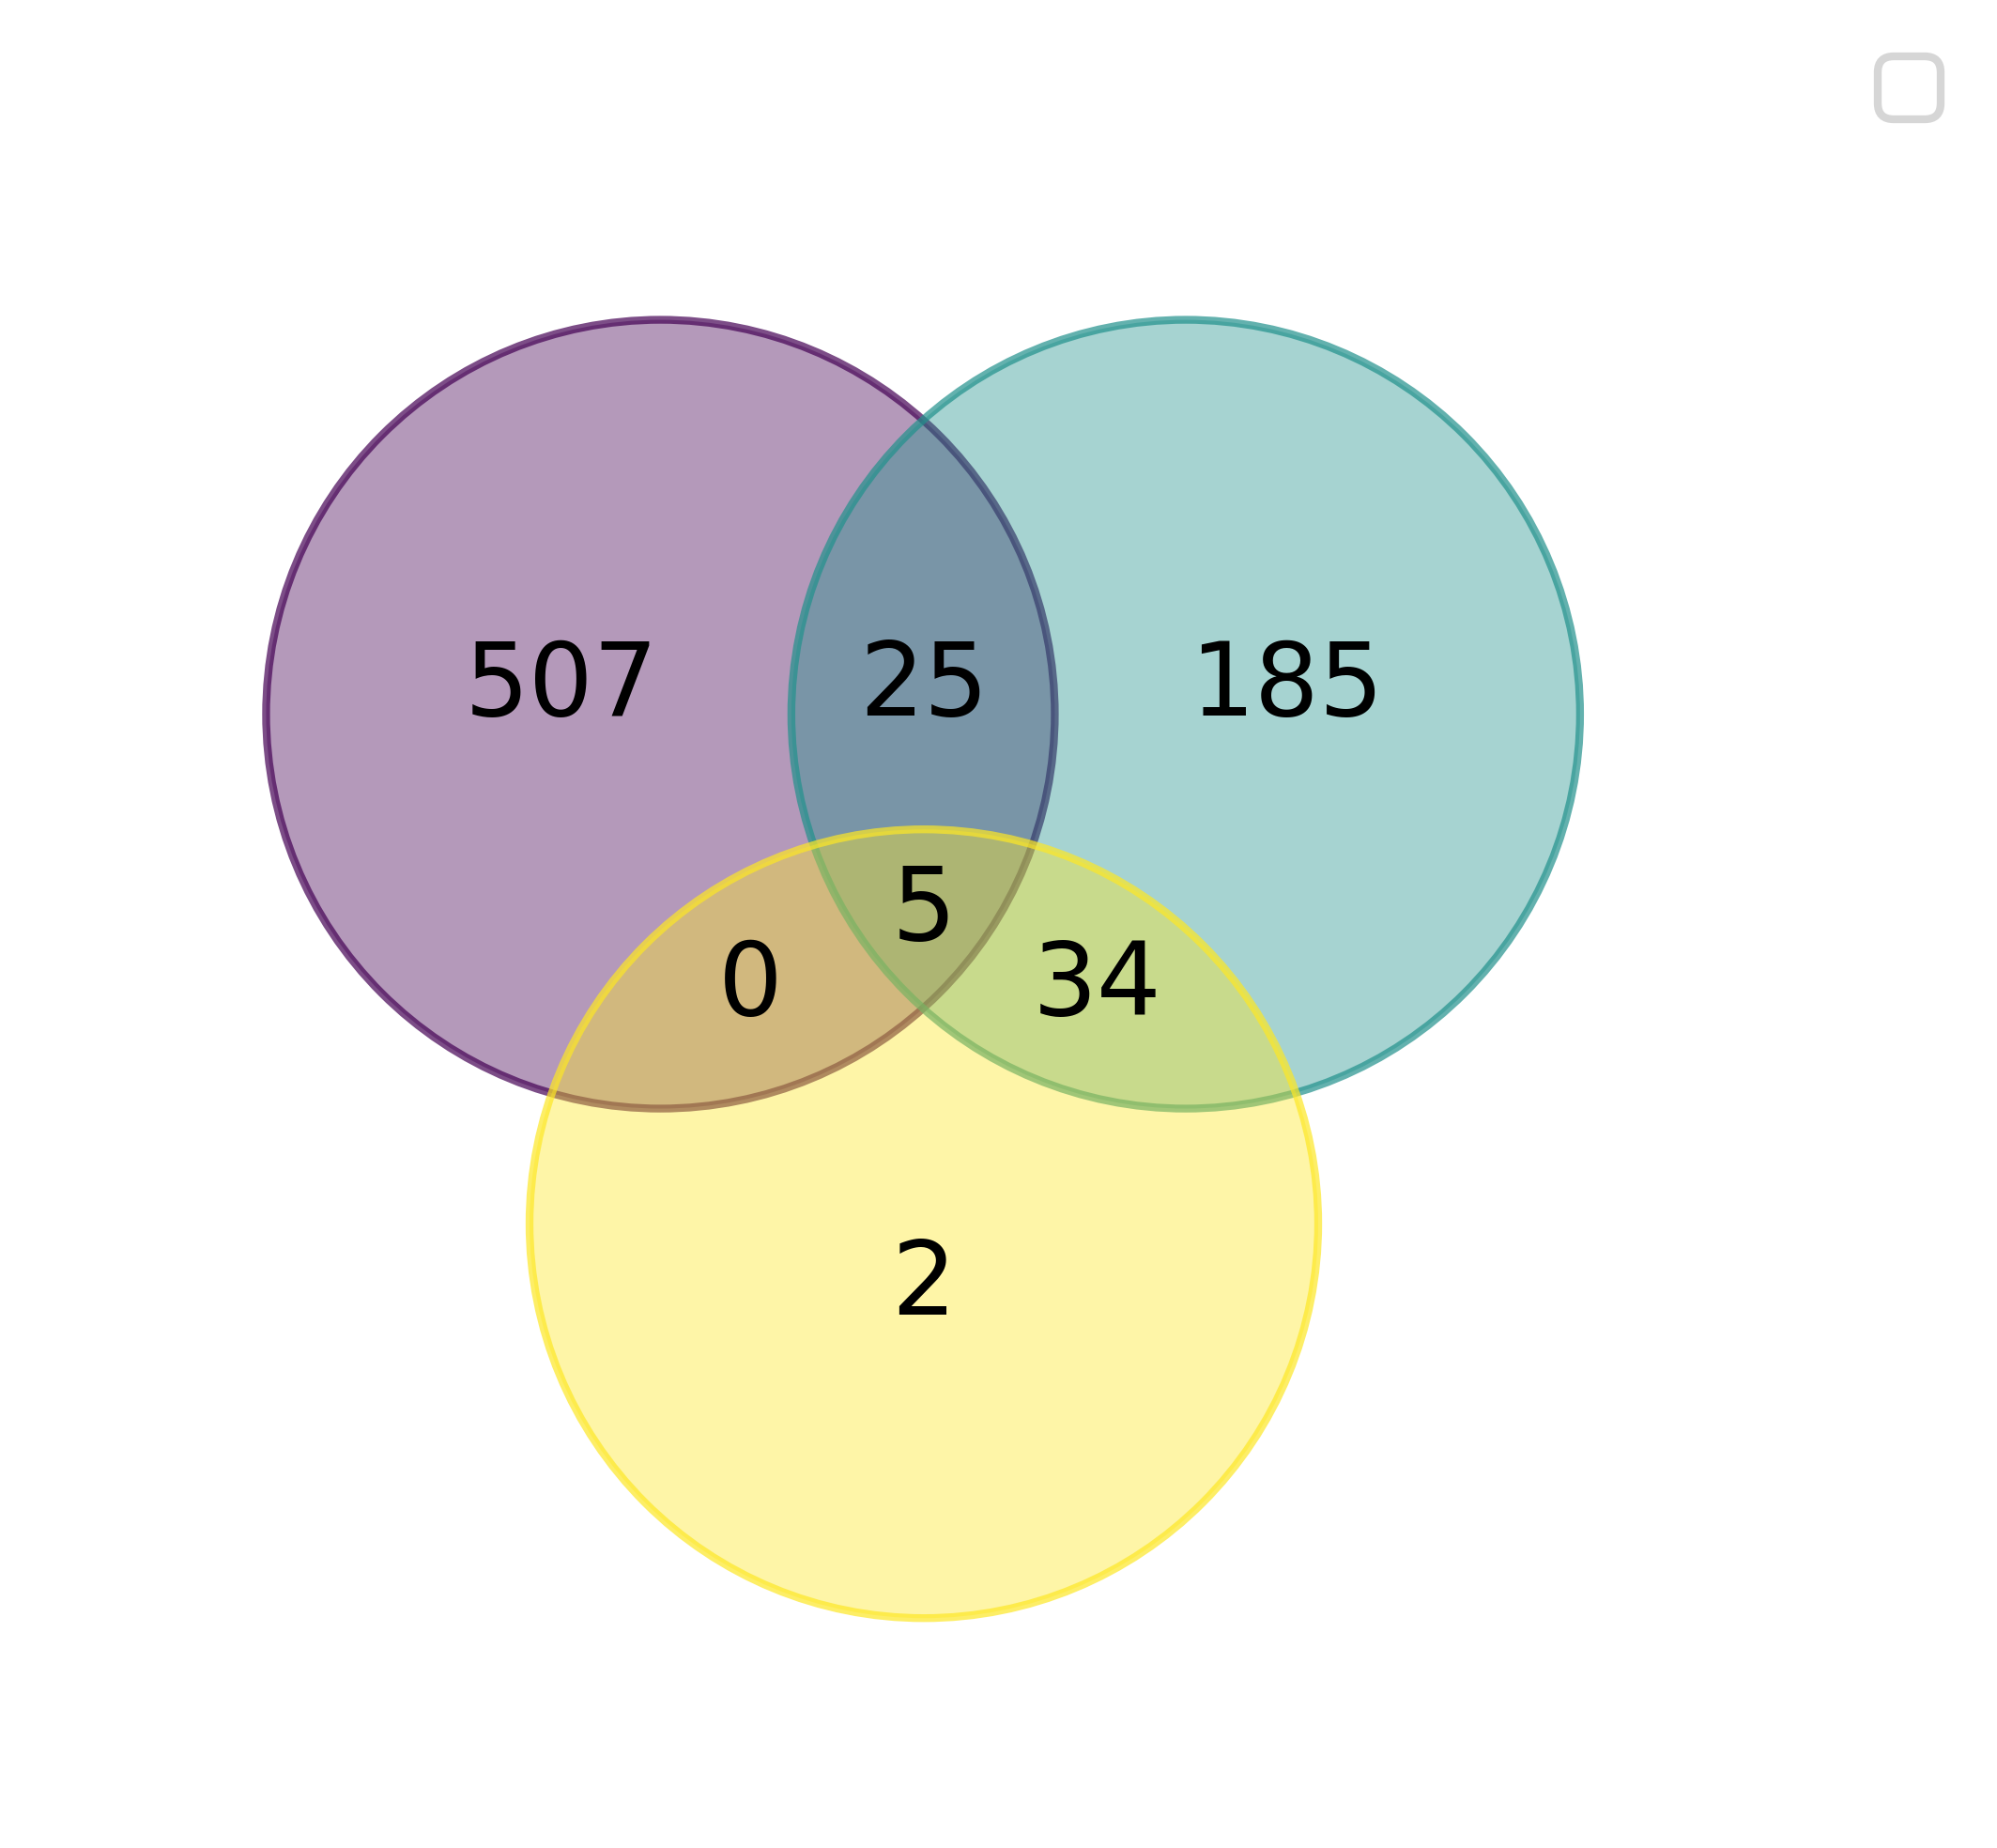

In [42]:
jcp_gene_list = set(all_compound_data.Metadata_Symbol)
ax = venn(
    {
        "Genes targeted in the JUMP-CP data set": jcp_gene_list,
        "Genes covered in the inferred GGI ": gene_ia_set,
        "Gene targets of the impactful OE conditions": specific_targets,
    },
    legend_loc="best",
    figsize=[4, 4],
)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.show()

In [24]:
spec_results = pd.read_csv(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
target_list = sorted(list(spec_orf_targets))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


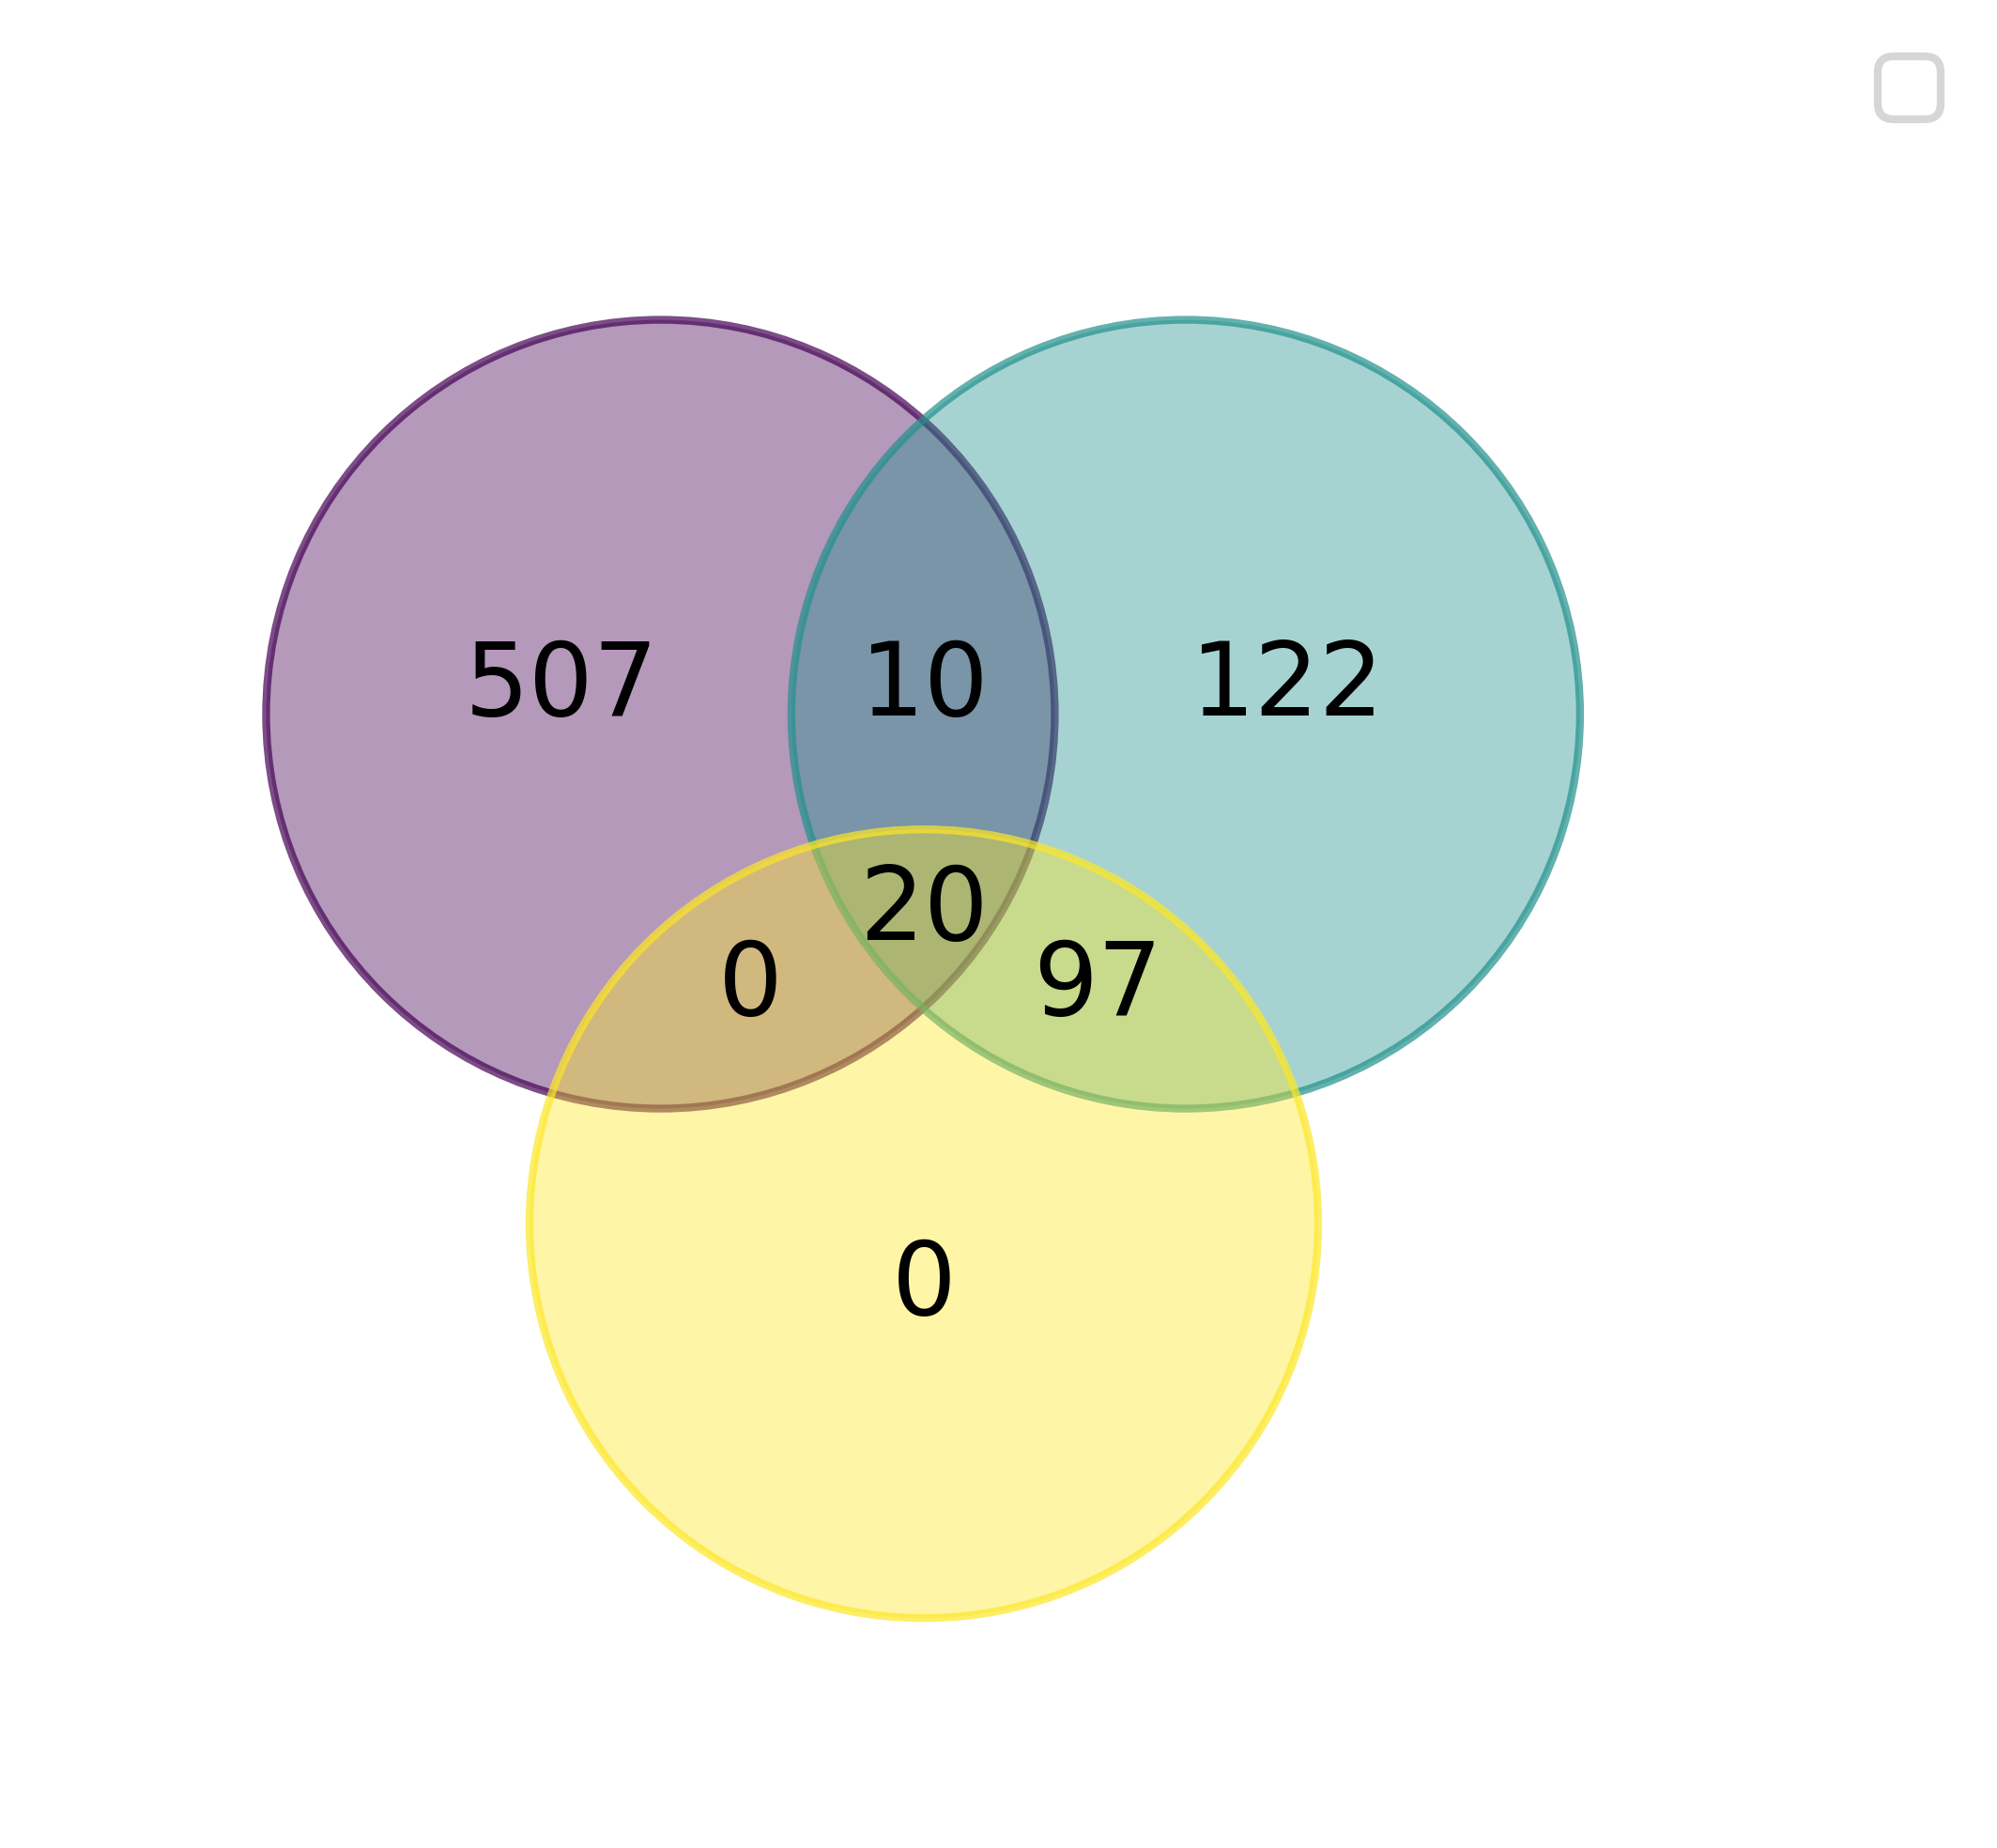

In [25]:
jcp_gene_list = set(all_compound_data.Metadata_Symbol)
ax = venn(
    {
        "Genes targeted in the JUMP-CP data set": jcp_gene_list,
        "Genes covered in the inferred GGI ": gene_ia_set,
        "Gene targets of the impactful KO conditions": spec_orf_targets,
    },
    legend_loc="best",
    figsize=[4, 4],
)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.show()

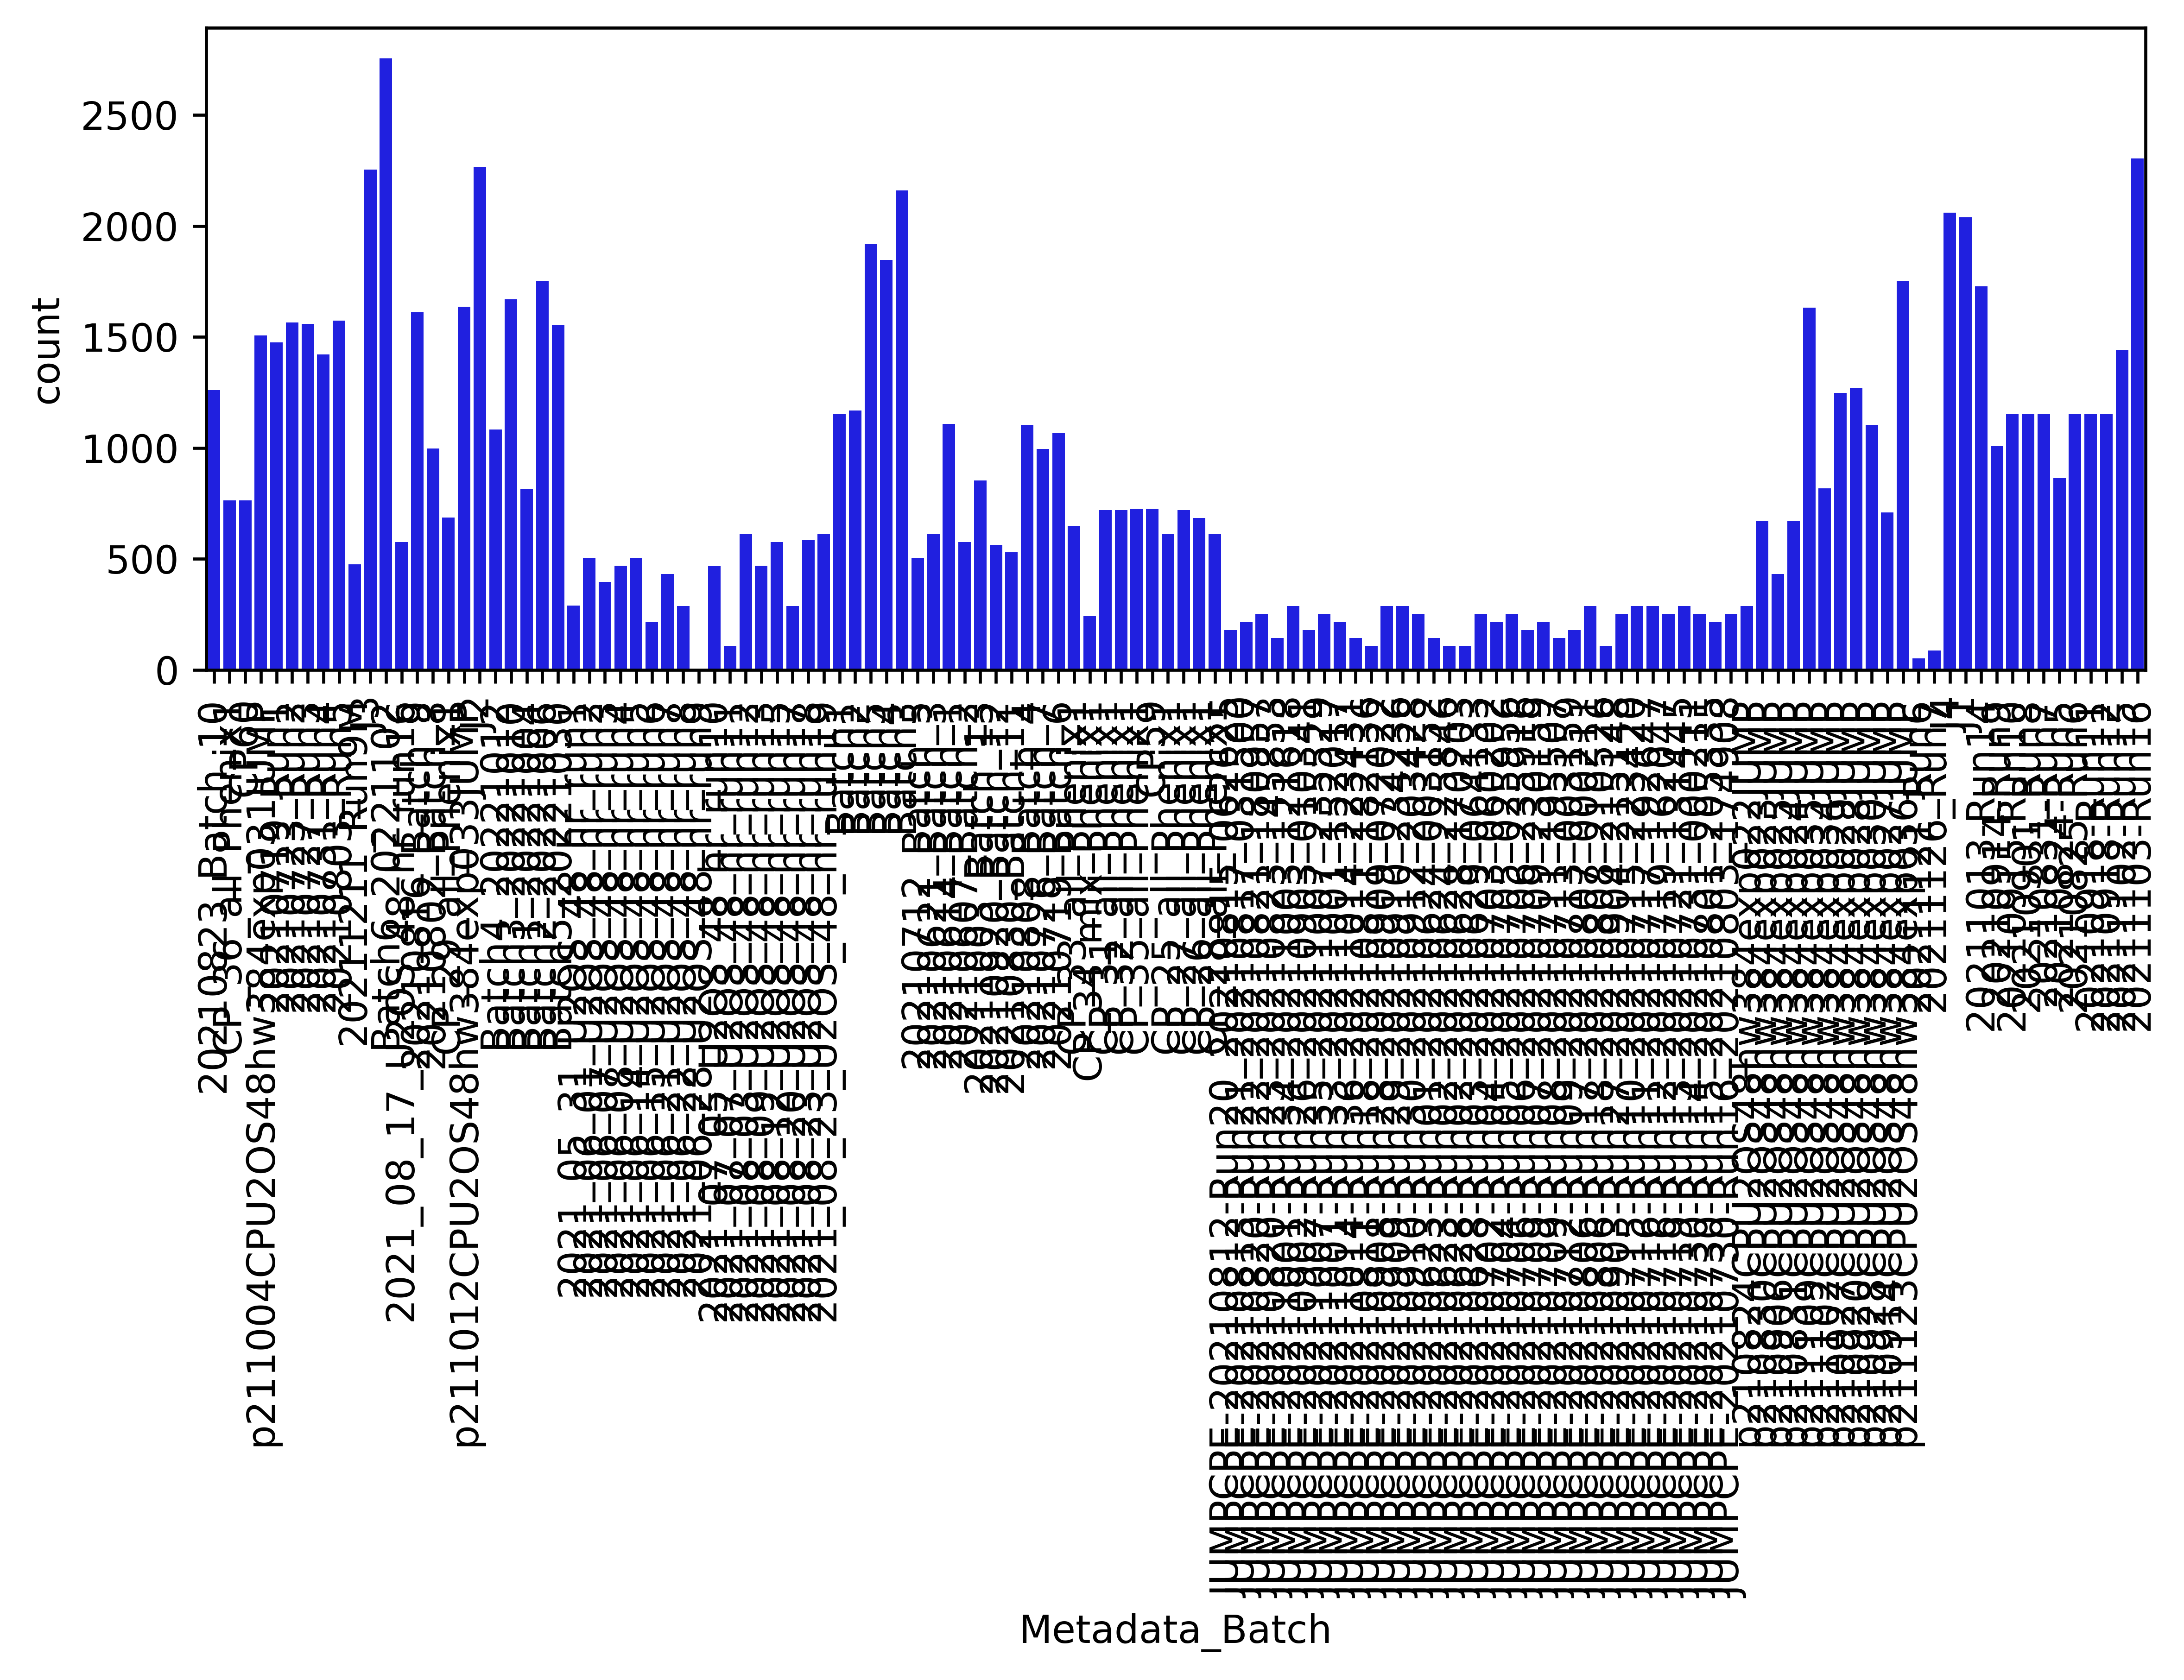

In [43]:
fig, ax = plt.subplots(figsize=[9, 3])
ax = sns.countplot(
    data=all_compound_data.loc[np.intersect1d(all_compound_data.Metadata_Symbol.astype(str),list(gene_ia_set_w_ctrl))],
    x="Metadata_Batch",
    # order=sorted(gene_ia_list),
    # hue="Metadata_Batch",
    palette=["b"],
)
plt.xticks(rotation=90)
plt.show()

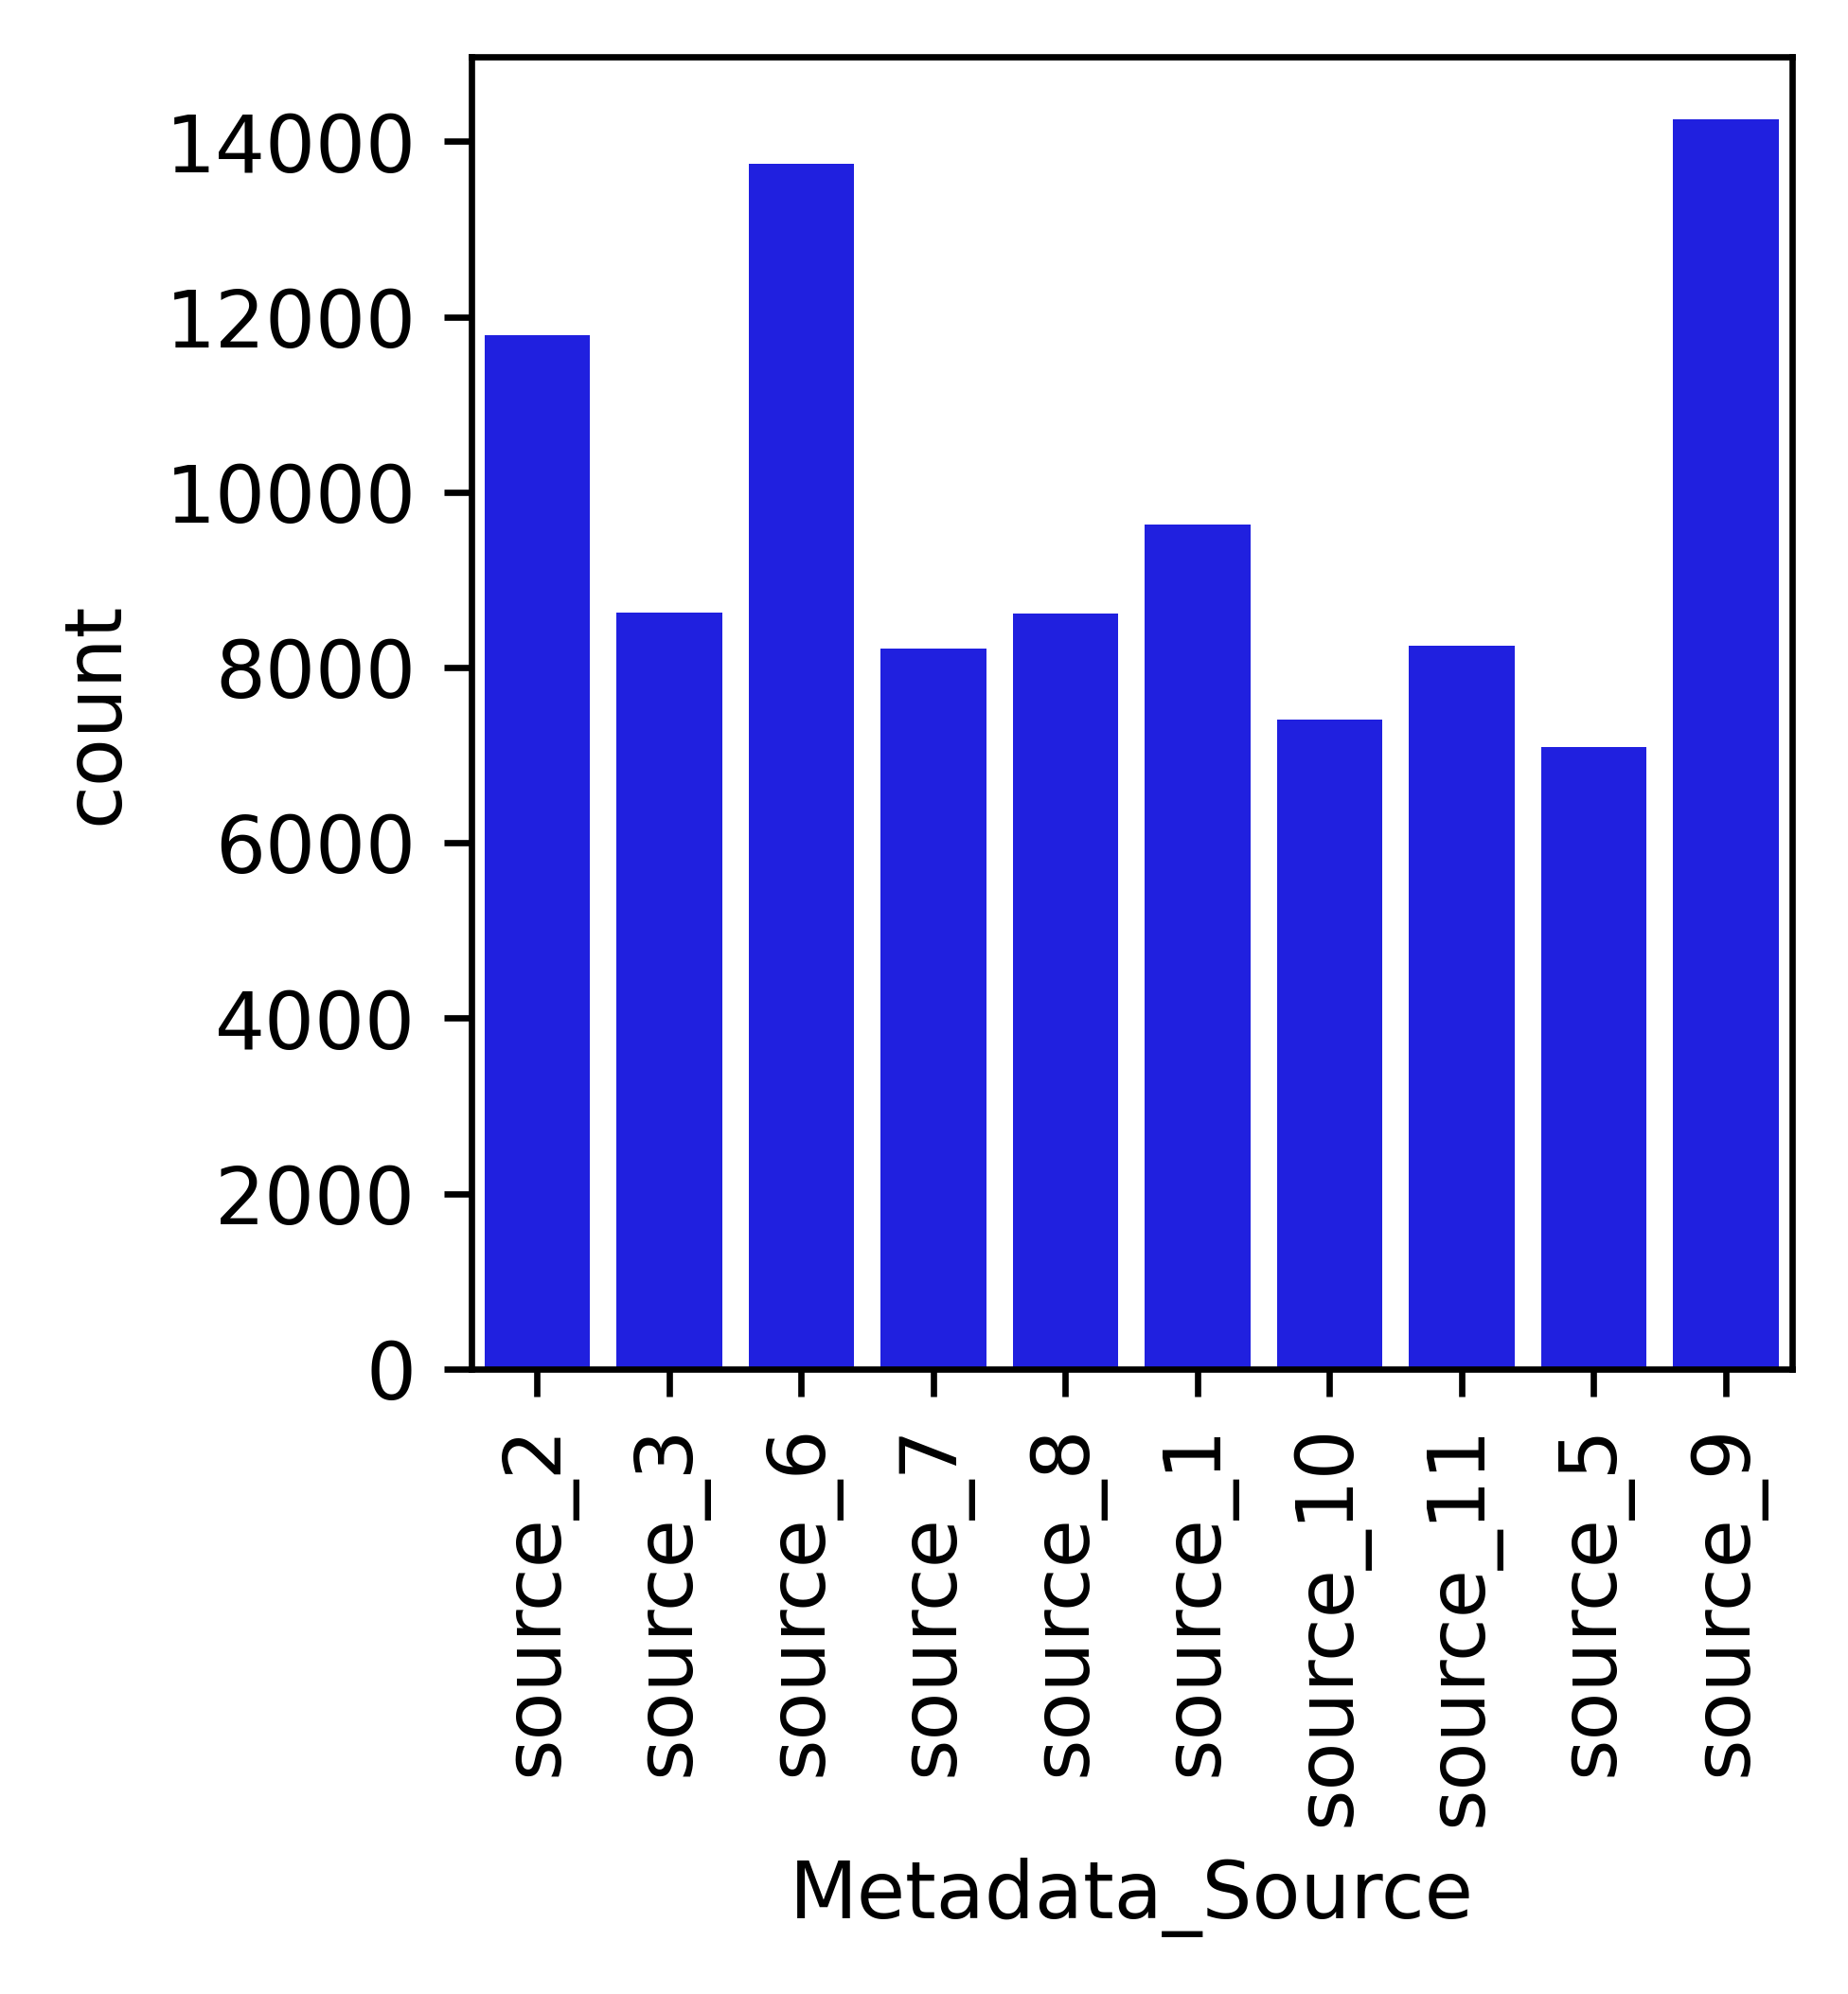

In [44]:
fig, ax = plt.subplots(figsize=[3, 3])
ax = sns.countplot(
    data=all_compound_data.loc[np.intersect1d(all_compound_data.Metadata_Symbol.astype(str),list(gene_ia_set_w_ctrl))],
    x="Metadata_Source",
    # order=sorted(gene_ia_list),
    # hue="Metadata_Batch",
    palette=["b"],
)
plt.xticks(rotation=90)
plt.show()

In [26]:
all_compound_data.to_csv('/data/xinyi/image2reg/data_new/experiments/jump_compound/all_compound_data.csv')

In [15]:
all_compound_data=pd.read_csv('/data/xinyi/image2reg/data_new/experiments/jump_compound/all_compound_data.csv',index_col=0)
all_compound_data=all_compound_data.rename(columns={'Metadata_Symbol.1':'Metadata_Symbol'})
all_compound_data

Unnamed: 0_x Metadata_Source     Metadata_Plate  \
Metadata_Symbol                                                    
DMSO                        0        source_1           UL000081   
DMSO                        2        source_1           UL000081   
DMSO                       43        source_1           UL000081   
DMSO                       45        source_1           UL000081   
DMSO                       46        source_1           UL000081   
...                       ...             ...                ...   
not found              156966       source_10  Dest210823-174422   
not found              156969       source_10  Dest210823-174422   
not found              156990       source_10  Dest210823-174422   
not found              156993       source_10  Dest210823-174422   
not found              157014       source_10  Dest210823-174422   

                Metadata_Well Metadata_JCP2022  Unnamed: 0_y  \
Metadata_Symbol                                                
DMSO                      A02   JCP2022_033924         33641   
DMSO                      A04   JCP2022_033924         33641   
DMSO                      A45   JCP2022_033924         33641   
DMSO                      A47   JCP2022_033924         33641   
DMSO                     AA02   JCP2022_033924         33641   
...                       ...              ...           ...   
not found                 N23   JCP2022_999999        115795   
not found                 O02   JCP2022_999999        115795   
not found                 O23   JCP2022_999999        115795   
not found                 P02   JCP2022_999999        115795   
not found                 P23   JCP2022_999999        115795   

                           Metadata_InChIKey                   Metadata_InChI  \
Metadata_Symbol                                                                 
DMSO             IAZDPXIOMUYVGZ-UHFFFAOYSA-N  InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
DMSO             IAZDPXIOMUYVGZ-UHFFFAOYSA-N  InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
DMSO             IAZDPXIOMUYVGZ-UHFFFAOYSA-N  InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
DMSO             IAZDPXIOMUYVGZ-UHFFFAOYSA-N  InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
DMSO             IAZDPXIOMUYVGZ-UHFFFAOYSA-N  InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
...                                      ...                              ...   
not found                                NaN                              NaN   
not found                                NaN                              NaN   
not found                                NaN                              NaN   
not found                                NaN                              NaN   
not found                                NaN                              NaN   

                              Metadata_Batch Metadata_PlateType  \
Metadata_Symbol                                                   
DMSO                         Batch4_20221012           COMPOUND   
DMSO                         Batch4_20221012           COMPOUND   
DMSO                         Batch4_20221012           COMPOUND   
DMSO                         Batch4_20221012           COMPOUND   
DMSO                         Batch4_20221012           COMPOUND   
...                                      ...                ...   
not found        2021_08_23_U2OS_48_hr_run18           COMPOUND   
not found        2021_08_23_U2OS_48_hr_run18           COMPOUND   
not found        2021_08_23_U2OS_48_hr_run18           COMPOUND   
not found        2021_08_23_U2OS_48_hr_run18           COMPOUND   
not found        2021_08_23_U2OS_48_hr_run18           COMPOUND   

                Metadata_Symbol  
Metadata_Symbol                  
DMSO                       DMSO  
DMSO                       DMSO  
DMSO                       DMSO  
DMSO                       DMSO  
DMSO                       DMSO  
...                         ...  
not found             not found  
not found             not found  
not found             not found  

---

### 2.2. Selected data set

We will now further assess the dimensions of the actual image data set that is available for the overexpression condition covered in our GGI.


#### 2.2.1. Data subsetting
To this end, we first subset the metadata accordingly.

In [20]:
ccompound_data = all_compound_data.loc[
    np.intersect1d(all_compound_data.Metadata_Symbol.astype(str),list(gene_ia_set_w_ctrl))
].sort_values(["Metadata_Plate", "Metadata_Well"])
ccompound_data

Unnamed: 0_x Metadata_Source Metadata_Plate Metadata_Well  \
Metadata_Symbol                                                              
DMSO                   293332        source_2     1053597806           A02   
DMSO                   293353        source_2     1053597806           A23   
AURKA                  293355        source_2     1053597806           B01   
DMSO                   293356        source_2     1053597806           B02   
DMSO                   293377        source_2     1053597806           B23   
...                       ...             ...            ...           ...   
AURKA                   80568        source_1       UL001799           Z03   
DMSO                    80569        source_1       UL001799           Z04   
DMSO                    80610        source_1       UL001799           Z45   
AURKA                   80611        source_1       UL001799           Z46   
DMSO                    80612        source_1       UL001799           Z47   

                Metadata_JCP2022  Unnamed: 0_y            Metadata_InChIKey  \
Metadata_Symbol                                                               
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
AURKA             JCP2022_037716         37405  IVUGFMLRJOCGAS-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
...                          ...           ...                          ...   
AURKA             JCP2022_037716         37405  IVUGFMLRJOCGAS-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   
AURKA             JCP2022_037716         37405  IVUGFMLRJOCGAS-UHFFFAOYSA-N   
DMSO              JCP2022_033924         33641  IAZDPXIOMUYVGZ-UHFFFAOYSA-N   

                                                    Metadata_InChI  \
Metadata_Symbol                                                      
DMSO                               InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
DMSO                               InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
AURKA            InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...   
DMSO                               InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
DMSO                               InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
...                                                            ...   
AURKA            InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...   
DMSO                               InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
DMSO                               InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   
AURKA            InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...   
DMSO                               InChI=1S/C2H6OS/c1-4(2)3/h1-2H3   

                   Metadata_Batch Metadata_PlateType Metadata_Symbol  
Metadata_Symbol                                                       
DMSO             20210712_Batch_5           COMPOUND            DMSO  
DMSO             20210712_Batch_5           COMPOUND            DMSO  
AURKA            20210712_Batch_5           COMPOUND           AURKA  
DMSO             20210712_Batch_5           COMPOUND            DMSO  
DMSO             20210712_Batch_5           COMPOUND            DMSO  
...                           ...                ...             ...  
AURKA             Batch5_20221030           COMPOUND           AURKA  
DMSO              Batch5_20221030           COMPOUND            DMSO  
DMSO              Batch5_20221030           COMPOUND            DMSO  
AURKA             Batch5_20221030           COMPOUND           AURKA  
DMSO              Batch5_20221030           COMPOUND            DMSO  

[97615 rows x 11 columns]

In [21]:
np.sum(ccompound_data.index=='DMSO')

88583

In [22]:
np.sum(ccompound_data.index!='DMSO')

9032

In [23]:
#subset to 6 wells per plate
nDMSO=6
wellInclude=np.repeat(False,ccompound_data.shape[0])
wellInclude[ccompound_data.index!='DMSO']=True
for s in np.unique(ccompound_data.Metadata_Source):
    print(s)
    sIdx=np.repeat(True,ccompound_data.shape[0])
    sIdx[ccompound_data.Metadata_Source!=s]=False
    for b in np.unique(ccompound_data.Metadata_Batch[sIdx]):
        print('batch ',b)
        bIdx=np.copy(sIdx)
        bIdx[ccompound_data.Metadata_Batch!=b]=False
        for p in np.unique(ccompound_data.Metadata_Plate[bIdx]):
            print('plate ',p)
            pIdx=np.copy(bIdx)
            pIdx[ccompound_data.Metadata_Plate!=p]=False
            dmsoIdx=np.arange(ccompound_data.shape[0])[np.logical_and(pIdx,ccompound_data.index=='DMSO')]
            np.random.seed(3)
            np.random.shuffle(dmsoIdx)
            wellInclude[dmsoIdx[:nDMSO]]=True

source_1
batch  Batch1_20221004
plate  UL001641
plate  UL001643
plate  UL001645
plate  UL001651
plate  UL001653
plate  UL001655
batch  Batch2_20221006
plate  UL001647
plate  UL001649
plate  UL001671
plate  UL001673
plate  UL001675
plate  UL001677
plate  UL001679
batch  Batch3_20221010
plate  UL000087
plate  UL000089
plate  UL000091
plate  UL001665
plate  UL001667
plate  UL001669
plate  UL001785
plate  UL001787
batch  Batch4_20221012
plate  UL000081
plate  UL000083
plate  UL000093
plate  UL000095
plate  UL000097
plate  UL001765
plate  UL001769
plate  UL001771
batch  Batch5_20221030
plate  UL001713
plate  UL001719
plate  UL001773
plate  UL001781
plate  UL001783
plate  UL001791
plate  UL001793
plate  UL001795
plate  UL001797
plate  UL001799
batch  Batch6_20221102
plate  UL000577
plate  UL000579
plate  UL000581
plate  UL000583
plate  UL000585
plate  UL000587
plate  UL000593
plate  UL000595
plate  UL000597
plate  UL000599
plate  UL001717
plate  UL001789
source_10
batch  2021_05_31_U2OS_48_h

In [24]:
np.sum(wellInclude)

19388

In [25]:
ccompound_data=ccompound_data[wellInclude]
ccompound_data.shape

(19388, 11)

---

#### 2.2.2. Scrape image-level data including cell counts

We will now scrape the corresponding image-level profile information from the AWS bucket that give us a first indication on how many nuclei per condition we are looking at although the actual number might differ as we will use our own segmentation model.

In [38]:
image_profile_formatter = (
    "https://cellpainting-gallery.s3.amazonaws.com/cpg0016-jump/"
    "{Metadata_Source}/workspace/analysis/{Metadata_Batch}/{Metadata_Plate}/analysis/{Metadata_Plate}-{Metadata_Well}-{Metadata_Site}/Image.csv"
)

In [39]:
all_img_dfs = Parallel(n_jobs=20)(
    delayed(get_image_data)(ccompound_data.iloc[i]) for i in tqdm(range(len(ccompound_data)))
)

  0%|          | 0/19388 [00:00<?, ?it/s]

In [40]:
all_img_df = pd.concat((df for df in all_img_dfs), ignore_index=True)
all_img_df = all_img_df.drop_duplicates(
    subset=[
        "Metadata_Source",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
    ]
)

In [41]:
all_img_df.to_csv('/data/xinyi/image2reg/data_new/experiments/jump_compound/all_img_df.csv')

---

#### 2.2.3. Scrape image location information

We will also add the corresponding image file locations and the links to the illumination correction functions to the data to check if all such information are available.

In [42]:
loaddata_formatter = (
    "https://cellpainting-gallery.s3.amazonaws.com/cpg0016-jump/"
    "{source}/workspace/load_data_csv/"
    "{batch}/{plate}/load_data_with_illum.csv.gz"
)

In [ ]:
all_img_loc_dfs = Parallel(n_jobs=20)(
    delayed(get_image_loc_data)(ccompound_data.iloc[i]) for i in tqdm(range(len(ccompound_data)))
)

  0%|          | 0/19388 [00:00<?, ?it/s]

In [44]:
all_img_loc_df = pd.concat((df for df in all_img_loc_dfs),ignore_index=True)
all_img_loc_df = all_img_loc_df.drop_duplicates(
    subset=[
        "Metadata_Source",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
    ]
)

In [45]:
drop_cols = []
for col in all_img_df.columns:
    if "File" in col or "Path" in col:
        drop_cols.append(col)

In [46]:
all_img_data = pd.merge(
    all_img_df.drop(columns=drop_cols),
    all_img_loc_df,
    on=[
        "Metadata_Source",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
    ],
    how="inner",
).merge(
    ccompound_data,
    on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well"],
)

In [47]:
all_img_data.loc[
    :,
    [
        "Metadata_Symbol",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "PathName_OrigDNA",
        "FileName_OrigDNA",
        'Metadata_InChIKey'
    ],
].head()

Metadata_Symbol Metadata_Batch Metadata_Plate Metadata_Well  Metadata_Site  \
0            DMSO             J3       A1166128           A17              1   
1            DMSO             J3       A1166128           A17              2   
2            DMSO             J3       A1166128           A17              3   
3            DMSO             J3       A1166128           A17              4   
4            DMSO             J3       A1166128           A17              5   

                                    PathName_OrigDNA  \
0  s3://cellpainting-gallery/cpg0016-jump/source_...   
1  s3://cellpainting-gallery/cpg0016-jump/source_...   
2  s3://cellpainting-gallery/cpg0016-jump/source_...   
3  s3://cellpainting-gallery/cpg0016-jump/source_...   
4  s3://cellpainting-gallery/cpg0016-jump/source_...   

                                    FileName_OrigDNA  \
0  HTS_A17_s1_w5C72C289C-F319-4CB6-83C3-96DEED3E1...   
1  HTS_A17_s2_w51AF940C8-1528-4A04-91A2-DA1F8BAD4...   
2  HTS_A17_s3_w5633248C2-9C6F-4102-A76F-9E90D8D52...   
3  HTS_A17_s4_w5E84BF7A5-C508-426D-A27E-7871BB62D...   
4  HTS_A17_s5_w5BCC96924-1267-4C85-AE85-CFE901513...   

             Metadata_InChIKey  
0  IAZDPXIOMUYVGZ-UHFFFAOYSA-N  
1  IAZDPXIOMUYVGZ-UHFFFAOYSA-N  
2  IAZDPXIOMUYVGZ-UHFFFAOYSA-N  
3  IAZDPXIOMUYVGZ-UHFFFAOYSA-N  
4  IAZDPXIOMUYVGZ-UHFFFAOYSA-N

In [54]:
np.unique(all_img_data['Metadata_InChIKey']).size

96

In [55]:
np.unique(all_img_data['Metadata_Symbol']).size

31

In [50]:
metadata_output_dir = os.path.join(
    "/data/xinyi/image2reg/data_new/resources/images/jump_compound", "metadata"
)
if not os.path.exists(metadata_output_dir):
    os.mkdir(metadata_output_dir)

all_img_data.to_csv(os.path.join(metadata_output_dir, "image_metadata.csv.gz"))

In [26]:
metadata_output_dir = os.path.join(
    "/data/xinyi/image2reg/data_new/resources/images/jump_compound", "metadata"
)

all_img_data=pd.read_csv(os.path.join(metadata_output_dir, "image_metadata.csv.gz"))
all_img_data
    

Unnamed: 0 Metadata_Source Metadata_Plate Metadata_Well  \
0                0        source_8       A1166128           A17   
1                1        source_8       A1166128           A17   
2                2        source_8       A1166128           A17   
3                3        source_8       A1166128           A17   
4                4        source_8       A1166128           A17   
...            ...             ...            ...           ...   
111616      111616        source_1       UL001799           Z03   
111617      111617        source_1       UL001799           Z46   
111618      111618        source_1       UL001799           Z46   
111619      111619        source_1       UL001799           Z46   
111620      111620        source_1       UL001799           Z46   

         Metadata_Batch  Metadata_Site  Count_Cells  \
0                    J3              1        113.0   
1                    J3              2        121.0   
2                    J3              3        151.0   
3                    J3              4        179.0   
4                    J3              5        150.0   
...                 ...            ...          ...   
111616  Batch5_20221030              4         70.0   
111617  Batch5_20221030              1         31.0   
111618  Batch5_20221030              2         31.0   
111619  Batch5_20221030              3         78.0   
111620  Batch5_20221030              4         35.0   

        Count_CellsIncludingEdges  Count_Cytoplasm  Count_Nuclei  ...  \
0                           129.0            113.0         113.0  ...   
1                           138.0            121.0         121.0  ...   
2                           168.0            151.0         151.0  ...   
3                           193.0            179.0         179.0  ...   
4                           168.0            150.0         150.0  ...   
...                           ...              ...           ...  ...   
111616                       77.0             70.0          70.0  ...   
111617                       36.0             31.0          31.0  ...   
111618                       41.0             31.0          31.0  ...   
111619                       89.0             78.0          78.0  ...   
111620                       44.0             35.0          35.0  ...   

                                          PathName_OrigER  \
0       s3://cellpainting-gallery/cpg0016-jump/source_...   
1       s3://cellpainting-gallery/cpg0016-jump/source_...   
2       s3://cellpainting-gallery/cpg0016-jump/source_...   
3       s3://cellpainting-gallery/cpg0016-jump/source_...   
4       s3://cellpainting-gallery/cpg0016-jump/source_...   
...                                                   ...   
111616  s3://cellpainting-gallery/cpg0016-jump/source_...   
111617  s3://cellpainting-gallery/cpg0016-jump/source_...   
111618  s3://cellpainting-gallery/cpg0016-jump/source_...   
111619  s3://cellpainting-gallery/cpg0016-jump/source_...   
111620  s3://cellpainting-gallery/cpg0016-jump/source_...   

                                        PathName_OrigMito  \
0       s3://cellpainting-gallery/cpg0016-jump/source_...   
1       s3://cellpainting-gallery/cpg0016-jump/source_...   
2       s3://cellpainting-gallery/cpg0016-jump/source_...   
3       s3://cellpainting-gallery/cpg0016-jump/source_...   
4       s3://cellpainting-gallery/cpg0016-jump/source_...   
...                                                   ...   
111616  s3://cellpainting-gallery/cpg0016-jump/source_...   
111617  s3://cellpainting-gallery/cpg0016-jump/source_...   
111618  s3://cellpainting-gallery/cpg0016-jump/source_...   
111619  s3://cellpainting-gallery/cpg0016-jump/source_...   
111620  s3://cellpainting-gallery/cpg0016-jump/source_...   

                                         PathName_OrigRNA  Unnamed: 0_x  \
0       s3://cellpainting-gallery/cpg0016-jump/source_...        848036   
1       s3://cellpainting-gallery/cpg0016-jump/so

---

##### 2.4.2. Scrape all images

While those sample images are interesting, we will now scrape all available images and thereby also create a corresponding metadata file.

In [34]:
def scrape_data_for_gene(image_data, output_dir, gene):
    print(gene)
    gene_image_metadata = {
        "Metadata_Source": [],
        "Metadata_Batch": [],
        "Metadata_Plate": [],
        "Metadata_Well": [],
        "Metadata_Site": [],
        "Metadata_Symbol": [],
        "ImageLoc": [],
        "IllumCorFuncLoc": [],
    }
    gene_image_data = image_data.loc[image_data.Metadata_Symbol == gene]
    raw_output_dir = os.path.join(output_dir, "raw")
    illum_cor_fun_dir = os.path.join(output_dir, "illum_cor_func")
    os.makedirs(raw_output_dir, exist_ok=True)
    os.makedirs(illum_cor_fun_dir, exist_ok=True)
    # s3_client = boto3.client("s3")
    session = boto3.Session(region_name = 'us-east-1')
    s3_client = session.client("s3", config=Config(region_name='us-east-1',signature_version=UNSIGNED))
    # s3_client = boto3.client("s3", aws_access_key_id="", aws_secret_access_key="")
    #s3_client._request_signer.sign = lambda *args, **kwargs: None

    for i in range(len(gene_image_data)):
        img_path_name = gene_image_data.iloc[i].PathName_OrigDNA
        img_file_name = gene_image_data.iloc[i].FileName_OrigDNA
        source = gene_image_data.iloc[i].Metadata_Source
        batch = gene_image_data.iloc[i].Metadata_Batch
        plate = gene_image_data.iloc[i].Metadata_Plate
        well = gene_image_data.iloc[i].Metadata_Well
        site = gene_image_data.iloc[i].Metadata_Site
        gene = gene_image_data.iloc[i].Metadata_Symbol
        illum_path_name = gene_image_data.iloc[i].PathName_IllumDNA
        illum_file_name = gene_image_data.iloc[i].FileName_IllumDNA
        illum_file_path = os.path.join(illum_path_name, illum_file_name)
        img_file_path = os.path.join(img_path_name, img_file_name)

        gene_image_metadata["Metadata_Source"].append(source)
        gene_image_metadata["Metadata_Batch"].append(batch)
        gene_image_metadata["Metadata_Plate"].append(plate)
        gene_image_metadata["Metadata_Well"].append(well)
        gene_image_metadata["Metadata_Site"].append(site)
        gene_image_metadata["Metadata_Symbol"].append(gene)

        # Define output file paths
        output_img_file_name = "_".join(
            [
                str(source),
                str(batch),
                str(plate),
                str(well),
                str(site),
                gene,
                img_file_name,
            ]
        )

        batch_raw_output_dir = os.path.join(raw_output_dir, str(batch))
        batch_illum_cor_fun_output_dir = os.path.join(illum_cor_fun_dir, str(batch))
        os.makedirs(batch_raw_output_dir, exist_ok=True)
        os.makedirs(batch_illum_cor_fun_output_dir, exist_ok=True)

        output_img_file_path = os.path.join(batch_raw_output_dir, output_img_file_name)
        output_illum_file_path = os.path.join(
            batch_illum_cor_fun_output_dir,
            str(batch) + "_" + gene + "_" + illum_file_name,
        )

        # Download image & illumination correction function
        if not os.path.exists(output_img_file_path):
            # print('downloading')
            response=s3_client.list_objects_v2(Bucket=img_file_path.split("/")[2],Prefix="/".join(img_file_path.split("/")[3:]))
            if 'Contents' not in response or len(response['Contents']) == 0:
                # print('not found')
                gene_image_metadata["ImageLoc"].append('not found')
                gene_image_metadata["IllumCorFuncLoc"].append('not found')
                continue
            s3_client.download_file(
                img_file_path.split("/")[2],
                "/".join(img_file_path.split("/")[3:]),
                output_img_file_path,
            )
        if not os.path.exists(output_illum_file_path):
            response=s3_client.list_objects_v2(Bucket=illum_file_path.split("/")[2],Prefix="/".join(illum_file_path.split("/")[3:]))
            if 'Contents' not in response or len(response['Contents']) == 0:
                # print('not found')
                gene_image_metadata["ImageLoc"].append('not found')
                gene_image_metadata["IllumCorFuncLoc"].append('not found')
                continue
            s3_client.download_file(
                illum_file_path.split("/")[2],
                "/".join(illum_file_path.split("/")[3:]),
                output_illum_file_path,
            )

        # Add output locations to metadata
        gene_image_metadata["ImageLoc"].append(
            "/".join(output_img_file_path.split("/")[-2:])
        )
        gene_image_metadata["IllumCorFuncLoc"].append(
            "/".join(output_illum_file_path.split("/")[-2:])
        )
    gene_image_metadata = pd.DataFrame(gene_image_metadata)
    return gene_image_metadata

In [35]:
from concurrent.futures import ThreadPoolExecutor

output_dir = "/data/xinyi/image2reg/data_new/resources/images/jump_compound"

with ThreadPoolExecutor(max_workers=20) as executor:
    gene_image_loc_metadata = list(
        executor.map(lambda gene: scrape_data_for_gene(all_img_data, output_dir, gene),
                     np.unique(all_img_data.Metadata_Symbol))
    )


APPBP2
AQP1
AURKA
AURKB
BIRC5
CCNA2
CDK1
CDK2
CDK6
DMSO
EEF1A2
FGF1
FGFR2
FGFR3
GABRB3
GSK3B
LGALS1
MAP3K2
MAP3K5
MAP3K9
MAPK8
PARP2
PCNA
PDGFRB
PLAT
PRKACA
RARA
THRA
TK1
TLR4
TNNC1


In [36]:
# metadata_output_dir = os.path.join(
#     "../../../data/resources/images/jump", "metadata"
# )

gene_image_loc_metadata = pd.concat(gene_image_loc_metadata)
gene_image_loc_metadata.to_csv(
    os.path.join(metadata_output_dir, "image_loc_metadata.csv.gz")
)
# all_img_data.to_csv(os.path.join(metadata_output_dir, "image_metadata.csv.gz"))

In [47]:
gene_image_loc_metadata.to_csv(
    os.path.join(metadata_output_dir, "image_loc_metadata_full.csv.gz")
)
all_img_data.to_csv(os.path.join(metadata_output_dir, "image_metadata_full.csv.gz"))

In [48]:
np.sum(gene_image_loc_metadata.ImageLoc=='not found')

351

In [49]:
gene_image_loc_metadata.shape

(111621, 8)

In [50]:
 all_img_data.shape

(111621, 2057)

In [56]:
# all_img_data=all_img_data[gene_image_loc_metadata.ImageLoc!='not found']
gene_image_loc_metadata=gene_image_loc_metadata[gene_image_loc_metadata.ImageLoc!='not found']
gene_image_loc_metadata.to_csv(
    os.path.join(metadata_output_dir, "image_loc_metadata.csv.gz")
)

---

##### 2.4.3 Illumination correction

After having scraped all images from the AWS bucket including the respective illumination correction functions, we now obtain illumination corrected images by simply applying those functions, i.e. deviding the raw image by the illumination correction function.

In [57]:
output_dir = "/data/xinyi/image2reg/data_new/resources/images/jump_compound"

image_root_dir = os.path.join(output_dir,"raw")
illum_root_dir = os.path.join(output_dir,"illum_cor_func")
batch_illum_image_loc_metadata = Parallel(n_jobs=1)(
    delayed(correct_illumination_for_batch)(
        gene_image_loc_metadata,
        image_root_dir,
        illum_root_dir,
        output_dir,
        batch,
    )
    for batch in tqdm(np.unique(gene_image_loc_metadata.Metadata_Batch))
)
illum_image_loc_metadata = pd.concat(batch_illum_image_loc_metadata)

  0%|          | 0/98 [00:00<?, ?it/s]

In [58]:
illum_image_loc_metadata.to_csv(
    os.path.join(metadata_output_dir, "image_loc_metadata.csv.gz")
)